In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, roc_auc_score, accuracy_score, f1_score, RocCurveDisplay, roc_curve, auc, ConfusionMatrixDisplay, classification_report

In [2]:
leafNames = ["Ulmus carpinifolia", "Acer", "Salix aurita", "Quercus", "Alnus incana",
             "Betula pubescens", "Salix alba 'Sericea'", "Populus tremula", "Ulmus glabra",
             "Sorbus aucuparia", "Salix sinerea", "Populus", "Tilia", "Sorbus intermedia", "Fagus silvatica"]

In [3]:
train_data, train_meta = arff.loadarff("SwedishLeaf/SwedishLeaf_Train.arff") 
test_data, test_meta = arff.loadarff("SwedishLeaf/SwedishLeaf_Test.arff")

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [4]:
# splitting Xtrain, ytrain, Xtest, ytest, Xval, yval from data
""" Had to minus one off of the y data because to fit in the cnn model it needs the amount of classes
    this being said it counts from zero so having a class with the value of 15 is out of range.
    Combined the test and training data to make it a 70-30 split """
# Xtrain, ytrain, Xtest, ytest = [], [], [], []
# for i in range(len(train_df)):
#     Xtrain.append(train_df.iloc[i][0:128])
#     ytrain.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
# for i in range(len(test_df)):
#     if i <= 290:
#         Xtrain.append(train_df.iloc[i][0:128])
#         ytrain.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1)
#     else:
#         Xtest.append(test_df.iloc[i][0:128])
#         ytest.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 

' Had to minus one off of the y data because to fit in the cnn model it needs the amount of classes\n    this being said it counts from zero so having a class with the value of 15 is out of range.\n    Combined the test and training data to make it a 70-30 split '

In [11]:
Xdata, ydata = [], []
for i in range(len(train_df)):
    Xdata.append(train_df.iloc[i][0:128])
    ydata.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
for i in range(len(test_df)):
    Xdata.append(test_df.iloc[i][0:128])
    ydata.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
  
# get a balenced number of each class in training and testing 
ten_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

Xdata = np.array(Xdata)
ydata = np.array(ydata)

for train_index, test_index in ten_fold.split(Xdata, ydata):
    Xtrain, Xtest = Xdata[train_index], Xdata[test_index]
    ytrain, ytest = ydata[train_index], ydata[test_index]
    Xtrain_10fcv_rnn = np.expand_dims(Xtrain, axis=1)
    Xtest_10fcv_rnn = np.expand_dims(Xtest, axis=1)
    ytrain_10fcv_rnn = np.asarray(ytrain).astype('float32')
    ytest_10fcv_rnn = np.asarray(ytest).astype('float32')
    Xtrain_10fcv_rnn = Xtrain_10fcv_rnn.astype('float32')
    Xtest_10fcv_rnn = Xtest_10fcv_rnn.astype('float32')

In [6]:
# Xdata, ydata = [], []
# for i in range(len(train_df)):
#     Xdata.append(train_df.iloc[i][0:128])
#     ydata.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
# for i in range(len(test_df)):
#     Xdata.append(test_df.iloc[i][0:128])
#     ydata.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
  

# Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.3, random_state=123)

In [5]:
# # reshapeing for dementions of the training set and testing set and converting it to a nparray
Xtrain_rnn = np.expand_dims(Xtrain, axis=1)
ytrain_rnn = np.asarray(ytrain).astype(np.float32)
Xtest_rnn = np.expand_dims(Xtest, axis=1)
ytest_rnn = np.asarray(ytest).astype(np.float32)

In [6]:
# # converting dtype of Xtrain_cnn and Xtest_cnn
Xtrain_rnn = Xtrain_rnn.astype('float32')
Xtest_rnn = Xtest_rnn.astype('float32')

In [7]:
def build_model_lstm():
    input_layer = keras.layers.Input(Xtrain_rnn.shape[1:])

    lstm1 = keras.layers.LSTM(128, return_sequences=True)(input_layer)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    lstm1 = keras.layers.ReLU()(lstm1)

    lstm2 = keras.layers.LSTM(256, return_sequences=True)(lstm1)
    lstm2 = keras.layers.BatchNormalization()(lstm2)
    lstm2 = keras.layers.ReLU()(lstm2)

    lstm3 = keras.layers.LSTM(128, return_sequences=True)(lstm2)
    lstm3 = keras.layers.BatchNormalization()(lstm3)
    lstm3 = keras.layers.ReLU()(lstm3)

    gap = keras.layers.GlobalAveragePooling1D()(lstm3)

    output_layer = keras.layers.Dense(len(leafNames), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def build_model_gru():
    input_layer = keras.layers.Input(Xtrain_rnn.shape[1:])

    gru1 = keras.layers.GRU(128, return_sequences=True)(input_layer)
    gru1 = keras.layers.BatchNormalization()(gru1)
    gru1 = keras.layers.ReLU()(gru1)

    gru2 = keras.layers.GRU(256, return_sequences=True)(gru1)
    gru2 = keras.layers.BatchNormalization()(gru2)
    gru2 = keras.layers.ReLU()(gru2)

    gru3 = keras.layers.GRU(128, return_sequences=True)(gru2)
    gru3 = keras.layers.BatchNormalization()(gru3)
    gru3 = keras.layers.ReLU()(gru3)

    gap = keras.layers.GlobalAveragePooling1D()(gru3)

    output_layer = keras.layers.Dense(len(leafNames), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def build_model_simplernn():
    input_layer = keras.layers.Input(Xtrain_rnn.shape[1:])

    gru1 = keras.layers.SimpleRNN(128, return_sequences=True)(input_layer)
    gru1 = keras.layers.BatchNormalization()(gru1)
    gru1 = keras.layers.ReLU()(gru1)

    lstm2 = keras.layers.SimpleRNN(256, return_sequences=True)(gru1)
    lstm2 = keras.layers.BatchNormalization()(lstm2)
    lstm2 = keras.layers.ReLU()(lstm2)

    gru3 = keras.layers.SimpleRNN(128, return_sequences=True)(lstm2)
    gru3 = keras.layers.BatchNormalization()(gru3)
    gru3 = keras.layers.ReLU()(gru3)

    gap = keras.layers.GlobalAveragePooling1D()(gru3)

    output_layer = keras.layers.Dense(len(leafNames), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [46]:
model_list = []
rnn_list = []
def build_model(epochs, batch_size, monitor, factor, patience, min_lr, kind, Xtrain, ytrain):
    epochs = 200
    batch_size = batch_size
    if kind == "lstm":
        
        model_lstm = build_model_lstm()
#         model_list.append(model_lstm)
        model_lstm.summary()
        
        callbacks = [
            keras.callbacks.ReduceLROnPlateau(
            monitor=monitor, factor=factor, patience=patience, min_lr=min_lr
            ),
            keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1),
        ]

        model_lstm.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"],
        )

        rnn_lstm = model_lstm.fit(
            Xtrain,
            ytrain,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            verbose=1,
        )
        
#         rnn_list.append(rnn_lstm)
        return model_lstm
        
        
    elif kind == "gru":
        
        model_gru = build_model_gru()
#         model_list.append(model_gru)
        model_gru.summary()
        
        callbacks = [
            keras.callbacks.ReduceLROnPlateau(
                monitor=monitor, factor=factor, patience=patience, min_lr=min_lr
            ),
            keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1),
        ]

        model_gru.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"],
        )

        rnn_gru = model_gru.fit(
            Xtrain,
            ytrain,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            verbose=1,
        )
#         rnn_list.append(rnn_gru)
        return model_gru
        
    elif kind == "simplernn":
        
        model_simplernn = build_model_simplernn()
#         model_list.append(model_simplernn)
        model_simplernn.summary()
        
        callbacks = [
            keras.callbacks.ReduceLROnPlateau(
                monitor=monitor, factor=factor, patience=patience, min_lr=min_lr
            ),
            keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=1),
        ]

        model_simplernn.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"],
        )

        rnn_simplernn = model_simplernn.fit(
            Xtrain,
            ytrain,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            verbose=1,
        )
#         rnn_list.append(rnn_simplernn)
        
        return model_simplernn
        

In [11]:
model_kind_list = ["lstm", "gru", "simplernn"]
for i in model_kind_list:
    build_model(i)

2022-12-06 10:55:05.343725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256)            1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1, 256)            0     

2022-12-06 10:55:08.381710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10/10 [==============================] - 12s 237ms/step - loss: 1.7949 - sparse_categorical_accuracy: 0.4626 - val_loss: 2.7074 - val_sparse_categorical_accuracy: 0.0506
Epoch 2/200
10/10 [==============================] - 0s 22ms/step - loss: 0.7103 - sparse_categorical_accuracy: 0.8362 - val_loss: 2.7064 - val_sparse_categorical_accuracy: 0.1392
Epoch 3/200
10/10 [==============================] - 0s 19ms/step - loss: 0.4622 - sparse_categorical_accuracy: 0.8824 - val_loss: 2.7056 - val_sparse_categorical_accuracy: 0.0949
Epoch 4/200
10/10 [==============================] - 0s 23ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9380 - val_loss: 2.7055 - val_sparse_categorical_accuracy: 0.0506
Epoch 5/200
10/10 [==============================] - 0s 23ms/step - loss: 0.2102 - sparse_categorical_accuracy: 0.9603 - val_loss: 2.7054 - val_sparse_categorical_accuracy: 0.0696
Epoch 6/200
10/10 [==============================] - 0s 26ms/step - loss: 0.1612 - sparse_categorical_accuracy

10/10 [==============================] - 0s 37ms/step - loss: 9.4073e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3589 - val_sparse_categorical_accuracy: 0.8861
Epoch 92/200
10/10 [==============================] - 0s 17ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3570 - val_sparse_categorical_accuracy: 0.8987
Epoch 93/200
10/10 [==============================] - 0s 18ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.9114
Epoch 94/200
10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4759 - val_sparse_categorical_accuracy: 0.8861
Epoch 95/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5020 - val_sparse_categorical_accuracy: 0.8861
Epoch 96/200
10/10 [==============================] - 0s 17ms/step - loss: 0.0020 - sparse_categorical_a

Epoch 136/200
10/10 [==============================] - 0s 28ms/step - loss: 7.6383e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4113 - val_sparse_categorical_accuracy: 0.8987
Epoch 137/200
10/10 [==============================] - 0s 25ms/step - loss: 9.2930e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8987
Epoch 138/200
10/10 [==============================] - 0s 39ms/step - loss: 7.3521e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4094 - val_sparse_categorical_accuracy: 0.8924
Epoch 139/200
10/10 [==============================] - 0s 18ms/step - loss: 6.6640e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4149 - val_sparse_categorical_accuracy: 0.8861
Epoch 140/200
10/10 [==============================] - 0s 18ms/step - loss: 0.0010 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4165 - val_sparse_categorical_accuracy: 0.8861
Epoch 141/200
10/10 [==============================] - 0s 18ms/step - loss

10/10 [==============================] - 0s 19ms/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.5164 - val_sparse_categorical_accuracy: 0.8418
Epoch 73/200
10/10 [==============================] - 0s 16ms/step - loss: 0.0362 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.7785
Epoch 74/200
10/10 [==============================] - 0s 16ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.7299 - val_sparse_categorical_accuracy: 0.7785
Epoch 75/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.7445 - val_sparse_categorical_accuracy: 0.8165
Epoch 76/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9984 - val_loss: 1.1025 - val_sparse_categorical_accuracy: 0.7785
Epoch 77/200
10/10 [==============================] - 0s 16ms/step - loss: 0.0142 - sparse_categorical_accur

10/10 [==============================] - 0s 22ms/step - loss: 0.0989 - sparse_categorical_accuracy: 0.9841 - val_loss: 1.3771 - val_sparse_categorical_accuracy: 0.6772
Epoch 14/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0690 - sparse_categorical_accuracy: 0.9905 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.7152
Epoch 15/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9952 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.7089
Epoch 16/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9936 - val_loss: 1.0042 - val_sparse_categorical_accuracy: 0.7785
Epoch 17/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.8165
Epoch 18/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0388 - sparse_categorical_accur

10/10 [==============================] - 0s 9ms/step - loss: 0.0037 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.3962 - val_sparse_categorical_accuracy: 0.8797
Epoch 00103: early stopping


In [15]:
# grid search for rnn model
# had to comment out some hyper parameters due to time training the model and hardware availabe to use
# acc_scores, cohen_kappa_scores, roc_auc_scores, f1_scores, hyper_params = [], [], [], [], []
# monitorList = ["val_loss", "sparse_categorical_accuracy"]
# classes_of_classifier = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
# epochs = 200
# patience = 10
# factor = .05
# count = 0
# model_kind_list = ["lstm", "gru", "simplernn"]
# # for epochs in range(100, 1001, 100):
# for kind in model_kind_list:
#     for batch_size in range(8, 65, 8):
#         for monitor in monitorList:
# #             for factor in range(10, 60, 10):
#     #             for patience in range(10, 51, 10):
#             for min_lr in range(1000, 10001, 1000):
#                 count += 1
#                 print(count)
#                 model = build_model(epochs, batch_size, monitor, factor, patience, 1/min_lr, kind, Xtrain_rnn, ytrain_rnn)

#                 ytest_10fcv_rnn = ytest

#                 hyper_params.append([epochs, batch_size, monitor, factor, patience, 1/min_lr])

#                 ypred_10fcv_rnn = model.predict(Xtest_10fcv_rnn)
#                 ypred_10fcv_rnn = ypred_10fcv_rnn.argmax(axis=-1)


#                 cohen_kappa_scores.append(cohen_kappa_score(ytest_10fcv_rnn, ypred_10fcv_rnn, labels=classes_of_classifier))
#                 acc_scores.append(accuracy_score(ytest_10fcv_rnn, ypred_10fcv_rnn))

#                 lb = LabelBinarizer()
#                 lb.fit(ytest_10fcv_rnn)
#                 ytest_10fcv_rnn = lb.transform(ytest_10fcv_rnn)
#                 ypred_10fcv_rnn = lb.transform(ypred_10fcv_rnn)

#                 roc_auc_scores.append(roc_auc_score(ytest_10fcv_rnn, ypred_10fcv_rnn, average="weighted", multi_class="ovr"))
#                 f1_scores.append(f1_score(ytest_10fcv_rnn, ypred_10fcv_rnn, labels=classes_of_classifier, average="weighted"))


# for i in range(len(acc_scores)):
#     print(hyper_params[i])
#     print(acc_scores[i])
#     print(cohen_kappa_scores[i])
#     print(roc_auc_scores[i])
#     print(f1_scores[i])

1
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1, 128)]          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_27 (Batc (None, 1, 128)            512       
_________________________________________________________________
re_lu_27 (ReLU)              (None, 1, 128)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_28 (Batc (None, 1, 256)            1024      
_________________________________________________________________
re_lu_28 (ReLU)              (None, 1, 256)            0 

102/102 [==============================] - 9s 23ms/step - loss: 1.5191 - sparse_categorical_accuracy: 0.4988 - val_loss: 2.6895 - val_sparse_categorical_accuracy: 0.1330
Epoch 2/200
102/102 [==============================] - 1s 10ms/step - loss: 0.9870 - sparse_categorical_accuracy: 0.6840 - val_loss: 2.6055 - val_sparse_categorical_accuracy: 0.0837
Epoch 3/200
102/102 [==============================] - 1s 10ms/step - loss: 0.8499 - sparse_categorical_accuracy: 0.7062 - val_loss: 2.1883 - val_sparse_categorical_accuracy: 0.3399
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7355 - sparse_categorical_accuracy: 0.7568 - val_loss: 1.1576 - val_sparse_categorical_accuracy: 0.7537
Epoch 5/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.7716 - val_loss: 0.5795 - val_sparse_categorical_accuracy: 0.7980
Epoch 6/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6574 - sparse_categorica

102/102 [==============================] - 1s 10ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.8670
Epoch 15/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.5214 - val_sparse_categorical_accuracy: 0.8473
Epoch 16/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4470 - sparse_categorical_accuracy: 0.8457 - val_loss: 0.4300 - val_sparse_categorical_accuracy: 0.8177
Epoch 17/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.5132 - val_sparse_categorical_accuracy: 0.8227
Epoch 18/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.6037 - val_sparse_categorical_accuracy: 0.7931
Epoch 19/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3492 - sparse_categ

102/102 [==============================] - 1s 10ms/step - loss: 0.5218 - sparse_categorical_accuracy: 0.8099 - val_loss: 0.6423 - val_sparse_categorical_accuracy: 0.7783
Epoch 11/200
102/102 [==============================] - 1s 10ms/step - loss: 0.5029 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.5269 - val_sparse_categorical_accuracy: 0.8227
Epoch 12/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4543 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.7783
Epoch 13/200
102/102 [==============================] - 1s 10ms/step - loss: 0.5098 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.6005 - val_sparse_categorical_accuracy: 0.8227
Epoch 14/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4851 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.5040 - val_sparse_categorical_accuracy: 0.8227
Epoch 15/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4381 - sparse_categ

102/102 [==============================] - 1s 9ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.8185 - val_loss: 0.8915 - val_sparse_categorical_accuracy: 0.6847
Epoch 9/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5143 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.5163 - val_sparse_categorical_accuracy: 0.8276
Epoch 10/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5063 - sparse_categorical_accuracy: 0.8198 - val_loss: 0.8119 - val_sparse_categorical_accuracy: 0.6847
Epoch 11/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4352 - sparse_categorical_accuracy: 0.8457 - val_loss: 0.5496 - val_sparse_categorical_accuracy: 0.7882
Epoch 12/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.8704 - val_loss: 1.2006 - val_sparse_categorical_accuracy: 0.6256
Epoch 13/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4729 - sparse_categorical_

102/102 [==============================] - 1s 10ms/step - loss: 0.4407 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4678 - val_sparse_categorical_accuracy: 0.8325
Epoch 16/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3898 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.6229 - val_sparse_categorical_accuracy: 0.7783
Epoch 17/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.5840 - val_sparse_categorical_accuracy: 0.8276
Epoch 18/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3334 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.5920 - val_sparse_categorical_accuracy: 0.7833
Epoch 19/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3614 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.9376 - val_sparse_categorical_accuracy: 0.6749
Epoch 20/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3996 - sparse_categori

102/102 [==============================] - 1s 9ms/step - loss: 0.5082 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.5259 - val_sparse_categorical_accuracy: 0.8522
Epoch 10/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4645 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.9151 - val_sparse_categorical_accuracy: 0.6847
Epoch 11/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4681 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.7635
Epoch 12/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4757 - sparse_categorical_accuracy: 0.8259 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.6749
Epoch 13/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5220 - sparse_categorical_accuracy: 0.8346 - val_loss: 0.5707 - val_sparse_categorical_accuracy: 0.8079
Epoch 14/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3800 - sparse_categorical

102/102 [==============================] - 12s 26ms/step - loss: 1.5025 - sparse_categorical_accuracy: 0.5321 - val_loss: 2.6756 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
102/102 [==============================] - 1s 12ms/step - loss: 0.9302 - sparse_categorical_accuracy: 0.6840 - val_loss: 2.6161 - val_sparse_categorical_accuracy: 0.0887
Epoch 3/200
102/102 [==============================] - 1s 11ms/step - loss: 0.8157 - sparse_categorical_accuracy: 0.7556 - val_loss: 2.2906 - val_sparse_categorical_accuracy: 0.1576
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7529 - sparse_categorical_accuracy: 0.7432 - val_loss: 1.6570 - val_sparse_categorical_accuracy: 0.4483
Epoch 5/200
102/102 [==============================] - 1s 14ms/step - loss: 0.7062 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.8782 - val_sparse_categorical_accuracy: 0.7192
Epoch 6/200
102/102 [==============================] - 2s 16ms/step - loss: 0.5748 - sparse_categoric

102/102 [==============================] - 1s 10ms/step - loss: 0.7578 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.2118 - val_sparse_categorical_accuracy: 0.3498
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7312 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.2645 - val_sparse_categorical_accuracy: 0.6552
Epoch 5/200
102/102 [==============================] - 1s 9ms/step - loss: 0.7391 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.8675 - val_sparse_categorical_accuracy: 0.7143
Epoch 6/200
102/102 [==============================] - 1s 9ms/step - loss: 0.6689 - sparse_categorical_accuracy: 0.7679 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.7192
Epoch 7/200
102/102 [==============================] - 1s 10ms/step - loss: 0.5337 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.5231 - val_sparse_categorical_accuracy: 0.7833
Epoch 8/200
102/102 [==============================] - 1s 10ms/step - loss: 0.5940 - sparse_categorical_

102/102 [==============================] - 1s 9ms/step - loss: 0.3887 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.8522
Epoch 21/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.4643 - val_sparse_categorical_accuracy: 0.8621
Epoch 22/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3871 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.8128
Epoch 23/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3859 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.4774 - val_sparse_categorical_accuracy: 0.8374
Epoch 24/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.4985 - val_sparse_categorical_accuracy: 0.8473
Epoch 25/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3809 - sparse_categorical

102/102 [==============================] - 1s 10ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.6673 - val_sparse_categorical_accuracy: 0.7734
Epoch 12/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4453 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.6418 - val_sparse_categorical_accuracy: 0.8128
Epoch 13/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4934 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.6552
Epoch 14/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4645 - sparse_categorical_accuracy: 0.8346 - val_loss: 0.5474 - val_sparse_categorical_accuracy: 0.7931
Epoch 15/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4502 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.6908 - val_sparse_categorical_accuracy: 0.7685
Epoch 16/200
102/102 [==============================] - 1s 10ms/step - loss: 0.4542 - sparse_categ

Epoch 56/200
102/102 [==============================] - 1s 9ms/step - loss: 0.2278 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8670
Epoch 57/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2485 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.8227
Epoch 58/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.6250 - val_sparse_categorical_accuracy: 0.8177
Epoch 59/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2752 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.4502 - val_sparse_categorical_accuracy: 0.8522
Epoch 60/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.4397 - val_sparse_categorical_accuracy: 0.8522
Epoch 61/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2018 - 

102/102 [==============================] - 1s 9ms/step - loss: 0.3646 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.6003 - val_sparse_categorical_accuracy: 0.7980
Epoch 27/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3567 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8818
Epoch 28/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3645 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.8294 - val_sparse_categorical_accuracy: 0.7438
Epoch 29/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3091 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.4999 - val_sparse_categorical_accuracy: 0.8227
Epoch 30/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.3432 - val_sparse_categorical_accuracy: 0.8719
Epoch 31/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2993 - sparse_catego

102/102 [==============================] - 1s 9ms/step - loss: 0.7255 - sparse_categorical_accuracy: 0.7519 - val_loss: 1.3798 - val_sparse_categorical_accuracy: 0.6601
Epoch 5/200
102/102 [==============================] - 1s 9ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.8246 - val_sparse_categorical_accuracy: 0.7438
Epoch 6/200
102/102 [==============================] - 1s 9ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.7143
Epoch 7/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5506 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.8030
Epoch 8/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5339 - sparse_categorical_accuracy: 0.8099 - val_loss: 0.9100 - val_sparse_categorical_accuracy: 0.6700
Epoch 9/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5895 - sparse_categorical_accu

102/102 [==============================] - 1s 9ms/step - loss: 0.4145 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.8079
Epoch 16/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4331 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.8325
Epoch 17/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.3940 - val_sparse_categorical_accuracy: 0.8867
Epoch 18/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4303 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4909 - val_sparse_categorical_accuracy: 0.8276
Epoch 19/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.6849 - val_sparse_categorical_accuracy: 0.7094
Epoch 20/200
102/102 [==============================] - 1s 9ms/step - loss: 0.4191 - sparse_categorical

102/102 [==============================] - 1s 10ms/step - loss: 0.9445 - sparse_categorical_accuracy: 0.7037 - val_loss: 2.6206 - val_sparse_categorical_accuracy: 0.1133
Epoch 3/200
102/102 [==============================] - 1s 10ms/step - loss: 0.9032 - sparse_categorical_accuracy: 0.6963 - val_loss: 2.2955 - val_sparse_categorical_accuracy: 0.1823
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7752 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.3649 - val_sparse_categorical_accuracy: 0.6207
Epoch 5/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.7963 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.6798
Epoch 6/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.7438
Epoch 7/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6019 - sparse_categorica

Epoch 47/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2658 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.8276
Epoch 48/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.4637 - val_sparse_categorical_accuracy: 0.8374
Epoch 49/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.4636 - val_sparse_categorical_accuracy: 0.8374
Epoch 50/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.3895 - val_sparse_categorical_accuracy: 0.8966
Epoch 00050: early stopping
16
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 1, 128)]          0         
_____________________

Epoch 31/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.6179 - val_sparse_categorical_accuracy: 0.7685
Epoch 32/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3489 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.5950 - val_sparse_categorical_accuracy: 0.8177
Epoch 33/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.5357 - val_sparse_categorical_accuracy: 0.8276
Epoch 34/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2775 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.3270 - val_sparse_categorical_accuracy: 0.8719
Epoch 35/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.8152 - val_sparse_categorical_accuracy: 0.7438
Epoch 36/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3202 -

Epoch 76/200
102/102 [==============================] - 1s 10ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.3792 - val_sparse_categorical_accuracy: 0.8966
Epoch 77/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.4263 - val_sparse_categorical_accuracy: 0.8867
Epoch 00077: early stopping
17
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 1, 128)]          0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_75 (Batc (None, 1, 128)            512       
_________________________________________________________________
re_lu_75 (ReLU)              (None, 1, 128)            0 

18
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 1, 128)]          0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_78 (Batc (None, 1, 128)            512       
_________________________________________________________________
re_lu_78 (ReLU)              (None, 1, 128)            0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_79 (Batc (None, 1, 256)            1024      
_________________________________________________________________
re_lu_79 (ReLU)              (None, 1, 256)            

102/102 [==============================] - 10s 23ms/step - loss: 1.6239 - sparse_categorical_accuracy: 0.4802 - val_loss: 2.6857 - val_sparse_categorical_accuracy: 0.0049
Epoch 2/200
102/102 [==============================] - 1s 10ms/step - loss: 1.0191 - sparse_categorical_accuracy: 0.6605 - val_loss: 2.6141 - val_sparse_categorical_accuracy: 0.0493
Epoch 3/200
102/102 [==============================] - 1s 10ms/step - loss: 0.8850 - sparse_categorical_accuracy: 0.7185 - val_loss: 2.2781 - val_sparse_categorical_accuracy: 0.2906
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7367 - sparse_categorical_accuracy: 0.7481 - val_loss: 1.3914 - val_sparse_categorical_accuracy: 0.6158
Epoch 5/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7490 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.0932 - val_sparse_categorical_accuracy: 0.5764
Epoch 6/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6519 - sparse_categoric

102/102 [==============================] - 9s 23ms/step - loss: 1.5862 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.7081 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
102/102 [==============================] - 1s 10ms/step - loss: 0.9538 - sparse_categorical_accuracy: 0.6963 - val_loss: 2.6551 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
102/102 [==============================] - 1s 10ms/step - loss: 0.8543 - sparse_categorical_accuracy: 0.7173 - val_loss: 2.1879 - val_sparse_categorical_accuracy: 0.3005
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 0.7572 - sparse_categorical_accuracy: 0.7444 - val_loss: 1.3412 - val_sparse_categorical_accuracy: 0.6897
Epoch 5/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.8875 - val_sparse_categorical_accuracy: 0.7044
Epoch 6/200
102/102 [==============================] - 1s 10ms/step - loss: 0.6315 - sparse_ca

Epoch 46/200
102/102 [==============================] - 1s 14ms/step - loss: 0.2683 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.3879 - val_sparse_categorical_accuracy: 0.8670
Epoch 47/200
102/102 [==============================] - 1s 11ms/step - loss: 0.2599 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.6798
Epoch 48/200
102/102 [==============================] - 1s 11ms/step - loss: 0.2250 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.3231 - val_sparse_categorical_accuracy: 0.8818
Epoch 49/200
102/102 [==============================] - 1s 11ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.5588 - val_sparse_categorical_accuracy: 0.7980
Epoch 50/200
102/102 [==============================] - 1s 11ms/step - loss: 0.2854 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.3508 - val_sparse_categorical_accuracy: 0.8768
Epoch 51/200
102/102 [==============================] - 1s 10ms/step - loss: 0.2370 -

51/51 [==============================] - 1s 10ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.7438
Epoch 23/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.7291
Epoch 24/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.5909 - val_sparse_categorical_accuracy: 0.7833
Epoch 25/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 0.8670
Epoch 26/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.3839 - val_sparse_categorical_accuracy: 0.8966
Epoch 27/200
51/51 [==============================] - 1s 12ms/step - loss: 0.1507 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.2515 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.5306 - val_sparse_categorical_accuracy: 0.7980
Epoch 18/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.5013 - val_sparse_categorical_accuracy: 0.8227
Epoch 19/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.8030
Epoch 20/200
51/51 [==============================] - 0s 10ms/step - loss: 0.2152 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.7635
Epoch 21/200
51/51 [==============================] - 0s 10ms/step - loss: 0.2108 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.4698 - val_sparse_categorical_accuracy: 0.8424
Epoch 00021: early stopping
23
Model: "model_31"
___________________________________________________________

51/51 [==============================] - 9s 38ms/step - loss: 1.3945 - sparse_categorical_accuracy: 0.5790 - val_loss: 2.7073 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
51/51 [==============================] - 1s 10ms/step - loss: 0.6486 - sparse_categorical_accuracy: 0.8000 - val_loss: 2.7006 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
51/51 [==============================] - 0s 10ms/step - loss: 0.5476 - sparse_categorical_accuracy: 0.8210 - val_loss: 2.6805 - val_sparse_categorical_accuracy: 0.0246
Epoch 4/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4174 - sparse_categorical_accuracy: 0.8778 - val_loss: 2.6336 - val_sparse_categorical_accuracy: 0.0739
Epoch 5/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.5348 - val_sparse_categorical_accuracy: 0.0837
Epoch 6/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3755 - sparse_categorical_ac

51/51 [==============================] - 1s 11ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.5744 - val_sparse_categorical_accuracy: 0.8227
Epoch 12/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2237 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.4550 - val_sparse_categorical_accuracy: 0.8473
Epoch 13/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.4883 - val_sparse_categorical_accuracy: 0.8177
Epoch 14/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1834 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.8621
Epoch 15/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9235 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.6700
Epoch 16/200
51/51 [==============================] - 1s 11ms/step - loss: 0.2011 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.7488
Epoch 22/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7537
Epoch 23/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2028 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.7989 - val_sparse_categorical_accuracy: 0.7685
Epoch 24/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.0416 - val_sparse_categorical_accuracy: 0.5961
Epoch 25/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7537
Epoch 26/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1603 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.8276
Epoch 28/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.4222 - val_sparse_categorical_accuracy: 0.6650
Epoch 29/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.4038 - val_sparse_categorical_accuracy: 0.6700
Epoch 30/200
51/51 [==============================] - 1s 12ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.8225 - val_sparse_categorical_accuracy: 0.7340
Epoch 31/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7389
Epoch 00031: early stopping
28
Model: "model_36"
___________________________________________________________

51/51 [==============================] - 9s 37ms/step - loss: 1.3911 - sparse_categorical_accuracy: 0.5543 - val_loss: 2.6984 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
51/51 [==============================] - 1s 10ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.8049 - val_loss: 2.6810 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
51/51 [==============================] - 1s 10ms/step - loss: 0.5362 - sparse_categorical_accuracy: 0.8358 - val_loss: 2.6600 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4368 - sparse_categorical_accuracy: 0.8580 - val_loss: 2.6469 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3746 - sparse_categorical_accuracy: 0.8790 - val_loss: 2.5336 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
51/51 [==============================] - 1s 11ms/step - loss: 0.3134 - sparse_categorical_accuracy: 

51/51 [==============================] - 1s 11ms/step - loss: 0.2756 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.8128
Epoch 12/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2526 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.7783
Epoch 13/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.5602 - val_sparse_categorical_accuracy: 0.8276
Epoch 14/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.5841 - val_sparse_categorical_accuracy: 0.7980
Epoch 15/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.8128
Epoch 16/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1597 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1908 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.0281 - val_sparse_categorical_accuracy: 0.6700
Epoch 20/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.8030
Epoch 21/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.8058 - val_sparse_categorical_accuracy: 0.7143
Epoch 22/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1903 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.4436 - val_sparse_categorical_accuracy: 0.8424
Epoch 23/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.3235 - val_sparse_categorical_accuracy: 0.8719
Epoch 24/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1508 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.7734
Epoch 27/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1432 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.5135 - val_sparse_categorical_accuracy: 0.8424
Epoch 28/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.8768
Epoch 29/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.6357 - val_sparse_categorical_accuracy: 0.8177
Epoch 30/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1324 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.7882
Epoch 31/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1713 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1945 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.9224 - val_sparse_categorical_accuracy: 0.7389
Epoch 17/200
51/51 [==============================] - 1s 10ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.9292 - val_sparse_categorical_accuracy: 0.6650
Epoch 18/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1941 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.4497 - val_sparse_categorical_accuracy: 0.8670
Epoch 19/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.8177
Epoch 20/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.0257 - val_sparse_categorical_accuracy: 0.7488
Epoch 21/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1978 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.5270 - val_sparse_categorical_accuracy: 0.8374
Epoch 21/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.7783
Epoch 22/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1977 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.7655 - val_sparse_categorical_accuracy: 0.7586
Epoch 23/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1959 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.7882
Epoch 24/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.4848 - val_sparse_categorical_accuracy: 0.8276
Epoch 25/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1435 - sparse_categorical_accur

51/51 [==============================] - 1s 10ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.7094
Epoch 20/200
51/51 [==============================] - 0s 10ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8177
Epoch 21/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.7934 - val_sparse_categorical_accuracy: 0.7734
Epoch 22/200
51/51 [==============================] - 0s 10ms/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.8680 - val_sparse_categorical_accuracy: 0.7389
Epoch 23/200
51/51 [==============================] - 0s 10ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7980
Epoch 24/200
51/51 [==============================] - 0s 10ms/step - loss: 0.1477 - sparse_categorical_accur

51/51 [==============================] - 1s 11ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.5608 - val_sparse_categorical_accuracy: 0.8227
Epoch 25/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1388 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.8079
Epoch 26/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.4505 - val_sparse_categorical_accuracy: 0.8571
Epoch 27/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4108 - val_sparse_categorical_accuracy: 0.8867
Epoch 28/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.3718 - val_sparse_categorical_accuracy: 0.8916
Epoch 29/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1327 - sparse_categorical_accur

51/51 [==============================] - 1s 11ms/step - loss: 0.2258 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.7586
Epoch 19/200
51/51 [==============================] - 1s 11ms/step - loss: 0.2075 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.7488
Epoch 20/200
51/51 [==============================] - 1s 11ms/step - loss: 0.2004 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7291
Epoch 21/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1998 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.6473 - val_sparse_categorical_accuracy: 0.8128
Epoch 22/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.4591 - val_sparse_categorical_accuracy: 0.8670
Epoch 23/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1327 - sparse_categorical_accur

51/51 [==============================] - 9s 38ms/step - loss: 1.3703 - sparse_categorical_accuracy: 0.5815 - val_loss: 2.6978 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
51/51 [==============================] - 1s 10ms/step - loss: 0.6597 - sparse_categorical_accuracy: 0.8074 - val_loss: 2.6837 - val_sparse_categorical_accuracy: 0.0148
Epoch 3/200
51/51 [==============================] - 1s 10ms/step - loss: 0.5694 - sparse_categorical_accuracy: 0.8086 - val_loss: 2.6513 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4587 - sparse_categorical_accuracy: 0.8383 - val_loss: 2.5961 - val_sparse_categorical_accuracy: 0.0936
Epoch 5/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4238 - sparse_categorical_accuracy: 0.8617 - val_loss: 2.4705 - val_sparse_categorical_accuracy: 0.2167
Epoch 6/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3334 - sparse_categorical_accura

51/51 [==============================] - 1s 11ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9432 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.7389
Epoch 47/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.4120 - val_sparse_categorical_accuracy: 0.8768
Epoch 48/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0985 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5817 - val_sparse_categorical_accuracy: 0.7980
Epoch 49/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.3571 - val_sparse_categorical_accuracy: 0.6207
Epoch 50/200
51/51 [==============================] - 1s 10ms/step - loss: 0.1127 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.7833
Epoch 51/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0794 - sparse_categorical_accur

51/51 [==============================] - 1s 11ms/step - loss: 0.1354 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6696 - val_sparse_categorical_accuracy: 0.7389
Epoch 30/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.9267 - val_sparse_categorical_accuracy: 0.7783
Epoch 31/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.4407 - val_sparse_categorical_accuracy: 0.8276
Epoch 32/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.4157 - val_sparse_categorical_accuracy: 0.8571
Epoch 33/200
51/51 [==============================] - 1s 11ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7537
Epoch 34/200
51/51 [==============================] - 1s 10ms/step - loss: 0.0962 - sparse_categorical_accur

51/51 [==============================] - 1s 11ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.7951 - val_loss: 2.6896 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4279 - sparse_categorical_accuracy: 0.8519 - val_loss: 2.6730 - val_sparse_categorical_accuracy: 0.1527
Epoch 4/200
51/51 [==============================] - 1s 10ms/step - loss: 0.4115 - sparse_categorical_accuracy: 0.8679 - val_loss: 2.6339 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.8901 - val_loss: 2.4842 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
51/51 [==============================] - 1s 10ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.2223 - val_sparse_categorical_accuracy: 0.1626
Epoch 7/200
51/51 [==============================] - 1s 11ms/step - loss: 0.2947 - sparse_categorical_accuracy: 

34/34 [==============================] - 9s 56ms/step - loss: 1.3435 - sparse_categorical_accuracy: 0.6148 - val_loss: 2.7025 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.8432 - val_loss: 2.6924 - val_sparse_categorical_accuracy: 0.1773
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.4191 - sparse_categorical_accuracy: 0.8753 - val_loss: 2.6795 - val_sparse_categorical_accuracy: 0.1232
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3562 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.6626 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9247 - val_loss: 2.6246 - val_sparse_categorical_accuracy: 0.1084
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2260 - sparse_categorical_accuracy: 

34/34 [==============================] - 0s 12ms/step - loss: 0.4352 - sparse_categorical_accuracy: 0.8877 - val_loss: 2.6942 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3560 - sparse_categorical_accuracy: 0.8877 - val_loss: 2.6809 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3107 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.6559 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2694 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.6199 - val_sparse_categorical_accuracy: 0.0788
Epoch 7/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9284 - val_loss: 2.5481 - val_sparse_categorical_accuracy: 0.0837
Epoch 8/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2306 - sparse_categorical_accuracy: 

34/34 [==============================] - 0s 12ms/step - loss: 0.2102 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.4735 - val_sparse_categorical_accuracy: 0.2020
Epoch 9/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1960 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.3053 - val_sparse_categorical_accuracy: 0.3054
Epoch 10/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.0940 - val_sparse_categorical_accuracy: 0.3300
Epoch 11/200
34/34 [==============================] - 0s 12ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.6495 - val_sparse_categorical_accuracy: 0.5764
Epoch 12/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.3295 - val_sparse_categorical_accuracy: 0.5911
Epoch 13/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1954 - sparse_categorical_accura

34/34 [==============================] - 0s 12ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.0405 - val_sparse_categorical_accuracy: 0.7488
Epoch 54/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.6010 - val_sparse_categorical_accuracy: 0.8177
Epoch 00054: early stopping
44
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 1, 128)]          0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_156 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_156 (ReLU)             (None, 1, 128)            0         
________

34/34 [==============================] - 9s 52ms/step - loss: 1.4748 - sparse_categorical_accuracy: 0.5630 - val_loss: 2.7064 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.8099 - val_loss: 2.7019 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.4113 - sparse_categorical_accuracy: 0.8802 - val_loss: 2.6942 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8815 - val_loss: 2.6852 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3198 - sparse_categorical_accuracy: 0.8975 - val_loss: 2.6722 - val_sparse_categorical_accuracy: 0.0542
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2536 - sparse_categorical_accuracy: 

34/34 [==============================] - 9s 52ms/step - loss: 1.4754 - sparse_categorical_accuracy: 0.5568 - val_loss: 2.7056 - val_sparse_categorical_accuracy: 0.1133
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.5740 - sparse_categorical_accuracy: 0.8494 - val_loss: 2.6998 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8877 - val_loss: 2.6954 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3275 - sparse_categorical_accuracy: 0.8963 - val_loss: 2.6772 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3064 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.6591 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2644 - sparse_categorical_accuracy: 

34/34 [==============================] - 0s 12ms/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.4199 - val_sparse_categorical_accuracy: 0.0788
Epoch 9/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.2950 - val_sparse_categorical_accuracy: 0.0739
Epoch 10/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.1734 - val_sparse_categorical_accuracy: 0.2217
Epoch 11/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1618 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.7592 - val_sparse_categorical_accuracy: 0.4532
Epoch 12/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1800 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.6504 - val_sparse_categorical_accuracy: 0.4532
Epoch 13/200
34/34 [==============================] - 0s 12ms/step - loss: 0.2326 - sparse_categorical_accura

34/34 [==============================] - 0s 10ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.9259 - val_loss: 1.7844 - val_sparse_categorical_accuracy: 0.4187
Epoch 12/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.4201 - val_sparse_categorical_accuracy: 0.5222
Epoch 13/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.9494 - val_loss: 1.3606 - val_sparse_categorical_accuracy: 0.4729
Epoch 14/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.7593 - val_sparse_categorical_accuracy: 0.7586
Epoch 15/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.7143
Epoch 16/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1311 - sparse_categorical_accur

34/34 [==============================] - 0s 12ms/step - loss: 0.1421 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.5084 - val_sparse_categorical_accuracy: 0.8374
Epoch 16/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.6116 - val_sparse_categorical_accuracy: 0.8424
Epoch 17/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.7883 - val_sparse_categorical_accuracy: 0.7882
Epoch 18/200
34/34 [==============================] - 0s 12ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.8893 - val_sparse_categorical_accuracy: 0.6897
Epoch 19/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.9105 - val_sparse_categorical_accuracy: 0.7340
Epoch 20/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1014 - sparse_categorical_accur

34/34 [==============================] - 0s 11ms/step - loss: 0.2123 - sparse_categorical_accuracy: 0.9259 - val_loss: 1.2791 - val_sparse_categorical_accuracy: 0.6946
Epoch 13/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.7389
Epoch 14/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1578 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.7882
Epoch 15/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1163 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.5715 - val_sparse_categorical_accuracy: 0.8030
Epoch 16/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7389
Epoch 17/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1327 - sparse_categorical_accur

34/34 [==============================] - 0s 11ms/step - loss: 0.2177 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.1396 - val_sparse_categorical_accuracy: 0.2611
Epoch 11/200
34/34 [==============================] - 0s 10ms/step - loss: 0.2017 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.5610 - val_sparse_categorical_accuracy: 0.6108
Epoch 12/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1610 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.3392 - val_sparse_categorical_accuracy: 0.5862
Epoch 13/200
34/34 [==============================] - 0s 12ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.8601 - val_sparse_categorical_accuracy: 0.7980
Epoch 14/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.7625 - val_sparse_categorical_accuracy: 0.7685
Epoch 15/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1339 - sparse_categorical_accur

34/34 [==============================] - 0s 12ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.2262 - val_sparse_categorical_accuracy: 0.7044
Epoch 13/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1597 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.9181 - val_sparse_categorical_accuracy: 0.7488
Epoch 14/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.8177
Epoch 15/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.6680 - val_sparse_categorical_accuracy: 0.7833
Epoch 16/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1940 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.7931
Epoch 17/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1799 - sparse_categorical_accur

34/34 [==============================] - 9s 52ms/step - loss: 1.4102 - sparse_categorical_accuracy: 0.5691 - val_loss: 2.7080 - val_sparse_categorical_accuracy: 0.0640
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.6005 - sparse_categorical_accuracy: 0.8235 - val_loss: 2.7068 - val_sparse_categorical_accuracy: 0.0640
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3976 - sparse_categorical_accuracy: 0.8827 - val_loss: 2.7047 - val_sparse_categorical_accuracy: 0.0887
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.7019 - val_sparse_categorical_accuracy: 0.0148
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.6959 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2863 - sparse_categorical_accura

34/34 [==============================] - 0s 11ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.3040 - val_sparse_categorical_accuracy: 0.8768
Epoch 47/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.7586
Epoch 48/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6471 - val_sparse_categorical_accuracy: 0.7734
Epoch 49/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.8571
Epoch 50/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9716 - val_loss: 1.0381 - val_sparse_categorical_accuracy: 0.6749
Epoch 51/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0866 - sparse_categorical_accur

34/34 [==============================] - 9s 52ms/step - loss: 1.3212 - sparse_categorical_accuracy: 0.5889 - val_loss: 2.6957 - val_sparse_categorical_accuracy: 0.0690
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.6093 - sparse_categorical_accuracy: 0.8173 - val_loss: 2.6852 - val_sparse_categorical_accuracy: 0.1478
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.4432 - sparse_categorical_accuracy: 0.8704 - val_loss: 2.6736 - val_sparse_categorical_accuracy: 0.1330
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.6526 - val_sparse_categorical_accuracy: 0.1429
Epoch 5/200
34/34 [==============================] - 0s 12ms/step - loss: 0.2518 - sparse_categorical_accuracy: 0.9247 - val_loss: 2.6277 - val_sparse_categorical_accuracy: 0.1429
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2499 - sparse_categorical_accuracy: 

34/34 [==============================] - 9s 52ms/step - loss: 1.4492 - sparse_categorical_accuracy: 0.5568 - val_loss: 2.7074 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.7914 - val_loss: 2.7028 - val_sparse_categorical_accuracy: 0.1034
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.4662 - sparse_categorical_accuracy: 0.8654 - val_loss: 2.6973 - val_sparse_categorical_accuracy: 0.0887
Epoch 4/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8778 - val_loss: 2.6921 - val_sparse_categorical_accuracy: 0.0246
Epoch 5/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.6763 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
34/34 [==============================] - 0s 12ms/step - loss: 0.2468 - sparse_categorical_accura

34/34 [==============================] - 0s 11ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6594 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2629 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.6211 - val_sparse_categorical_accuracy: 0.0493
Epoch 7/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2030 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.5210 - val_sparse_categorical_accuracy: 0.0591
Epoch 8/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1835 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.4462 - val_sparse_categorical_accuracy: 0.0837
Epoch 9/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.2117 - val_sparse_categorical_accuracy: 0.2956
Epoch 10/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1869 - sparse_categorical_accur

34/34 [==============================] - 0s 9ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.9000 - val_sparse_categorical_accuracy: 0.3399
Epoch 11/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.6143 - val_sparse_categorical_accuracy: 0.4039
Epoch 12/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.2786 - val_sparse_categorical_accuracy: 0.5961
Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1618 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.8917 - val_sparse_categorical_accuracy: 0.7094
Epoch 14/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.8856 - val_sparse_categorical_accuracy: 0.7488
Epoch 15/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0

34/34 [==============================] - 0s 10ms/step - loss: 0.2402 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.5826 - val_sparse_categorical_accuracy: 0.0788
Epoch 8/200
34/34 [==============================] - 0s 10ms/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9309 - val_loss: 2.4273 - val_sparse_categorical_accuracy: 0.0936
Epoch 9/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.3819 - val_sparse_categorical_accuracy: 0.0985
Epoch 10/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1978 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.0014 - val_sparse_categorical_accuracy: 0.3350
Epoch 11/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.7555 - val_sparse_categorical_accuracy: 0.3153
Epoch 12/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1265 - sparse_categorical_accurac

34/34 [==============================] - 0s 10ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.7060 - val_sparse_categorical_accuracy: 0.8227
Epoch 53/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.6399 - val_sparse_categorical_accuracy: 0.8079
Epoch 54/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.5311 - val_sparse_categorical_accuracy: 0.8473
Epoch 55/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.4796 - val_sparse_categorical_accuracy: 0.8670
Epoch 56/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0866 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.8177
Epoch 00056: early stopping
60
Model: "model_68"
___________________________________________________________

34/34 [==============================] - 0s 12ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.0836 - val_sparse_categorical_accuracy: 0.7094
Epoch 31/200
34/34 [==============================] - 0s 13ms/step - loss: 0.1211 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.6213 - val_sparse_categorical_accuracy: 0.8128
Epoch 32/200
34/34 [==============================] - 0s 13ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.4908 - val_sparse_categorical_accuracy: 0.8621
Epoch 33/200
34/34 [==============================] - 0s 13ms/step - loss: 0.0847 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.8473
Epoch 34/200
34/34 [==============================] - 1s 16ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.5471 - val_sparse_categorical_accuracy: 0.8325
Epoch 35/200
34/34 [==============================] - 0s 14ms/step - loss: 0.0655 - sparse_categorical_accur

26/26 [==============================] - 0s 12ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6257 - val_sparse_categorical_accuracy: 0.7685
Epoch 21/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.8354 - val_sparse_categorical_accuracy: 0.7192
Epoch 22/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.7734
Epoch 23/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0960 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.6655 - val_sparse_categorical_accuracy: 0.7980
Epoch 24/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.4955 - val_sparse_categorical_accuracy: 0.8079
Epoch 25/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0942 - sparse_categorical_accur

26/26 [==============================] - 0s 13ms/step - loss: 0.1189 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.9343 - val_sparse_categorical_accuracy: 0.4877
Epoch 14/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.7472 - val_sparse_categorical_accuracy: 0.4729
Epoch 15/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.4791 - val_sparse_categorical_accuracy: 0.6108
Epoch 16/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.1664 - val_sparse_categorical_accuracy: 0.7340
Epoch 17/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.9321 - val_sparse_categorical_accuracy: 0.7389
Epoch 18/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1106 - sparse_categorical_accur

26/26 [==============================] - 9s 66ms/step - loss: 1.4768 - sparse_categorical_accuracy: 0.5222 - val_loss: 2.7057 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.8370 - val_loss: 2.7017 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8926 - val_loss: 2.6990 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.6935 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2444 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.6896 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2118 - sparse_ca

26/26 [==============================] - 0s 11ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8975 - val_loss: 2.6884 - val_sparse_categorical_accuracy: 0.1330
Epoch 4/200
26/26 [==============================] - 0s 12ms/step - loss: 0.2944 - sparse_categorical_accuracy: 0.9284 - val_loss: 2.6805 - val_sparse_categorical_accuracy: 0.1133
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2498 - sparse_categorical_accuracy: 0.9309 - val_loss: 2.6714 - val_sparse_categorical_accuracy: 0.0985
Epoch 6/200
26/26 [==============================] - 0s 12ms/step - loss: 0.2037 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6474 - val_sparse_categorical_accuracy: 0.1034
Epoch 7/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1946 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.6300 - val_sparse_categorical_accuracy: 0.0246
Epoch 8/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2444 - sparse_categorical_accuracy: 

26/26 [==============================] - 10s 95ms/step - loss: 1.3856 - sparse_categorical_accuracy: 0.5815 - val_loss: 2.7057 - val_sparse_categorical_accuracy: 0.0690
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 0.5985 - sparse_categorical_accuracy: 0.8346 - val_loss: 2.7036 - val_sparse_categorical_accuracy: 0.0690
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3869 - sparse_categorical_accuracy: 0.8938 - val_loss: 2.6981 - val_sparse_categorical_accuracy: 0.0690
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.6963 - val_sparse_categorical_accuracy: 0.0690
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2931 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.6889 - val_sparse_categorical_accuracy: 0.0690
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2553 - sparse_categorical_accuracy:

26/26 [==============================] - 0s 11ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.3835 - val_sparse_categorical_accuracy: 0.8916
Epoch 47/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0640 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.5053 - val_sparse_categorical_accuracy: 0.8374
Epoch 48/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0750 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.1745 - val_sparse_categorical_accuracy: 0.7438
Epoch 49/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8571
Epoch 50/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0985 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0008 - val_sparse_categorical_accuracy: 0.7291
Epoch 00050: early stopping
66
Model: "model_74"
___________________________________________________________

26/26 [==============================] - 0s 11ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.6529 - val_sparse_categorical_accuracy: 0.4631
Epoch 31/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.6305
Epoch 32/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0761 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.8424
Epoch 33/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4311 - val_sparse_categorical_accuracy: 0.8670
Epoch 34/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4651 - val_sparse_categorical_accuracy: 0.8227
Epoch 35/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0520 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.4952 - val_sparse_categorical_accuracy: 0.8522
Epoch 27/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.7537
Epoch 28/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.7685
Epoch 29/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0627 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.9015
Epoch 30/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.7674 - val_sparse_categorical_accuracy: 0.7931
Epoch 31/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0875 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1354 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.7882
Epoch 22/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1576 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.5985 - val_sparse_categorical_accuracy: 0.7931
Epoch 23/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.7931
Epoch 24/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0984 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.5375 - val_sparse_categorical_accuracy: 0.8177
Epoch 25/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4497 - val_sparse_categorical_accuracy: 0.8719
Epoch 26/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1111 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.1430 - val_sparse_categorical_accuracy: 0.3596
Epoch 13/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.9313 - val_sparse_categorical_accuracy: 0.4187
Epoch 14/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.7059 - val_sparse_categorical_accuracy: 0.5271
Epoch 15/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.4252 - val_sparse_categorical_accuracy: 0.6059
Epoch 16/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1144 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.3093 - val_sparse_categorical_accuracy: 0.5961
Epoch 17/200
26/26 [==============================] - 0s 12ms/step - loss: 0.1287 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.8637 - val_sparse_categorical_accuracy: 0.3448
Epoch 15/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.4622 - val_sparse_categorical_accuracy: 0.6502
Epoch 16/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.2647 - val_sparse_categorical_accuracy: 0.5517
Epoch 17/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.8133 - val_sparse_categorical_accuracy: 0.7241
Epoch 18/200
26/26 [==============================] - 0s 12ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.9178 - val_sparse_categorical_accuracy: 0.6700
Epoch 19/200
26/26 [==============================] - 0s 12ms/step - loss: 0.1159 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.7738 - val_sparse_categorical_accuracy: 0.7685
Epoch 19/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.4218 - val_sparse_categorical_accuracy: 0.8768
Epoch 20/200
26/26 [==============================] - 0s 12ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.7833
Epoch 21/200
26/26 [==============================] - 0s 14ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.7044
Epoch 22/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.7044
Epoch 23/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0990 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.4743 - val_sparse_categorical_accuracy: 0.0690
Epoch 12/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.2700 - val_sparse_categorical_accuracy: 0.2167
Epoch 13/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.9820 - val_sparse_categorical_accuracy: 0.4631
Epoch 14/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9185 - val_loss: 1.9399 - val_sparse_categorical_accuracy: 0.4631
Epoch 15/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2075 - sparse_categorical_accuracy: 0.9235 - val_loss: 1.4587 - val_sparse_categorical_accuracy: 0.6650
Epoch 16/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1257 - sparse_categorical_accur

26/26 [==============================] - 9s 65ms/step - loss: 1.4271 - sparse_categorical_accuracy: 0.5790 - val_loss: 2.7063 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.8370 - val_loss: 2.7032 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.7035 - val_sparse_categorical_accuracy: 0.0148
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.9025 - val_loss: 2.6977 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2671 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.6930 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1908 - sparse_categorical_ac

26/26 [==============================] - 0s 11ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.6478 - val_sparse_categorical_accuracy: 0.1084
Epoch 7/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1807 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.6180 - val_sparse_categorical_accuracy: 0.1379
Epoch 8/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1806 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6101 - val_sparse_categorical_accuracy: 0.0591
Epoch 9/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1952 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.5329 - val_sparse_categorical_accuracy: 0.1379
Epoch 10/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.4061 - val_sparse_categorical_accuracy: 0.3251
Epoch 11/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1524 - sparse_categorical_accuracy

26/26 [==============================] - 0s 11ms/step - loss: 0.1130 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.9901 - val_sparse_categorical_accuracy: 0.7291
Epoch 18/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.7980
Epoch 19/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.7291
Epoch 20/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.5833 - val_sparse_categorical_accuracy: 0.8325
Epoch 21/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0879 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.0114 - val_sparse_categorical_accuracy: 0.6355
Epoch 22/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1091 - sparse_categorical_accur

26/26 [==============================] - 8s 64ms/step - loss: 1.4676 - sparse_categorical_accuracy: 0.5543 - val_loss: 2.7072 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.8074 - val_loss: 2.7050 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 0.4100 - sparse_categorical_accuracy: 0.8963 - val_loss: 2.7020 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.6974 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2501 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6913 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2025 - sparse_ca

26/26 [==============================] - 0s 12ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.8768
Epoch 47/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.2513 - val_sparse_categorical_accuracy: 0.9163
Epoch 48/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4349 - val_sparse_categorical_accuracy: 0.8621
Epoch 49/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5185 - val_sparse_categorical_accuracy: 0.8473
Epoch 50/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.8220 - val_sparse_categorical_accuracy: 0.7734
Epoch 51/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0782 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.9161 - val_sparse_categorical_accuracy: 0.6502
Epoch 24/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1394 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.7840 - val_sparse_categorical_accuracy: 0.7291
Epoch 25/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.7291
Epoch 26/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1612 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.5220 - val_sparse_categorical_accuracy: 0.8276
Epoch 27/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.4816 - val_sparse_categorical_accuracy: 0.8276
Epoch 28/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1031 - sparse_categorical_accur

26/26 [==============================] - 0s 11ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.4798 - val_sparse_categorical_accuracy: 0.1034
Epoch 11/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1604 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.3028 - val_sparse_categorical_accuracy: 0.1921
Epoch 12/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.1942 - val_sparse_categorical_accuracy: 0.2069
Epoch 13/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.9805 - val_sparse_categorical_accuracy: 0.2611
Epoch 14/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9642 - val_loss: 1.7382 - val_sparse_categorical_accuracy: 0.3941
Epoch 15/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1600 - sparse_categorical_accur

26/26 [==============================] - 9s 65ms/step - loss: 1.3293 - sparse_categorical_accuracy: 0.6222 - val_loss: 2.6990 - val_sparse_categorical_accuracy: 0.1527
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 0.5090 - sparse_categorical_accuracy: 0.8716 - val_loss: 2.6900 - val_sparse_categorical_accuracy: 0.1182
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3710 - sparse_categorical_accuracy: 0.8988 - val_loss: 2.6798 - val_sparse_categorical_accuracy: 0.0887
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.3207 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.6635 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.6444 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2463 - sparse_categorical_accuracy: 

26/26 [==============================] - 0s 11ms/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.6523 - val_sparse_categorical_accuracy: 0.1133
Epoch 7/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2111 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.6484 - val_sparse_categorical_accuracy: 0.1675
Epoch 8/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.6065 - val_sparse_categorical_accuracy: 0.1872
Epoch 9/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.5518 - val_sparse_categorical_accuracy: 0.2167
Epoch 10/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.5080 - val_sparse_categorical_accuracy: 0.1576
Epoch 11/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2150 - sparse_categorical_accuracy

21/21 [==============================] - 9s 80ms/step - loss: 1.3620 - sparse_categorical_accuracy: 0.5815 - val_loss: 2.7062 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
21/21 [==============================] - 0s 13ms/step - loss: 0.5541 - sparse_categorical_accuracy: 0.8494 - val_loss: 2.7034 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
21/21 [==============================] - 0s 12ms/step - loss: 0.3817 - sparse_categorical_accuracy: 0.8827 - val_loss: 2.7045 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
21/21 [==============================] - 0s 12ms/step - loss: 0.3129 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.7064 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2316 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.7066 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1898 - sparse_categorical_accura

21/21 [==============================] - 0s 12ms/step - loss: 0.0862 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.3843 - val_sparse_categorical_accuracy: 0.8768
Epoch 47/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0538 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.8818
Epoch 48/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4200 - val_sparse_categorical_accuracy: 0.8818
Epoch 49/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7241
Epoch 00049: early stopping
82
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 1, 128)]          0         
__________________________________________

21/21 [==============================] - 0s 13ms/step - loss: 0.0736 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.8128
Epoch 32/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5120 - val_sparse_categorical_accuracy: 0.8227
Epoch 33/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0447 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.7980
Epoch 34/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.0031 - val_sparse_categorical_accuracy: 0.7685
Epoch 35/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7467 - val_sparse_categorical_accuracy: 0.8374
Epoch 36/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0486 - sparse_categorical_accur

21/21 [==============================] - 0s 13ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.6273 - val_sparse_categorical_accuracy: 0.8079
Epoch 26/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.7980
Epoch 27/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4861 - val_sparse_categorical_accuracy: 0.8719
Epoch 28/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.8079
Epoch 29/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7488
Epoch 30/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0871 - sparse_categorical_accur

21/21 [==============================] - 0s 13ms/step - loss: 0.1535 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.3791 - val_sparse_categorical_accuracy: 0.2315
Epoch 15/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.1613 - val_sparse_categorical_accuracy: 0.4680
Epoch 16/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.8861 - val_sparse_categorical_accuracy: 0.4631
Epoch 17/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1175 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.8384 - val_sparse_categorical_accuracy: 0.4828
Epoch 18/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.5886 - val_sparse_categorical_accuracy: 0.5320
Epoch 19/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0990 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.1425 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6321 - val_sparse_categorical_accuracy: 0.0542
Epoch 11/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1107 - sparse_categorical_accuracy: 0.9716 - val_loss: 2.5983 - val_sparse_categorical_accuracy: 0.0690
Epoch 12/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1569 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.5706 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 13/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.9605 - val_loss: 2.4838 - val_sparse_categorical_accuracy: 0.1182
Epoch 14/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1205 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.4339 - val_sparse_categorical_accuracy: 0.0640
Epoch 15/200
21/21 [==============================] - 0s 14ms/step - loss: 0.1625 - sparse_categorical_a

21/21 [==============================] - 0s 12ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.7020 - val_sparse_categorical_accuracy: 0.0739
Epoch 4/200
21/21 [==============================] - 0s 13ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.6981 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.6948 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.6873 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2081 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.6868 - val_sparse_categorical_accuracy: 0.0788
Epoch 8/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1720 - sparse_categorica

21/21 [==============================] - 0s 12ms/step - loss: 0.0659 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.8638 - val_sparse_categorical_accuracy: 0.7635
Epoch 49/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.5470 - val_sparse_categorical_accuracy: 0.8621
Epoch 50/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0772 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.0767 - val_sparse_categorical_accuracy: 0.6995
Epoch 51/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4226 - val_sparse_categorical_accuracy: 0.8768
Epoch 00051: early stopping
87
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        [(None, 1, 128)]          0         
__________________________________________

21/21 [==============================] - 0s 13ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3547 - val_sparse_categorical_accuracy: 0.9163
Epoch 32/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.3962 - val_sparse_categorical_accuracy: 0.8571
Epoch 33/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4885 - val_sparse_categorical_accuracy: 0.8424
Epoch 34/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8719
Epoch 35/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4576 - val_sparse_categorical_accuracy: 0.8424
Epoch 36/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0631 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.7931
Epoch 25/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9543 - val_loss: 1.1357 - val_sparse_categorical_accuracy: 0.6552
Epoch 26/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4653 - val_sparse_categorical_accuracy: 0.8522
Epoch 27/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.2510 - val_sparse_categorical_accuracy: 0.6601
Epoch 28/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.7783
Epoch 29/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0846 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.4996 - val_sparse_categorical_accuracy: 0.6404
Epoch 19/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.2867 - val_sparse_categorical_accuracy: 0.6108
Epoch 20/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9691 - val_loss: 1.2269 - val_sparse_categorical_accuracy: 0.6897
Epoch 21/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.9001 - val_sparse_categorical_accuracy: 0.7833
Epoch 22/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8766 - val_sparse_categorical_accuracy: 0.7143
Epoch 23/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1143 - sparse_categorical_accur

21/21 [==============================] - 9s 80ms/step - loss: 1.4393 - sparse_categorical_accuracy: 0.5679 - val_loss: 2.7038 - val_sparse_categorical_accuracy: 0.1823
Epoch 2/200
21/21 [==============================] - 0s 13ms/step - loss: 0.5823 - sparse_categorical_accuracy: 0.8519 - val_loss: 2.7020 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
21/21 [==============================] - 0s 12ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.8938 - val_loss: 2.7017 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2984 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.6962 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2469 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.6919 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2194 - sparse_catego

21/21 [==============================] - 9s 80ms/step - loss: 1.4528 - sparse_categorical_accuracy: 0.5741 - val_loss: 2.7079 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
21/21 [==============================] - 0s 13ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.8321 - val_loss: 2.7061 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
21/21 [==============================] - 0s 12ms/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8827 - val_loss: 2.7052 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
21/21 [==============================] - 0s 13ms/step - loss: 0.3103 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.7023 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
21/21 [==============================] - 0s 13ms/step - loss: 0.2032 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6999 - val_sparse_categorical_accuracy: 0.0049
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2540 - sparse_catego

21/21 [==============================] - 0s 12ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.8123 - val_loss: 2.6980 - val_sparse_categorical_accuracy: 0.1034
Epoch 3/200
21/21 [==============================] - 0s 12ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.8951 - val_loss: 2.6893 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/200
21/21 [==============================] - 0s 12ms/step - loss: 0.3023 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6801 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2781 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.6704 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.2229 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.6572 - val_sparse_categorical_accuracy: 0.1034
Epoch 7/200
21/21 [==============================] - 0s 13ms/step - loss: 0.2327 - sparse_categorical_accuracy: 

21/21 [==============================] - 0s 12ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4584 - val_sparse_categorical_accuracy: 0.8621
Epoch 48/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.8374
Epoch 00048: early stopping
93
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_303 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_303 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_303 (ReLU)             (None, 1, 128)            0         
_______

21/21 [==============================] - 0s 12ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5666 - val_sparse_categorical_accuracy: 0.8227
Epoch 34/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4671 - val_sparse_categorical_accuracy: 0.8621
Epoch 35/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.0390 - val_sparse_categorical_accuracy: 0.7044
Epoch 36/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.5775 - val_sparse_categorical_accuracy: 0.7685
Epoch 37/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0581 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4587 - val_sparse_categorical_accuracy: 0.8473
Epoch 00037: early stopping
94
Model: "model_102"
__________________________________________________________

21/21 [==============================] - 0s 12ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.6806 - val_sparse_categorical_accuracy: 0.7537
Epoch 31/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5342 - val_sparse_categorical_accuracy: 0.8424
Epoch 32/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9642 - val_loss: 1.0013 - val_sparse_categorical_accuracy: 0.6946
Epoch 33/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0960 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.8665 - val_sparse_categorical_accuracy: 0.7537
Epoch 34/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.0978 - val_sparse_categorical_accuracy: 0.7094
Epoch 35/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1010 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.6147 - val_sparse_categorical_accuracy: 0.7833
Epoch 28/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.4304 - val_sparse_categorical_accuracy: 0.8374
Epoch 29/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.5545 - val_sparse_categorical_accuracy: 0.8276
Epoch 30/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5404 - val_sparse_categorical_accuracy: 0.7882
Epoch 31/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.6157 - val_sparse_categorical_accuracy: 0.7783
Epoch 32/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0963 - sparse_categorical_accur

21/21 [==============================] - 0s 13ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.3932 - val_sparse_categorical_accuracy: 0.8818
Epoch 28/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8325
Epoch 00028: early stopping
97
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_315 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_315 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_315 (ReLU)             (None, 1, 128)            0         
_______

21/21 [==============================] - 0s 13ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8227
Epoch 34/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1105 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.5021 - val_sparse_categorical_accuracy: 0.5468
Epoch 35/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.8079
Epoch 36/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4135 - val_sparse_categorical_accuracy: 0.8966
Epoch 37/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.3398 - val_sparse_categorical_accuracy: 0.8916
Epoch 38/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0715 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.1010 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.6158
Epoch 22/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.8128
Epoch 23/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6655 - val_sparse_categorical_accuracy: 0.8128
Epoch 24/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5217 - val_sparse_categorical_accuracy: 0.8670
Epoch 25/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4474 - val_sparse_categorical_accuracy: 0.8571
Epoch 26/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0577 - sparse_categorical_accur

21/21 [==============================] - 0s 13ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.4728 - val_sparse_categorical_accuracy: 0.5172
Epoch 20/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1130 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.4520 - val_sparse_categorical_accuracy: 0.5517
Epoch 21/200
21/21 [==============================] - 0s 14ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.0812 - val_sparse_categorical_accuracy: 0.6502
Epoch 22/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.8875 - val_sparse_categorical_accuracy: 0.7241
Epoch 23/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0872 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.7614 - val_sparse_categorical_accuracy: 0.7094
Epoch 24/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0685 - sparse_categorical_accur

21/21 [==============================] - 0s 12ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.2282 - val_sparse_categorical_accuracy: 0.3103
Epoch 16/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1191 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.0075 - val_sparse_categorical_accuracy: 0.3941
Epoch 17/200
21/21 [==============================] - 0s 12ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.9716 - val_sparse_categorical_accuracy: 0.3498
Epoch 18/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.6110 - val_sparse_categorical_accuracy: 0.4532
Epoch 19/200
21/21 [==============================] - 0s 14ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.3138 - val_sparse_categorical_accuracy: 0.6700
Epoch 20/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1105 - sparse_categorical_accur

17/17 [==============================] - 0s 15ms/step - loss: 0.0856 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.6280 - val_sparse_categorical_accuracy: 0.0049
Epoch 16/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.5622 - val_sparse_categorical_accuracy: 0.1084
Epoch 17/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.5168 - val_sparse_categorical_accuracy: 0.1281
Epoch 18/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.4542 - val_sparse_categorical_accuracy: 0.1281
Epoch 19/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.3804 - val_sparse_categorical_accuracy: 0.1379
Epoch 20/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0420 - sparse_categorical_accur

17/17 [==============================] - 10s 167ms/step - loss: 1.4597 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.7071 - val_sparse_categorical_accuracy: 0.0049
Epoch 2/200
17/17 [==============================] - 0s 15ms/step - loss: 0.5902 - sparse_categorical_accuracy: 0.8543 - val_loss: 2.7052 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
17/17 [==============================] - 0s 14ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.8963 - val_loss: 2.7044 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
17/17 [==============================] - 0s 14ms/step - loss: 0.2435 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.7025 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
17/17 [==============================] - 0s 14ms/step - loss: 0.2251 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.7024 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
17/17 [==============================] - 0s 15ms/step - loss: 0.1626 - sparse_cate

17/17 [==============================] - 0s 15ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.6893 - val_sparse_categorical_accuracy: 0.8227
Epoch 47/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6121 - val_sparse_categorical_accuracy: 0.8079
Epoch 48/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.4709 - val_sparse_categorical_accuracy: 0.6158
Epoch 49/200
17/17 [==============================] - 0s 18ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.3922 - val_sparse_categorical_accuracy: 0.6946
Epoch 50/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.2769 - val_sparse_categorical_accuracy: 0.7241
Epoch 51/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0515 - sparse_categorical_accur

17/17 [==============================] - 0s 15ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.8473
Epoch 29/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.7340
Epoch 30/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7315 - val_sparse_categorical_accuracy: 0.7882
Epoch 31/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.6847
Epoch 32/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.7685
Epoch 33/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0632 - sparse_categorical_accur

17/17 [==============================] - 0s 13ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.5710 - val_sparse_categorical_accuracy: 0.1527
Epoch 16/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.5113 - val_sparse_categorical_accuracy: 0.1724
Epoch 17/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.4264 - val_sparse_categorical_accuracy: 0.2167
Epoch 18/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.3722 - val_sparse_categorical_accuracy: 0.2808
Epoch 19/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.1867 - val_sparse_categorical_accuracy: 0.4236
Epoch 20/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0528 - sparse_categorical_accur

17/17 [==============================] - 9s 97ms/step - loss: 1.4918 - sparse_categorical_accuracy: 0.5753 - val_loss: 2.7018 - val_sparse_categorical_accuracy: 0.0640
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.5505 - sparse_categorical_accuracy: 0.8716 - val_loss: 2.6951 - val_sparse_categorical_accuracy: 0.0640
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3494 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.6884 - val_sparse_categorical_accuracy: 0.0837
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2596 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6812 - val_sparse_categorical_accuracy: 0.1429
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.6770 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1520 - sparse_categorical_accuracy: 

17/17 [==============================] - 0s 13ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.2940 - val_sparse_categorical_accuracy: 0.9064
Epoch 47/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.8079
Epoch 48/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.6897
Epoch 49/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.0659 - val_sparse_categorical_accuracy: 0.6453
Epoch 50/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.7291
Epoch 51/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0111 - sparse_categorical_accur

17/17 [==============================] - 0s 13ms/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9765 - val_loss: 1.4000 - val_sparse_categorical_accuracy: 0.5813
Epoch 25/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.2866 - val_sparse_categorical_accuracy: 0.6355
Epoch 26/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.0125 - val_sparse_categorical_accuracy: 0.7143
Epoch 27/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.8916
Epoch 28/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7051 - val_sparse_categorical_accuracy: 0.7882
Epoch 29/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0369 - sparse_categorical_accur

17/17 [==============================] - 9s 98ms/step - loss: 1.5701 - sparse_categorical_accuracy: 0.5383 - val_loss: 2.7102 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.7098 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.7060 - val_sparse_categorical_accuracy: 0.0542
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2346 - sparse_categorical_accuracy: 0.9469 - val_loss: 2.7035 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1924 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6993 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1958 - sparse_categorical_ac

17/17 [==============================] - 9s 97ms/step - loss: 1.5190 - sparse_categorical_accuracy: 0.5531 - val_loss: 2.7053 - val_sparse_categorical_accuracy: 0.0690
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.8296 - val_loss: 2.7008 - val_sparse_categorical_accuracy: 0.0690
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.9259 - val_loss: 2.6984 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2451 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.6952 - val_sparse_categorical_accuracy: 0.0887
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.6928 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1481 - sparse_categorical_accuracy: 

17/17 [==============================] - 0s 13ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.6749
Epoch 47/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.8276
Epoch 48/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.7282 - val_sparse_categorical_accuracy: 0.7980
Epoch 00048: early stopping
109
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_351 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_351

17/17 [==============================] - 0s 12ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4011 - val_sparse_categorical_accuracy: 0.8867
Epoch 33/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4286 - val_sparse_categorical_accuracy: 0.8867
Epoch 34/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.6214 - val_sparse_categorical_accuracy: 0.7734
Epoch 35/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.8348 - val_sparse_categorical_accuracy: 0.7586
Epoch 36/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.4839 - val_sparse_categorical_accuracy: 0.8621
Epoch 37/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0288 - sparse_categorical_accur

17/17 [==============================] - 0s 13ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9877 - val_loss: 2.2627 - val_sparse_categorical_accuracy: 0.4089
Epoch 19/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.1073 - val_sparse_categorical_accuracy: 0.3892
Epoch 20/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.8500 - val_sparse_categorical_accuracy: 0.6108
Epoch 21/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.7888 - val_sparse_categorical_accuracy: 0.5961
Epoch 22/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.5070 - val_sparse_categorical_accuracy: 0.6897
Epoch 23/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0717 - sparse_categorical_accur

17/17 [==============================] - 0s 13ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.6915 - val_sparse_categorical_accuracy: 0.2512
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.6934 - val_sparse_categorical_accuracy: 0.1330
Epoch 7/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.6863 - val_sparse_categorical_accuracy: 0.2709
Epoch 8/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.6808 - val_sparse_categorical_accuracy: 0.1133
Epoch 9/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6763 - val_sparse_categorical_accuracy: 0.1330
Epoch 10/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1162 - sparse_categorical_accuracy:

17/17 [==============================] - 0s 13ms/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6058 - val_sparse_categorical_accuracy: 0.1823
Epoch 14/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.5827 - val_sparse_categorical_accuracy: 0.1872
Epoch 15/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.5360 - val_sparse_categorical_accuracy: 0.1429
Epoch 16/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.4378 - val_sparse_categorical_accuracy: 0.1921
Epoch 17/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.3999 - val_sparse_categorical_accuracy: 0.2463
Epoch 18/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0694 - sparse_categorical_accur

17/17 [==============================] - 9s 96ms/step - loss: 1.4415 - sparse_categorical_accuracy: 0.5667 - val_loss: 2.7080 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.8543 - val_loss: 2.7076 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3413 - sparse_categorical_accuracy: 0.8988 - val_loss: 2.7044 - val_sparse_categorical_accuracy: 0.0887
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.7060 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2223 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.7032 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1658 - sparse_catego

17/17 [==============================] - 0s 13ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.6809 - val_sparse_categorical_accuracy: 0.2118
Epoch 7/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.6734 - val_sparse_categorical_accuracy: 0.2118
Epoch 8/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.6571 - val_sparse_categorical_accuracy: 0.2118
Epoch 9/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.6462 - val_sparse_categorical_accuracy: 0.2118
Epoch 10/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0892 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.6272 - val_sparse_categorical_accuracy: 0.2069
Epoch 11/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0895 - sparse_categorical_accuracy

17/17 [==============================] - 9s 102ms/step - loss: 1.5200 - sparse_categorical_accuracy: 0.5654 - val_loss: 2.7037 - val_sparse_categorical_accuracy: 0.1084
Epoch 2/200
17/17 [==============================] - 0s 14ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.6992 - val_sparse_categorical_accuracy: 0.1330
Epoch 3/200
17/17 [==============================] - 0s 14ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.6956 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2256 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.6911 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.6884 - val_sparse_categorical_accuracy: 0.0443
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1649 - sparse_categorical_accur

17/17 [==============================] - 0s 14ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.7032 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
17/17 [==============================] - 0s 15ms/step - loss: 0.2629 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.7022 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
17/17 [==============================] - 0s 15ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.7029 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
17/17 [==============================] - 0s 14ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.7000 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
17/17 [==============================] - 0s 12ms/step - loss: 0.1421 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.6936 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 8/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1218 - sparse_ca

17/17 [==============================] - 0s 13ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.8605 - val_loss: 2.7083 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3260 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.7082 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.7061 - val_sparse_categorical_accuracy: 0.0443
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2527 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.7075 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.7044 - val_sparse_categorical_accuracy: 0.0739
Epoch 7/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1491 - sparse_categorica

17/17 [==============================] - 9s 97ms/step - loss: 1.6139 - sparse_categorical_accuracy: 0.5358 - val_loss: 2.7056 - val_sparse_categorical_accuracy: 0.0394
Epoch 2/200
17/17 [==============================] - 0s 13ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.8383 - val_loss: 2.7025 - val_sparse_categorical_accuracy: 0.1281
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3846 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.6968 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2945 - sparse_categorical_accuracy: 0.9284 - val_loss: 2.6920 - val_sparse_categorical_accuracy: 0.1576
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2297 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.6881 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1660 - sparse_categorical_accuracy: 

17/17 [==============================] - 0s 12ms/step - loss: 0.0848 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.6479 - val_sparse_categorical_accuracy: 0.1429
Epoch 12/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6249 - val_sparse_categorical_accuracy: 0.1478
Epoch 13/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.6014 - val_sparse_categorical_accuracy: 0.1429
Epoch 14/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0720 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.5901 - val_sparse_categorical_accuracy: 0.1133
Epoch 15/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.5549 - val_sparse_categorical_accuracy: 0.2217
Epoch 16/200
17/17 [==============================] - 0s 12ms/step - loss: 0.1076 - sparse_categorical_accur

17/17 [==============================] - 0s 13ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.8957 - val_sparse_categorical_accuracy: 0.4236
Epoch 22/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.7605 - val_sparse_categorical_accuracy: 0.4138
Epoch 23/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0291 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.5757 - val_sparse_categorical_accuracy: 0.5665
Epoch 24/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.5369
Epoch 25/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.1253 - val_sparse_categorical_accuracy: 0.7143
Epoch 26/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0523 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.0795 - val_sparse_categorical_accuracy: 0.3990
Epoch 23/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.9387 - val_sparse_categorical_accuracy: 0.3892
Epoch 24/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.7968 - val_sparse_categorical_accuracy: 0.4975
Epoch 25/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0653 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.6623 - val_sparse_categorical_accuracy: 0.5369
Epoch 26/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.5524 - val_sparse_categorical_accuracy: 0.5714
Epoch 27/200
15/15 [==============================] - 0s 14ms/step - loss: 0.1006 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6824 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 11/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.6761 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 12/200
15/15 [==============================] - 0s 14ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.6574 - val_sparse_categorical_accuracy: 0.0837
Epoch 13/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6444 - val_sparse_categorical_accuracy: 0.0099
Epoch 14/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.6306 - val_sparse_categorical_accuracy: 0.0394
Epoch 15/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0699 - sparse_categoric

15/15 [==============================] - 0s 13ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3907 - val_sparse_categorical_accuracy: 0.8966
Epoch 56/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.5833 - val_sparse_categorical_accuracy: 0.8522
Epoch 57/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7058 - val_sparse_categorical_accuracy: 0.8177
Epoch 58/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.9113
Epoch 59/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.8473
Epoch 60/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0742 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.1185 - val_sparse_categorical_accuracy: 0.4778
Epoch 22/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.9602 - val_sparse_categorical_accuracy: 0.3793
Epoch 23/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.7954 - val_sparse_categorical_accuracy: 0.5222
Epoch 24/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.6647 - val_sparse_categorical_accuracy: 0.5862
Epoch 25/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.4482 - val_sparse_categorical_accuracy: 0.6897
Epoch 26/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0665 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.6880 - val_sparse_categorical_accuracy: 0.0640
Epoch 8/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.6822 - val_sparse_categorical_accuracy: 0.0640
Epoch 9/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.6737 - val_sparse_categorical_accuracy: 0.0640
Epoch 10/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.6681 - val_sparse_categorical_accuracy: 0.0640
Epoch 11/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1124 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.6555 - val_sparse_categorical_accuracy: 0.0640
Epoch 12/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0982 - sparse_categorical_accurac

15/15 [==============================] - 0s 16ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.9028 - val_sparse_categorical_accuracy: 0.7783
Epoch 53/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.7537
Epoch 54/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.8177
Epoch 55/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.8276
Epoch 56/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.0111 - val_sparse_categorical_accuracy: 0.7241
Epoch 57/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0326 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.4822 - val_sparse_categorical_accuracy: 0.6502
Epoch 27/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.7143
Epoch 28/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.1929 - val_sparse_categorical_accuracy: 0.6847
Epoch 29/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0638 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.0050 - val_sparse_categorical_accuracy: 0.7340
Epoch 30/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0498 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.9640 - val_sparse_categorical_accuracy: 0.7044
Epoch 31/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0637 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.2096 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.6930 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9605 - val_loss: 2.6898 - val_sparse_categorical_accuracy: 0.1034
Epoch 7/200
15/15 [==============================] - 0s 14ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.6855 - val_sparse_categorical_accuracy: 0.1034
Epoch 8/200
15/15 [==============================] - 0s 14ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.6811 - val_sparse_categorical_accuracy: 0.1034
Epoch 9/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.6744 - val_sparse_categorical_accuracy: 0.1034
Epoch 10/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1174 - sparse_categorical_accuracy:

15/15 [==============================] - 0s 13ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.5724 - val_sparse_categorical_accuracy: 0.7931
Epoch 00050: early stopping
127
Model: "model_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_136 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_405 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_405 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_405 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
lstm_406 (LSTM)              (None, 1, 256)            394240    
_______________________________________________________

15/15 [==============================] - 0s 14ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.8128
Epoch 35/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.8079
Epoch 36/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5098 - val_sparse_categorical_accuracy: 0.8424
Epoch 37/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.6370 - val_sparse_categorical_accuracy: 0.8177
Epoch 38/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4868 - val_sparse_categorical_accuracy: 0.8621
Epoch 39/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0484 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6542 - val_sparse_categorical_accuracy: 0.1576
Epoch 10/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.6415 - val_sparse_categorical_accuracy: 0.1921
Epoch 11/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.6335 - val_sparse_categorical_accuracy: 0.1576
Epoch 12/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.6185 - val_sparse_categorical_accuracy: 0.1527
Epoch 13/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6118 - val_sparse_categorical_accuracy: 0.0936
Epoch 14/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1013 - sparse_categorical_accur

15/15 [==============================] - 9s 109ms/step - loss: 1.5658 - sparse_categorical_accuracy: 0.5469 - val_loss: 2.7074 - val_sparse_categorical_accuracy: 0.0985
Epoch 2/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6055 - sparse_categorical_accuracy: 0.8481 - val_loss: 2.7058 - val_sparse_categorical_accuracy: 0.0690
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.7049 - val_sparse_categorical_accuracy: 0.2020
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 0.2525 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.7003 - val_sparse_categorical_accuracy: 0.1232
Epoch 5/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1899 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.7003 - val_sparse_categorical_accuracy: 0.1527
Epoch 6/200
15/15 [==============================] - 0s 14ms/step - loss: 0.1930 - sparse_categorical_accuracy:

15/15 [==============================] - 0s 13ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.6387 - val_sparse_categorical_accuracy: 0.7980
Epoch 00046: early stopping
130
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_414 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_414 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_414 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
lstm_415 (LSTM)              (None, 1, 256)            394240    
_______________________________________________________

15/15 [==============================] - 0s 13ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7586
Epoch 35/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0258 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.7424 - val_sparse_categorical_accuracy: 0.7438
Epoch 36/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.7537
Epoch 37/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.5145 - val_sparse_categorical_accuracy: 0.8719
Epoch 38/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.8780 - val_sparse_categorical_accuracy: 0.7192
Epoch 39/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0392 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.8079
Epoch 00079: early stopping
131
Model: "model_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_140 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_417 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_417 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_417 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
lstm_418 (LSTM)              (None, 1, 256)            394240    
_______________________________________________________

15/15 [==============================] - 0s 16ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.6092 - val_sparse_categorical_accuracy: 0.8177
Epoch 00034: early stopping
132
Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_141 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_420 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_420 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_420 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
lstm_421 (LSTM)              (None, 1, 256)            394240    
_______________________________________________________

15/15 [==============================] - 9s 109ms/step - loss: 1.5324 - sparse_categorical_accuracy: 0.5247 - val_loss: 2.7071 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.8531 - val_loss: 2.7045 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 0.3821 - sparse_categorical_accuracy: 0.8914 - val_loss: 2.7010 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.6958 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1897 - sparse_categorical_accuracy: 0.9519 - val_loss: 2.6925 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1754 - sparse_categoric

15/15 [==============================] - 9s 109ms/step - loss: 1.5690 - sparse_categorical_accuracy: 0.5173 - val_loss: 2.7074 - val_sparse_categorical_accuracy: 0.0148
Epoch 2/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.8556 - val_loss: 2.7044 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 0.3825 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.7008 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.6995 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.6940 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1603 - sparse_categ

15/15 [==============================] - 0s 13ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.6591 - val_sparse_categorical_accuracy: 0.0788
Epoch 15/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6322 - val_sparse_categorical_accuracy: 0.0788
Epoch 16/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.5966 - val_sparse_categorical_accuracy: 0.0788
Epoch 17/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0566 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.5520 - val_sparse_categorical_accuracy: 0.0985
Epoch 18/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.5341 - val_sparse_categorical_accuracy: 0.0936
Epoch 19/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0719 - sparse_categorical_accur

15/15 [==============================] - 0s 14ms/step - loss: 0.1122 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.5504 - val_sparse_categorical_accuracy: 0.2808
Epoch 17/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.5244 - val_sparse_categorical_accuracy: 0.2562
Epoch 18/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0954 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.4499 - val_sparse_categorical_accuracy: 0.3054
Epoch 19/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0706 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.3975 - val_sparse_categorical_accuracy: 0.3547
Epoch 20/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.3227 - val_sparse_categorical_accuracy: 0.3498
Epoch 00020: early stopping
137
Model: "model_145"
_________________________________________________________

15/15 [==============================] - 0s 16ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.9290 - val_sparse_categorical_accuracy: 0.7094
Epoch 31/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.8149 - val_sparse_categorical_accuracy: 0.7438
Epoch 32/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.7734
Epoch 33/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7431 - val_sparse_categorical_accuracy: 0.7586
Epoch 34/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.8177
Epoch 35/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0359 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.3056 - val_sparse_categorical_accuracy: 0.3153
Epoch 20/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.1611 - val_sparse_categorical_accuracy: 0.2906
Epoch 21/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.1652 - val_sparse_categorical_accuracy: 0.2562
Epoch 22/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.0468 - val_sparse_categorical_accuracy: 0.3300
Epoch 23/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.8588 - val_sparse_categorical_accuracy: 0.4680
Epoch 24/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0352 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.7020 - val_sparse_categorical_accuracy: 0.0443
Epoch 11/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.6992 - val_sparse_categorical_accuracy: 0.0640
Epoch 12/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.6930 - val_sparse_categorical_accuracy: 0.0690
Epoch 13/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.6863 - val_sparse_categorical_accuracy: 0.0788
Epoch 14/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.6817 - val_sparse_categorical_accuracy: 0.0099
Epoch 15/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0609 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.4696 - val_sparse_categorical_accuracy: 0.2118
Epoch 18/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.3964 - val_sparse_categorical_accuracy: 0.2365
Epoch 19/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.3349 - val_sparse_categorical_accuracy: 0.2414
Epoch 20/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.2503 - val_sparse_categorical_accuracy: 0.3399
Epoch 21/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9914 - val_loss: 2.1885 - val_sparse_categorical_accuracy: 0.3990
Epoch 22/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0416 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.6144 - val_sparse_categorical_accuracy: 0.1576
Epoch 18/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0337 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.5813 - val_sparse_categorical_accuracy: 0.1724
Epoch 19/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.5527 - val_sparse_categorical_accuracy: 0.1872
Epoch 20/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.5055 - val_sparse_categorical_accuracy: 0.1773
Epoch 21/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.4454 - val_sparse_categorical_accuracy: 0.1921
Epoch 22/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0671 - sparse_categorical_accur

13/13 [==============================] - 0s 16ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.8848 - val_sparse_categorical_accuracy: 0.7488
Epoch 63/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.6798
Epoch 64/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6818 - val_sparse_categorical_accuracy: 0.7783
Epoch 65/200
13/13 [==============================] - 0s 18ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5911 - val_sparse_categorical_accuracy: 0.8128
Epoch 66/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0411 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5708 - val_sparse_categorical_accuracy: 0.8621
Epoch 00066: early stopping
142
Model: "model_150"
_________________________________________________________

13/13 [==============================] - 0s 14ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9765 - val_loss: 1.5796 - val_sparse_categorical_accuracy: 0.6897
Epoch 31/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.5053 - val_sparse_categorical_accuracy: 0.6749
Epoch 32/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.3870 - val_sparse_categorical_accuracy: 0.7783
Epoch 33/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.1106 - val_sparse_categorical_accuracy: 0.8670
Epoch 34/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.8885 - val_sparse_categorical_accuracy: 0.8325
Epoch 35/200
13/13 [==============================] - 0s 16ms/step - loss: 0.0309 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.6882 - val_sparse_categorical_accuracy: 0.1084
Epoch 10/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.6841 - val_sparse_categorical_accuracy: 0.1084
Epoch 11/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.6831 - val_sparse_categorical_accuracy: 0.1084
Epoch 12/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0677 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.6780 - val_sparse_categorical_accuracy: 0.1084
Epoch 13/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.6692 - val_sparse_categorical_accuracy: 0.1084
Epoch 14/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0619 - sparse_categorical_accur

13/13 [==============================] - 0s 15ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7783
Epoch 55/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4111 - val_sparse_categorical_accuracy: 0.8768
Epoch 56/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.8768
Epoch 57/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4609 - val_sparse_categorical_accuracy: 0.8424
Epoch 58/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.6849 - val_sparse_categorical_accuracy: 0.7931
Epoch 00058: early stopping
144
Model: "model_152"
_________________________________________________________

13/13 [==============================] - 0s 15ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.4233 - val_sparse_categorical_accuracy: 0.7094
Epoch 31/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.3519 - val_sparse_categorical_accuracy: 0.6256
Epoch 32/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.1937 - val_sparse_categorical_accuracy: 0.6404
Epoch 33/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.0204 - val_sparse_categorical_accuracy: 0.7340
Epoch 34/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.0719 - val_sparse_categorical_accuracy: 0.6798
Epoch 35/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0447 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.6927 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.6892 - val_sparse_categorical_accuracy: 0.0246
Epoch 7/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1624 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.6851 - val_sparse_categorical_accuracy: 0.0443
Epoch 8/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.6828 - val_sparse_categorical_accuracy: 0.0788
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.6762 - val_sparse_categorical_accuracy: 0.0788
Epoch 10/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1435 - sparse_categorical_accur

13/13 [==============================] - 0s 15ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.3150 - val_sparse_categorical_accuracy: 0.9015
Epoch 51/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4207 - val_sparse_categorical_accuracy: 0.8571
Epoch 52/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4778 - val_sparse_categorical_accuracy: 0.8374
Epoch 00052: early stopping
146
Model: "model_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_155 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_462 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_462

13/13 [==============================] - 0s 20ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.6552
Epoch 33/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.0784 - val_sparse_categorical_accuracy: 0.7094
Epoch 34/200
13/13 [==============================] - 0s 16ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9110 - val_sparse_categorical_accuracy: 0.7586
Epoch 35/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0099 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7350 - val_sparse_categorical_accuracy: 0.8177
Epoch 36/200
13/13 [==============================] - 0s 16ms/step - loss: 0.0081 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6127 - val_sparse_categorical_accuracy: 0.8522
Epoch 37/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0088 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.5656 - val_sparse_categorical_accuracy: 0.1675
Epoch 18/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.5285 - val_sparse_categorical_accuracy: 0.1872
Epoch 19/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9914 - val_loss: 2.4891 - val_sparse_categorical_accuracy: 0.2217
Epoch 20/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.4511 - val_sparse_categorical_accuracy: 0.1921
Epoch 21/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.4249 - val_sparse_categorical_accuracy: 0.2069
Epoch 22/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0535 - sparse_categorical_accur

13/13 [==============================] - 0s 15ms/step - loss: 0.0069 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3370 - val_sparse_categorical_accuracy: 0.9163
Epoch 63/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.6025 - val_sparse_categorical_accuracy: 0.7783
Epoch 64/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.7489 - val_sparse_categorical_accuracy: 0.7783
Epoch 65/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9963 - val_loss: 1.2297 - val_sparse_categorical_accuracy: 0.7291
Epoch 66/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.9064
Epoch 67/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0107 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.6194 - val_sparse_categorical_accuracy: 0.6453
Epoch 30/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.5324 - val_sparse_categorical_accuracy: 0.6798
Epoch 31/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.3238 - val_sparse_categorical_accuracy: 0.7094
Epoch 32/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.1217 - val_sparse_categorical_accuracy: 0.7635
Epoch 33/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.9286 - val_sparse_categorical_accuracy: 0.8079
Epoch 34/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0164 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.6976 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6985 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 8/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.6966 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6973 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 10/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6957 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 11/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0799 - sparse_

13/13 [==============================] - 0s 14ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.3770 - val_sparse_categorical_accuracy: 0.8719
Epoch 52/200
13/13 [==============================] - 0s 16ms/step - loss: 0.0124 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.2950 - val_sparse_categorical_accuracy: 0.9113
Epoch 53/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0134 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.3862 - val_sparse_categorical_accuracy: 0.8867
Epoch 54/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.8325
Epoch 55/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.3476 - val_sparse_categorical_accuracy: 0.8867
Epoch 56/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0248 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.2910 - val_sparse_categorical_accuracy: 0.3695
Epoch 24/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9938 - val_loss: 2.2323 - val_sparse_categorical_accuracy: 0.3498
Epoch 25/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9988 - val_loss: 2.1423 - val_sparse_categorical_accuracy: 0.4286
Epoch 26/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9951 - val_loss: 2.0128 - val_sparse_categorical_accuracy: 0.4581
Epoch 27/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0404 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.9865 - val_sparse_categorical_accuracy: 0.4187
Epoch 28/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0326 - sparse_categorical_accur

13/13 [==============================] - 9s 127ms/step - loss: 1.5309 - sparse_categorical_accuracy: 0.5568 - val_loss: 2.7042 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
13/13 [==============================] - 0s 15ms/step - loss: 0.5819 - sparse_categorical_accuracy: 0.8630 - val_loss: 2.7014 - val_sparse_categorical_accuracy: 0.1034
Epoch 3/200
13/13 [==============================] - 0s 15ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.9160 - val_loss: 2.6974 - val_sparse_categorical_accuracy: 0.0640
Epoch 4/200
13/13 [==============================] - 0s 15ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.6962 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.6938 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1552 - sparse_categorical_a

13/13 [==============================] - 9s 127ms/step - loss: 1.5615 - sparse_categorical_accuracy: 0.5617 - val_loss: 2.7062 - val_sparse_categorical_accuracy: 0.0837
Epoch 2/200
13/13 [==============================] - 0s 15ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.8716 - val_loss: 2.7046 - val_sparse_categorical_accuracy: 0.0640
Epoch 3/200
13/13 [==============================] - 0s 15ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.7043 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
13/13 [==============================] - 0s 15ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.7035 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1977 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.7024 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1563 - sparse_categoric

13/13 [==============================] - 0s 15ms/step - loss: 0.0180 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4924 - val_sparse_categorical_accuracy: 0.8079
Epoch 47/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.4196 - val_sparse_categorical_accuracy: 0.8867
Epoch 48/200
13/13 [==============================] - 0s 18ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.1705 - val_sparse_categorical_accuracy: 0.6158
Epoch 49/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.1897 - val_sparse_categorical_accuracy: 0.7044
Epoch 00049: early stopping
153
Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       [(None, 1, 128)]          0         
________________________________________

13/13 [==============================] - 0s 15ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.2137 - val_sparse_categorical_accuracy: 0.7094
Epoch 32/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.9816 - val_sparse_categorical_accuracy: 0.8473
Epoch 33/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.7783
Epoch 34/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.0354 - val_sparse_categorical_accuracy: 0.6700
Epoch 00034: early stopping
154
Model: "model_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       [(None, 1, 128)]          0         
________________________________________

13/13 [==============================] - 0s 14ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.4958 - val_sparse_categorical_accuracy: 0.4631
Epoch 32/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9988 - val_loss: 1.3081 - val_sparse_categorical_accuracy: 0.5813
Epoch 33/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.0876 - val_sparse_categorical_accuracy: 0.7192
Epoch 34/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.2827 - val_sparse_categorical_accuracy: 0.5764
Epoch 35/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.8346 - val_sparse_categorical_accuracy: 0.8177
Epoch 36/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0503 - sparse_categorical_accur

13/13 [==============================] - 0s 14ms/step - loss: 0.0750 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.3439 - val_sparse_categorical_accuracy: 0.1921
Epoch 24/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.2620 - val_sparse_categorical_accuracy: 0.1921
Epoch 25/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9877 - val_loss: 2.1419 - val_sparse_categorical_accuracy: 0.4187
Epoch 26/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9926 - val_loss: 2.0330 - val_sparse_categorical_accuracy: 0.4433
Epoch 27/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.8611 - val_sparse_categorical_accuracy: 0.4877
Epoch 28/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0371 - sparse_categorical_accur

13/13 [==============================] - 0s 15ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.7231 - val_sparse_categorical_accuracy: 0.5567
Epoch 29/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.5798 - val_sparse_categorical_accuracy: 0.5961
Epoch 30/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.5628 - val_sparse_categorical_accuracy: 0.5369
Epoch 31/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.3353 - val_sparse_categorical_accuracy: 0.6995
Epoch 32/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.2857 - val_sparse_categorical_accuracy: 0.7291
Epoch 33/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0532 - sparse_categorical_accur

13/13 [==============================] - 9s 126ms/step - loss: 1.5649 - sparse_categorical_accuracy: 0.5185 - val_loss: 2.7090 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
13/13 [==============================] - 0s 15ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.8630 - val_loss: 2.7073 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
13/13 [==============================] - 0s 15ms/step - loss: 0.3650 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.7029 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
13/13 [==============================] - 0s 15ms/step - loss: 0.2479 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.6991 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1899 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.6958 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 16ms/step - loss: 0.1526 - sparse_c

13/13 [==============================] - 0s 15ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9469 - val_loss: 2.7040 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.7028 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.7002 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.7002 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 8/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1224 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.6977 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1139 - sparse_ca

13/13 [==============================] - 0s 14ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6642 - val_sparse_categorical_accuracy: 0.0837
Epoch 12/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6545 - val_sparse_categorical_accuracy: 0.1182
Epoch 13/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.6464 - val_sparse_categorical_accuracy: 0.0739
Epoch 14/200
13/13 [==============================] - 0s 15ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.6324 - val_sparse_categorical_accuracy: 0.1133
Epoch 15/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.6155 - val_sparse_categorical_accuracy: 0.1281
Epoch 16/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0639 - sparse_categorical_accur

13/13 [==============================] - 0s 15ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9877 - val_loss: 2.6905 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 12/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.6807 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 13/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9951 - val_loss: 2.6753 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 14/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9877 - val_loss: 2.6655 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 15/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.6547 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 16/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0490 - spar

102/102 [==============================] - 1s 7ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4472 - val_sparse_categorical_accuracy: 0.8473
Epoch 23/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.7833
Epoch 24/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3363 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8621
Epoch 25/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3790 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.4110 - val_sparse_categorical_accuracy: 0.8621
Epoch 00025: early stopping
162
Model: "model_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       [(None, 1, 128)]          0         
____________________________________

102/102 [==============================] - 1s 8ms/step - loss: 0.3245 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.4511 - val_sparse_categorical_accuracy: 0.8522
Epoch 32/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.3676 - val_sparse_categorical_accuracy: 0.8670
Epoch 33/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3126 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.5768 - val_sparse_categorical_accuracy: 0.8079
Epoch 34/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8374
Epoch 35/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.6609 - val_sparse_categorical_accuracy: 0.7931
Epoch 36/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2627 - sparse_categorical

102/102 [==============================] - 1s 7ms/step - loss: 0.2913 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.6091 - val_sparse_categorical_accuracy: 0.8030
Epoch 26/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3144 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.4184 - val_sparse_categorical_accuracy: 0.8424
Epoch 27/200
102/102 [==============================] - 1s 8ms/step - loss: 0.4094 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.4965 - val_sparse_categorical_accuracy: 0.7783
Epoch 28/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3731 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.5551 - val_sparse_categorical_accuracy: 0.8473
Epoch 29/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.4775 - val_sparse_categorical_accuracy: 0.8424
Epoch 30/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3493 - sparse_categorical

102/102 [==============================] - 1s 8ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.9725 - val_sparse_categorical_accuracy: 0.7143
Epoch 27/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.4982 - val_sparse_categorical_accuracy: 0.8276
Epoch 28/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.7356 - val_sparse_categorical_accuracy: 0.7734
Epoch 29/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2735 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.4248 - val_sparse_categorical_accuracy: 0.8670
Epoch 00029: early stopping
165
Model: "model_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_174 (InputLayer)       [(None, 1, 128)]          0         
____________________________________

102/102 [==============================] - 9s 20ms/step - loss: 1.6343 - sparse_categorical_accuracy: 0.4654 - val_loss: 2.5962 - val_sparse_categorical_accuracy: 0.0394
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 1.0035 - sparse_categorical_accuracy: 0.6802 - val_loss: 2.1072 - val_sparse_categorical_accuracy: 0.2709
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.8681 - sparse_categorical_accuracy: 0.7210 - val_loss: 1.3864 - val_sparse_categorical_accuracy: 0.5517
Epoch 4/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.7734
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.7790 - val_loss: 0.4618 - val_sparse_categorical_accuracy: 0.8818
Epoch 6/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6737 - sparse_categorical_acc

102/102 [==============================] - 1s 8ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.8086 - val_loss: 0.4567 - val_sparse_categorical_accuracy: 0.8079
Epoch 11/200
102/102 [==============================] - 1s 7ms/step - loss: 0.5300 - sparse_categorical_accuracy: 0.8099 - val_loss: 0.3384 - val_sparse_categorical_accuracy: 0.9015
Epoch 12/200
102/102 [==============================] - 1s 8ms/step - loss: 0.4620 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.4224 - val_sparse_categorical_accuracy: 0.8473
Epoch 13/200
102/102 [==============================] - 1s 7ms/step - loss: 0.4987 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.6851 - val_sparse_categorical_accuracy: 0.7586
Epoch 14/200
102/102 [==============================] - 1s 7ms/step - loss: 0.5006 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.7782 - val_sparse_categorical_accuracy: 0.7340
Epoch 15/200
102/102 [==============================] - 1s 7ms/step - loss: 0.4677 - sparse_categorical

102/102 [==============================] - 1s 7ms/step - loss: 0.4526 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.5129 - val_sparse_categorical_accuracy: 0.8424
Epoch 16/200
102/102 [==============================] - 1s 7ms/step - loss: 0.4053 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.7263 - val_sparse_categorical_accuracy: 0.7389
Epoch 00016: early stopping
169
Model: "model_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_178 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_24 (GRU)                 (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_531 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_531 (ReLU)             (None, 1, 128)            0         
____

102/102 [==============================] - 1s 8ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.7901 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.7734
Epoch 7/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.7283 - val_sparse_categorical_accuracy: 0.7833
Epoch 8/200
102/102 [==============================] - 1s 8ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.7988 - val_loss: 0.6405 - val_sparse_categorical_accuracy: 0.7783
Epoch 9/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.7889 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.7488
Epoch 10/200
102/102 [==============================] - 1s 7ms/step - loss: 0.5423 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.7586
Epoch 11/200
102/102 [==============================] - 1s 7ms/step - loss: 0.4827 - sparse_categorical_ac

102/102 [==============================] - 1s 8ms/step - loss: 0.7018 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.7389
Epoch 6/200
102/102 [==============================] - 1s 8ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.7926 - val_loss: 0.5486 - val_sparse_categorical_accuracy: 0.7833
Epoch 7/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.5220 - val_sparse_categorical_accuracy: 0.8177
Epoch 8/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.4449 - val_sparse_categorical_accuracy: 0.8374
Epoch 9/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5693 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.7387 - val_sparse_categorical_accuracy: 0.7537
Epoch 10/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5071 - sparse_categorical_acc

102/102 [==============================] - 1s 8ms/step - loss: 0.2421 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.3914 - val_sparse_categorical_accuracy: 0.8473
Epoch 00050: early stopping
172
Model: "model_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_181 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_33 (GRU)                 (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_540 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_540 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
gru_34 (GRU)                 (None, 1, 256)            296448    
______________________________________________________

102/102 [==============================] - 1s 8ms/step - loss: 0.2645 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.5703 - val_sparse_categorical_accuracy: 0.8227
Epoch 35/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.7734
Epoch 36/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3575 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.4349 - val_sparse_categorical_accuracy: 0.8522
Epoch 37/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3314 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.3253 - val_sparse_categorical_accuracy: 0.8867
Epoch 38/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.3627 - val_sparse_categorical_accuracy: 0.8621
Epoch 39/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2376 - sparse_categorical

102/102 [==============================] - 10s 20ms/step - loss: 1.5896 - sparse_categorical_accuracy: 0.5049 - val_loss: 2.6187 - val_sparse_categorical_accuracy: 0.0985
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 1.0516 - sparse_categorical_accuracy: 0.6605 - val_loss: 2.1471 - val_sparse_categorical_accuracy: 0.3054
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.8478 - sparse_categorical_accuracy: 0.7000 - val_loss: 1.3741 - val_sparse_categorical_accuracy: 0.5665
Epoch 4/200
102/102 [==============================] - 1s 8ms/step - loss: 0.7628 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9198 - val_sparse_categorical_accuracy: 0.6305
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6733 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.8374
Epoch 6/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6686 - sparse_categorical_ac

102/102 [==============================] - 1s 8ms/step - loss: 0.2292 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.4800 - val_sparse_categorical_accuracy: 0.8522
Epoch 00046: early stopping
174
Model: "model_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_183 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_39 (GRU)                 (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_546 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_546 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
gru_40 (GRU)                 (None, 1, 256)            296448    
______________________________________________________

102/102 [==============================] - 1s 7ms/step - loss: 0.3311 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.4732 - val_sparse_categorical_accuracy: 0.8522
Epoch 35/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3021 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.3982 - val_sparse_categorical_accuracy: 0.8473
Epoch 36/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3608 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.8522
Epoch 37/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3592 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.4102 - val_sparse_categorical_accuracy: 0.8227
Epoch 38/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3246 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.7679 - val_sparse_categorical_accuracy: 0.7192
Epoch 39/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2697 - sparse_categorical

102/102 [==============================] - 1s 7ms/step - loss: 0.7227 - sparse_categorical_accuracy: 0.7716 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.7389
Epoch 6/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.7864 - val_loss: 0.5586 - val_sparse_categorical_accuracy: 0.8079
Epoch 7/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6005 - sparse_categorical_accuracy: 0.8074 - val_loss: 1.5041 - val_sparse_categorical_accuracy: 0.5567
Epoch 8/200
102/102 [==============================] - 1s 7ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.7586
Epoch 9/200
102/102 [==============================] - 1s 8ms/step - loss: 0.5567 - sparse_categorical_accuracy: 0.8136 - val_loss: 0.6076 - val_sparse_categorical_accuracy: 0.7931
Epoch 10/200
102/102 [==============================] - 1s 7ms/step - loss: 0.5477 - sparse_categorical_acc

102/102 [==============================] - 1s 7ms/step - loss: 0.2351 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.4022 - val_sparse_categorical_accuracy: 0.8670
Epoch 51/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2465 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.4241 - val_sparse_categorical_accuracy: 0.8621
Epoch 52/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2547 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.4202 - val_sparse_categorical_accuracy: 0.8424
Epoch 53/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3054 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.4220 - val_sparse_categorical_accuracy: 0.8522
Epoch 00053: early stopping
176
Model: "model_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_185 (InputLayer)       [(None, 1, 128)]          0         
____________________________________

102/102 [==============================] - 1s 7ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.3237 - val_sparse_categorical_accuracy: 0.8966
Epoch 32/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.4771 - val_sparse_categorical_accuracy: 0.8079
Epoch 33/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3759 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.3988 - val_sparse_categorical_accuracy: 0.8571
Epoch 34/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.5468 - val_sparse_categorical_accuracy: 0.8079
Epoch 35/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.4524 - val_sparse_categorical_accuracy: 0.8424
Epoch 36/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3303 - sparse_categorical

102/102 [==============================] - 1s 8ms/step - loss: 0.3501 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.3813 - val_sparse_categorical_accuracy: 0.8670
Epoch 27/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3236 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.8175 - val_sparse_categorical_accuracy: 0.6946
Epoch 28/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3104 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.5180 - val_sparse_categorical_accuracy: 0.7783
Epoch 29/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.5281 - val_sparse_categorical_accuracy: 0.7734
Epoch 30/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.8670
Epoch 31/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3724 - sparse_categorical

102/102 [==============================] - 1s 7ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8543 - val_loss: 0.4866 - val_sparse_categorical_accuracy: 0.8473
Epoch 17/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.7980
Epoch 18/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4916 - val_sparse_categorical_accuracy: 0.8227
Epoch 19/200
102/102 [==============================] - 1s 8ms/step - loss: 0.4043 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.4293 - val_sparse_categorical_accuracy: 0.8719
Epoch 20/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3827 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4314 - val_sparse_categorical_accuracy: 0.8522
Epoch 21/200
102/102 [==============================] - 1s 7ms/step - loss: 0.3660 - sparse_categorical

102/102 [==============================] - 10s 20ms/step - loss: 1.5453 - sparse_categorical_accuracy: 0.4975 - val_loss: 2.5514 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 0.9717 - sparse_categorical_accuracy: 0.6815 - val_loss: 2.1257 - val_sparse_categorical_accuracy: 0.4286
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.8587 - sparse_categorical_accuracy: 0.7185 - val_loss: 1.2961 - val_sparse_categorical_accuracy: 0.5813
Epoch 4/200
102/102 [==============================] - 1s 8ms/step - loss: 0.8338 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.6650
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.8199 - val_sparse_categorical_accuracy: 0.6650
Epoch 6/200
102/102 [==============================] - 1s 8ms/step - loss: 0.6420 - sparse_categorical_ac

102/102 [==============================] - 10s 26ms/step - loss: 1.6133 - sparse_categorical_accuracy: 0.4852 - val_loss: 2.6169 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/200
102/102 [==============================] - 1s 8ms/step - loss: 1.0328 - sparse_categorical_accuracy: 0.6716 - val_loss: 2.3141 - val_sparse_categorical_accuracy: 0.1232
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.8169 - sparse_categorical_accuracy: 0.7346 - val_loss: 1.2956 - val_sparse_categorical_accuracy: 0.5714
Epoch 4/200
102/102 [==============================] - 1s 8ms/step - loss: 0.8069 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.7635
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.7827 - val_loss: 1.0036 - val_sparse_categorical_accuracy: 0.6158
Epoch 6/200
102/102 [==============================] - 1s 8ms/step - loss: 0.6911 - sparse_categorica

102/102 [==============================] - 1s 8ms/step - loss: 0.2974 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.4861 - val_sparse_categorical_accuracy: 0.8374
Epoch 47/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.3808 - val_sparse_categorical_accuracy: 0.9064
Epoch 48/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3200 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.7980
Epoch 49/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2866 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.4862 - val_sparse_categorical_accuracy: 0.8374
Epoch 50/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2771 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.5326 - val_sparse_categorical_accuracy: 0.8325
Epoch 51/200
102/102 [==============================] - 1s 8ms/step - loss: 0.2641 - sparse_categorical

51/51 [==============================] - 9s 33ms/step - loss: 1.3720 - sparse_categorical_accuracy: 0.5901 - val_loss: 2.6558 - val_sparse_categorical_accuracy: 0.1232
Epoch 2/200
51/51 [==============================] - 0s 8ms/step - loss: 0.6740 - sparse_categorical_accuracy: 0.7926 - val_loss: 2.5851 - val_sparse_categorical_accuracy: 0.0197
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4981 - sparse_categorical_accuracy: 0.8432 - val_loss: 2.4681 - val_sparse_categorical_accuracy: 0.0690
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4428 - sparse_categorical_accuracy: 0.8593 - val_loss: 2.2331 - val_sparse_categorical_accuracy: 0.2463
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8642 - val_loss: 1.7387 - val_sparse_categorical_accuracy: 0.4236
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.863

Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.8444 - val_loss: 2.4427 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4414 - sparse_categorical_accuracy: 0.8617 - val_loss: 2.2453 - val_sparse_categorical_accuracy: 0.1478
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4120 - sparse_categorical_accuracy: 0.8753 - val_loss: 1.6672 - val_sparse_categorical_accuracy: 0.5074
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.8691 - val_loss: 1.1344 - val_sparse_categorical_accuracy: 0.6650
Epoch 7/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.6937 - val_sparse_categorical_accuracy: 0.8473
Epoch 8/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2541 - sparse_categorical_accu

51/51 [==============================] - 0s 8ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.7939 - val_sparse_categorical_accuracy: 0.7438
Epoch 9/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.5828 - val_sparse_categorical_accuracy: 0.7833
Epoch 10/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.5863 - val_sparse_categorical_accuracy: 0.7931
Epoch 11/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2231 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.5620 - val_sparse_categorical_accuracy: 0.8128
Epoch 12/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2309 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.7833
Epoch 13/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.

Epoch 18/200
51/51 [==============================] - 0s 9ms/step - loss: 0.1627 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.4604 - val_sparse_categorical_accuracy: 0.8424
Epoch 19/200
51/51 [==============================] - 0s 9ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.8893 - val_sparse_categorical_accuracy: 0.6601
Epoch 20/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.5958 - val_sparse_categorical_accuracy: 0.7980
Epoch 21/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.9857 - val_sparse_categorical_accuracy: 0.6798
Epoch 22/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.7739 - val_sparse_categorical_accuracy: 0.7685
Epoch 00022: early stopping
186
Model: "model_194"
_________________________________________________

51/51 [==============================] - 9s 32ms/step - loss: 1.4637 - sparse_categorical_accuracy: 0.5383 - val_loss: 2.6442 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
51/51 [==============================] - 0s 8ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.8025 - val_loss: 2.5312 - val_sparse_categorical_accuracy: 0.2167
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.8111 - val_loss: 2.3620 - val_sparse_categorical_accuracy: 0.2759
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4525 - sparse_categorical_accuracy: 0.8642 - val_loss: 2.0213 - val_sparse_categorical_accuracy: 0.2956
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8679 - val_loss: 1.5585 - val_sparse_categorical_accuracy: 0.5714
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3385 - sparse_categorical_accuracy: 0.887

Epoch 14/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2471 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.5835 - val_sparse_categorical_accuracy: 0.7980
Epoch 15/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.4618 - val_sparse_categorical_accuracy: 0.8719
Epoch 16/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1880 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.7635
Epoch 17/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.6337 - val_sparse_categorical_accuracy: 0.7833
Epoch 18/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1763 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.5117 - val_sparse_categorical_accuracy: 0.8276
Epoch 19/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1519 - sparse_categorica

51/51 [==============================] - 0s 8ms/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.3420 - val_sparse_categorical_accuracy: 0.8719
Epoch 24/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.8473
Epoch 25/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.3587 - val_sparse_categorical_accuracy: 0.8621
Epoch 26/200
51/51 [==============================] - 0s 9ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.5725 - val_sparse_categorical_accuracy: 0.8276
Epoch 27/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1739 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.7438
Epoch 28/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0

51/51 [==============================] - 9s 33ms/step - loss: 1.3475 - sparse_categorical_accuracy: 0.5778 - val_loss: 2.6469 - val_sparse_categorical_accuracy: 0.1330
Epoch 2/200
51/51 [==============================] - 0s 8ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.7988 - val_loss: 2.5679 - val_sparse_categorical_accuracy: 0.1330
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5227 - sparse_categorical_accuracy: 0.8407 - val_loss: 2.3445 - val_sparse_categorical_accuracy: 0.2118
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4835 - sparse_categorical_accuracy: 0.8506 - val_loss: 2.1127 - val_sparse_categorical_accuracy: 0.3793
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3259 - sparse_categorical_accuracy: 0.9012 - val_loss: 1.5544 - val_sparse_categorical_accuracy: 0.5911
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4035 - sparse_categorical_accuracy: 0.865

51/51 [==============================] - 10s 46ms/step - loss: 1.5391 - sparse_categorical_accuracy: 0.5198 - val_loss: 2.6531 - val_sparse_categorical_accuracy: 0.0443
Epoch 2/200
51/51 [==============================] - 0s 8ms/step - loss: 0.7322 - sparse_categorical_accuracy: 0.7778 - val_loss: 2.5703 - val_sparse_categorical_accuracy: 0.2217
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.8272 - val_loss: 2.4307 - val_sparse_categorical_accuracy: 0.0936
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4567 - sparse_categorical_accuracy: 0.8654 - val_loss: 2.2132 - val_sparse_categorical_accuracy: 0.1872
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4194 - sparse_categorical_accuracy: 0.8642 - val_loss: 1.6957 - val_sparse_categorical_accuracy: 0.4631
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3377 - sparse_categorical_accuracy: 0.89

Epoch 14/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2408 - sparse_categorical_accuracy: 0.9173 - val_loss: 1.0973 - val_sparse_categorical_accuracy: 0.6749
Epoch 15/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.4970 - val_sparse_categorical_accuracy: 0.8128
Epoch 16/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1819 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.5156 - val_sparse_categorical_accuracy: 0.8276
Epoch 17/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.8079
Epoch 18/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.4826 - val_sparse_categorical_accuracy: 0.8473
Epoch 19/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2047 - sparse_categorica

51/51 [==============================] - 0s 8ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.5849 - val_sparse_categorical_accuracy: 0.7931
Epoch 15/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2317 - sparse_categorical_accuracy: 0.9198 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.7044
Epoch 16/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.7734
Epoch 17/200
51/51 [==============================] - 0s 9ms/step - loss: 0.2011 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.6656 - val_sparse_categorical_accuracy: 0.7537
Epoch 18/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8276
Epoch 19/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1898 - sparse_categorical_accuracy: 0

Epoch 20/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.6293 - val_sparse_categorical_accuracy: 0.7783
Epoch 21/200
51/51 [==============================] - 0s 9ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.6812 - val_sparse_categorical_accuracy: 0.7882
Epoch 22/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1834 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.7438
Epoch 23/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.6233 - val_sparse_categorical_accuracy: 0.7833
Epoch 24/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.8621
Epoch 25/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1220 - sparse_categorica

51/51 [==============================] - 0s 8ms/step - loss: 0.2078 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.5200 - val_sparse_categorical_accuracy: 0.8177
Epoch 18/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.7059 - val_sparse_categorical_accuracy: 0.7340
Epoch 19/200
51/51 [==============================] - 0s 9ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.4973 - val_sparse_categorical_accuracy: 0.8325
Epoch 20/200
51/51 [==============================] - 0s 9ms/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.5202 - val_sparse_categorical_accuracy: 0.8227
Epoch 21/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.8571
Epoch 22/200
51/51 [==============================] - 0s 8ms/step - loss: 0.1942 - sparse_categorical_accuracy: 0

51/51 [==============================] - 9s 32ms/step - loss: 1.4626 - sparse_categorical_accuracy: 0.5469 - val_loss: 2.6457 - val_sparse_categorical_accuracy: 0.2069
Epoch 2/200
51/51 [==============================] - 0s 8ms/step - loss: 0.7185 - sparse_categorical_accuracy: 0.7852 - val_loss: 2.5424 - val_sparse_categorical_accuracy: 0.2020
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5441 - sparse_categorical_accuracy: 0.8358 - val_loss: 2.3723 - val_sparse_categorical_accuracy: 0.2660
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4617 - sparse_categorical_accuracy: 0.8642 - val_loss: 1.9637 - val_sparse_categorical_accuracy: 0.4335
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3906 - sparse_categorical_accuracy: 0.8765 - val_loss: 1.5640 - val_sparse_categorical_accuracy: 0.5665
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.885

51/51 [==============================] - 9s 33ms/step - loss: 1.4291 - sparse_categorical_accuracy: 0.5630 - val_loss: 2.6554 - val_sparse_categorical_accuracy: 0.1823
Epoch 2/200
51/51 [==============================] - 0s 9ms/step - loss: 0.7321 - sparse_categorical_accuracy: 0.7679 - val_loss: 2.5539 - val_sparse_categorical_accuracy: 0.2217
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5432 - sparse_categorical_accuracy: 0.8407 - val_loss: 2.3424 - val_sparse_categorical_accuracy: 0.2808
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4909 - sparse_categorical_accuracy: 0.8617 - val_loss: 2.0795 - val_sparse_categorical_accuracy: 0.3941
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4388 - sparse_categorical_accuracy: 0.8642 - val_loss: 1.5825 - val_sparse_categorical_accuracy: 0.5813
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3396 - sparse_categorical_accuracy: 0.901

Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 0.5644 - sparse_categorical_accuracy: 0.8358 - val_loss: 2.3524 - val_sparse_categorical_accuracy: 0.2857
Epoch 4/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4548 - sparse_categorical_accuracy: 0.8506 - val_loss: 2.1055 - val_sparse_categorical_accuracy: 0.2266
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4002 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.6534 - val_sparse_categorical_accuracy: 0.5271
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.8840 - val_loss: 1.0999 - val_sparse_categorical_accuracy: 0.6749
Epoch 7/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3385 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7340
Epoch 8/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3281 - sparse_categorical_accu

51/51 [==============================] - 0s 9ms/step - loss: 0.7090 - sparse_categorical_accuracy: 0.7790 - val_loss: 2.5505 - val_sparse_categorical_accuracy: 0.3251
Epoch 3/200
51/51 [==============================] - 0s 9ms/step - loss: 0.5371 - sparse_categorical_accuracy: 0.8481 - val_loss: 2.3610 - val_sparse_categorical_accuracy: 0.2118
Epoch 4/200
51/51 [==============================] - 0s 9ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8802 - val_loss: 2.0776 - val_sparse_categorical_accuracy: 0.3251
Epoch 5/200
51/51 [==============================] - 0s 8ms/step - loss: 0.4288 - sparse_categorical_accuracy: 0.8815 - val_loss: 1.6162 - val_sparse_categorical_accuracy: 0.4778
Epoch 6/200
51/51 [==============================] - 0s 8ms/step - loss: 0.3172 - sparse_categorical_accuracy: 0.8914 - val_loss: 1.2094 - val_sparse_categorical_accuracy: 0.6453
Epoch 7/200
51/51 [==============================] - 0s 8ms/step - loss: 0.2900 - sparse_categorical_accuracy: 0.9037

34/34 [==============================] - 9s 46ms/step - loss: 1.4717 - sparse_categorical_accuracy: 0.5630 - val_loss: 2.6650 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.8210 - val_loss: 2.6046 - val_sparse_categorical_accuracy: 0.3300
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4479 - sparse_categorical_accuracy: 0.8679 - val_loss: 2.5401 - val_sparse_categorical_accuracy: 0.1724
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3729 - sparse_categorical_accuracy: 0.8926 - val_loss: 2.4417 - val_sparse_categorical_accuracy: 0.3054
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.9160 - val_loss: 2.2377 - val_sparse_categorical_accuracy: 0.4581
Epoch 6/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2756 - sparse_categorical_accuracy: 0.925

Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2224 - sparse_categorical_accuracy: 0.9358 - val_loss: 1.8300 - val_sparse_categorical_accuracy: 0.3842
Epoch 8/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9272 - val_loss: 1.5373 - val_sparse_categorical_accuracy: 0.5616
Epoch 9/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9383 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.7438
Epoch 10/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1864 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.7985 - val_sparse_categorical_accuracy: 0.8128
Epoch 11/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.7528 - val_sparse_categorical_accuracy: 0.7882
Epoch 12/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2174 - sparse_categorical_a

34/34 [==============================] - 0s 9ms/step - loss: 0.1625 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.5877 - val_sparse_categorical_accuracy: 0.7882
Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.6150 - val_sparse_categorical_accuracy: 0.7438
Epoch 14/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8079
Epoch 15/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.3762 - val_sparse_categorical_accuracy: 0.8522
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.5600 - val_sparse_categorical_accuracy: 0.8276
Epoch 17/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0

Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5551 - val_sparse_categorical_accuracy: 0.8128
Epoch 14/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.4956 - val_sparse_categorical_accuracy: 0.8177
Epoch 15/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5144 - val_sparse_categorical_accuracy: 0.8276
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1107 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.7468 - val_sparse_categorical_accuracy: 0.6946
Epoch 17/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.3099 - val_sparse_categorical_accuracy: 0.6355
Epoch 18/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1722 - sparse_categorica

34/34 [==============================] - 0s 9ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.8888 - val_sparse_categorical_accuracy: 0.6946
Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.8473
Epoch 14/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1202 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.5827 - val_sparse_categorical_accuracy: 0.7635
Epoch 15/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.7291
Epoch 16/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.6023 - val_sparse_categorical_accuracy: 0.7537
Epoch 17/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0953 - sparse_categorical_accuracy: 0

Epoch 24/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1347 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.7340
Epoch 25/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.5314 - val_sparse_categorical_accuracy: 0.8374
Epoch 26/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.8128
Epoch 00026: early stopping
207
Model: "model_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_216 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_138 (GRU)                (None, 1, 128)            99072     
_________________________________________________________________
batch_normali

34/34 [==============================] - 9s 48ms/step - loss: 1.4447 - sparse_categorical_accuracy: 0.5481 - val_loss: 2.6752 - val_sparse_categorical_accuracy: 0.0197
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.6214 - sparse_categorical_accuracy: 0.8123 - val_loss: 2.6461 - val_sparse_categorical_accuracy: 0.0246
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4408 - sparse_categorical_accuracy: 0.8704 - val_loss: 2.5735 - val_sparse_categorical_accuracy: 0.1182
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3944 - sparse_categorical_accuracy: 0.8864 - val_loss: 2.5188 - val_sparse_categorical_accuracy: 0.0837
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2820 - sparse_categorical_accuracy: 0.9259 - val_loss: 2.3580 - val_sparse_categorical_accuracy: 0.2020
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.92

34/34 [==============================] - 9s 50ms/step - loss: 1.5142 - sparse_categorical_accuracy: 0.5383 - val_loss: 2.6699 - val_sparse_categorical_accuracy: 0.1084
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.8148 - val_loss: 2.6406 - val_sparse_categorical_accuracy: 0.0887
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.4602 - sparse_categorical_accuracy: 0.8543 - val_loss: 2.5844 - val_sparse_categorical_accuracy: 0.1232
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.9185 - val_loss: 2.4810 - val_sparse_categorical_accuracy: 0.0936
Epoch 5/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3174 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.3674 - val_sparse_categorical_accuracy: 0.1872
Epoch 6/200
34/34 [==============================] - 0s 10ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0

34/34 [==============================] - 9s 45ms/step - loss: 1.3930 - sparse_categorical_accuracy: 0.5926 - val_loss: 2.6732 - val_sparse_categorical_accuracy: 0.1034
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.8062 - val_loss: 2.6374 - val_sparse_categorical_accuracy: 0.0936
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8864 - val_loss: 2.5959 - val_sparse_categorical_accuracy: 0.0936
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3542 - sparse_categorical_accuracy: 0.8975 - val_loss: 2.5120 - val_sparse_categorical_accuracy: 0.0542
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3022 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.3787 - val_sparse_categorical_accuracy: 0.2167
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2740 - sparse_categorical_accuracy: 0.904

Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4757 - sparse_categorical_accuracy: 0.8630 - val_loss: 2.5146 - val_sparse_categorical_accuracy: 0.2709
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3896 - sparse_categorical_accuracy: 0.8938 - val_loss: 2.4029 - val_sparse_categorical_accuracy: 0.3596
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8951 - val_loss: 2.2168 - val_sparse_categorical_accuracy: 0.3547
Epoch 6/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2895 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.9971 - val_sparse_categorical_accuracy: 0.5025
Epoch 7/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2204 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.6122 - val_sparse_categorical_accuracy: 0.6108
Epoch 8/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1982 - sparse_categorical_accu

34/34 [==============================] - 9s 46ms/step - loss: 1.3585 - sparse_categorical_accuracy: 0.5864 - val_loss: 2.6755 - val_sparse_categorical_accuracy: 0.1084
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.5589 - sparse_categorical_accuracy: 0.8432 - val_loss: 2.6432 - val_sparse_categorical_accuracy: 0.1232
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4207 - sparse_categorical_accuracy: 0.8802 - val_loss: 2.5900 - val_sparse_categorical_accuracy: 0.1281
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3162 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.5123 - val_sparse_categorical_accuracy: 0.0985
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.3538 - val_sparse_categorical_accuracy: 0.1872
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2949 - sparse_categorical_accuracy: 0.895

Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3248 - sparse_categorical_accuracy: 0.9049 - val_loss: 2.4387 - val_sparse_categorical_accuracy: 0.1429
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3179 - sparse_categorical_accuracy: 0.8963 - val_loss: 2.2883 - val_sparse_categorical_accuracy: 0.2611
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.0127 - val_sparse_categorical_accuracy: 0.2808
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1923 - sparse_categorical_accuracy: 0.9383 - val_loss: 1.7789 - val_sparse_categorical_accuracy: 0.4483
Epoch 8/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1979 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.4175 - val_sparse_categorical_accuracy: 0.6305
Epoch 9/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1704 - sparse_categorical_accu

34/34 [==============================] - 0s 8ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7291
Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2357 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.8624 - val_sparse_categorical_accuracy: 0.6502
Epoch 14/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1997 - sparse_categorical_accuracy: 0.9346 - val_loss: 1.3213 - val_sparse_categorical_accuracy: 0.6207
Epoch 15/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1868 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.9222 - val_sparse_categorical_accuracy: 0.7192
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.3758 - val_sparse_categorical_accuracy: 0.8571
Epoch 17/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1185 - sparse_categorical_accuracy: 0

Epoch 15/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7241
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1120 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.4344 - val_sparse_categorical_accuracy: 0.8177
Epoch 17/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.4396 - val_sparse_categorical_accuracy: 0.8374
Epoch 18/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.5961 - val_sparse_categorical_accuracy: 0.7882
Epoch 19/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0938 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6015 - val_sparse_categorical_accuracy: 0.7783
Epoch 20/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1216 - sparse_categorica

34/34 [==============================] - 9s 45ms/step - loss: 1.4854 - sparse_categorical_accuracy: 0.5407 - val_loss: 2.6761 - val_sparse_categorical_accuracy: 0.0296
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.6195 - sparse_categorical_accuracy: 0.8049 - val_loss: 2.6463 - val_sparse_categorical_accuracy: 0.0049
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4333 - sparse_categorical_accuracy: 0.8716 - val_loss: 2.5442 - val_sparse_categorical_accuracy: 0.0936
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3289 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.4699 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.3022 - val_sparse_categorical_accuracy: 0.2611
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.917

Epoch 11/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1590 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.7879 - val_sparse_categorical_accuracy: 0.7291
Epoch 12/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.5717 - val_sparse_categorical_accuracy: 0.8128
Epoch 13/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.4921 - val_sparse_categorical_accuracy: 0.8325
Epoch 14/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.3732 - val_sparse_categorical_accuracy: 0.9015
Epoch 15/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.9584 - val_sparse_categorical_accuracy: 0.7389
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1277 - sparse_categorica

34/34 [==============================] - 0s 8ms/step - loss: 0.1414 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.6276 - val_sparse_categorical_accuracy: 0.7980
Epoch 13/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1406 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.7537
Epoch 14/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.6345 - val_sparse_categorical_accuracy: 0.7783
Epoch 15/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.5702 - val_sparse_categorical_accuracy: 0.8325
Epoch 16/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5318 - val_sparse_categorical_accuracy: 0.8374
Epoch 17/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1113 - sparse_categorical_accuracy: 0

34/34 [==============================] - 0s 9ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.9185 - val_loss: 2.1461 - val_sparse_categorical_accuracy: 0.3153
Epoch 7/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2623 - sparse_categorical_accuracy: 0.9235 - val_loss: 1.6462 - val_sparse_categorical_accuracy: 0.6305
Epoch 8/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2216 - sparse_categorical_accuracy: 0.9296 - val_loss: 1.5368 - val_sparse_categorical_accuracy: 0.5665
Epoch 9/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9407 - val_loss: 1.2062 - val_sparse_categorical_accuracy: 0.5764
Epoch 10/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.6502
Epoch 11/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1897 - sparse_categorical_accuracy: 0.93

34/34 [==============================] - 9s 46ms/step - loss: 1.5316 - sparse_categorical_accuracy: 0.5432 - val_loss: 2.6773 - val_sparse_categorical_accuracy: 0.2118
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.8123 - val_loss: 2.6402 - val_sparse_categorical_accuracy: 0.0887
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4664 - sparse_categorical_accuracy: 0.8642 - val_loss: 2.5934 - val_sparse_categorical_accuracy: 0.0640
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3972 - sparse_categorical_accuracy: 0.8901 - val_loss: 2.5202 - val_sparse_categorical_accuracy: 0.0887
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3122 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.3988 - val_sparse_categorical_accuracy: 0.1379
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.930

26/26 [==============================] - 0s 9ms/step - loss: 0.2746 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.5561 - val_sparse_categorical_accuracy: 0.0443
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2312 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.4706 - val_sparse_categorical_accuracy: 0.1182
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.3278 - val_sparse_categorical_accuracy: 0.1527
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.1003 - val_sparse_categorical_accuracy: 0.2709
Epoch 9/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1553 - sparse_categorical_accuracy: 0.9494 - val_loss: 1.9900 - val_sparse_categorical_accuracy: 0.3596
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.951

26/26 [==============================] - 0s 9ms/step - loss: 0.1886 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.2257 - val_sparse_categorical_accuracy: 0.3350
Epoch 8/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.0091 - val_sparse_categorical_accuracy: 0.4384
Epoch 9/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.7812 - val_sparse_categorical_accuracy: 0.5271
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9494 - val_loss: 1.5738 - val_sparse_categorical_accuracy: 0.5074
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.3621 - val_sparse_categorical_accuracy: 0.6207
Epoch 12/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1193 - sparse_categorical_accuracy: 0.

26/26 [==============================] - 0s 12ms/step - loss: 0.2968 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.5187 - val_sparse_categorical_accuracy: 0.0443
Epoch 6/200
26/26 [==============================] - 0s 12ms/step - loss: 0.2012 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.4646 - val_sparse_categorical_accuracy: 0.0099
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2064 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.3564 - val_sparse_categorical_accuracy: 0.0887
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.1710 - val_sparse_categorical_accuracy: 0.2857
Epoch 9/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.9008 - val_sparse_categorical_accuracy: 0.3350
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9

26/26 [==============================] - 9s 58ms/step - loss: 1.4693 - sparse_categorical_accuracy: 0.5605 - val_loss: 2.6779 - val_sparse_categorical_accuracy: 0.2020
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.5717 - sparse_categorical_accuracy: 0.8469 - val_loss: 2.6428 - val_sparse_categorical_accuracy: 0.2463
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.9062 - val_loss: 2.6198 - val_sparse_categorical_accuracy: 0.1527
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2986 - sparse_categorical_accuracy: 0.9160 - val_loss: 2.5524 - val_sparse_categorical_accuracy: 0.3695
Epoch 5/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2702 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.4802 - val_sparse_categorical_accuracy: 0.2956
Epoch 6/200
26/26 [==============================] - 0s 11ms/step - loss: 0.2320 - sparse_categorical_accuracy: 0.9

Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9568 - val_loss: 1.6295 - val_sparse_categorical_accuracy: 0.5369
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1583 - sparse_categorical_accuracy: 0.9543 - val_loss: 1.2240 - val_sparse_categorical_accuracy: 0.6700
Epoch 12/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1357 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.0371 - val_sparse_categorical_accuracy: 0.6995
Epoch 13/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.8944 - val_sparse_categorical_accuracy: 0.7389
Epoch 14/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.8136 - val_sparse_categorical_accuracy: 0.7143
Epoch 15/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1110 - sparse_categor

26/26 [==============================] - 0s 9ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.8276
Epoch 15/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.7340
Epoch 16/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1336 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.7635
Epoch 17/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1179 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.4738 - val_sparse_categorical_accuracy: 0.8571
Epoch 18/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.4857 - val_sparse_categorical_accuracy: 0.8424
Epoch 19/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0

Epoch 14/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.8128
Epoch 15/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1009 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.5283 - val_sparse_categorical_accuracy: 0.8719
Epoch 16/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7291
Epoch 17/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0985 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.5597 - val_sparse_categorical_accuracy: 0.7931
Epoch 18/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.4828 - val_sparse_categorical_accuracy: 0.8571
Epoch 19/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0893 - sparse_categorica

26/26 [==============================] - 9s 58ms/step - loss: 1.4158 - sparse_categorical_accuracy: 0.5901 - val_loss: 2.6686 - val_sparse_categorical_accuracy: 0.0837
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.5790 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.6373 - val_sparse_categorical_accuracy: 0.1182
Epoch 3/200
26/26 [==============================] - 0s 10ms/step - loss: 0.3941 - sparse_categorical_accuracy: 0.8914 - val_loss: 2.5847 - val_sparse_categorical_accuracy: 0.0837
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.9160 - val_loss: 2.5557 - val_sparse_categorical_accuracy: 0.1724
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2230 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.4784 - val_sparse_categorical_accuracy: 0.1232
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9

26/26 [==============================] - 9s 58ms/step - loss: 1.4528 - sparse_categorical_accuracy: 0.5494 - val_loss: 2.6743 - val_sparse_categorical_accuracy: 0.1133
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.5772 - sparse_categorical_accuracy: 0.8432 - val_loss: 2.6445 - val_sparse_categorical_accuracy: 0.0837
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.6030 - val_sparse_categorical_accuracy: 0.0985
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.5598 - val_sparse_categorical_accuracy: 0.1084
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2829 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.4718 - val_sparse_categorical_accuracy: 0.1379
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2225 - sparse_categorical_accuracy: 0.939

26/26 [==============================] - 0s 9ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.5372 - val_sparse_categorical_accuracy: 0.7931
Epoch 47/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.5067 - val_sparse_categorical_accuracy: 0.8079
Epoch 48/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.7251 - val_sparse_categorical_accuracy: 0.8030
Epoch 49/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5101 - val_sparse_categorical_accuracy: 0.8177
Epoch 50/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.8128
Epoch 51/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0662 - sparse_categorical_accuracy: 0

Epoch 26/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.4935 - val_sparse_categorical_accuracy: 0.8571
Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.6368 - val_sparse_categorical_accuracy: 0.4778
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.7685
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.6337 - val_sparse_categorical_accuracy: 0.7537
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.6798
Epoch 31/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0668 - sparse_categorica

26/26 [==============================] - 0s 9ms/step - loss: 0.2696 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.4001 - val_sparse_categorical_accuracy: 0.2660
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.3090 - val_sparse_categorical_accuracy: 0.2217
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.1939 - val_sparse_categorical_accuracy: 0.2611
Epoch 9/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.0034 - val_sparse_categorical_accuracy: 0.3202
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.8034 - val_sparse_categorical_accuracy: 0.4138
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1379 - sparse_categorical_accuracy: 0.96

Epoch 15/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.7241
Epoch 16/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.4738 - val_sparse_categorical_accuracy: 0.8522
Epoch 17/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.6441 - val_sparse_categorical_accuracy: 0.8079
Epoch 18/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.8966
Epoch 19/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.5610 - val_sparse_categorical_accuracy: 0.8227
Epoch 20/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1674 - sparse_categoric

26/26 [==============================] - 0s 9ms/step - loss: 0.2293 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.2976 - val_sparse_categorical_accuracy: 0.2611
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2264 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.1351 - val_sparse_categorical_accuracy: 0.2906
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9383 - val_loss: 1.9445 - val_sparse_categorical_accuracy: 0.3547
Epoch 9/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.8541 - val_sparse_categorical_accuracy: 0.3448
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.4373 - val_sparse_categorical_accuracy: 0.5468
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.9

26/26 [==============================] - 0s 9ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.5070 - val_sparse_categorical_accuracy: 0.8621
Epoch 52/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0416 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.7514 - val_sparse_categorical_accuracy: 0.8177
Epoch 53/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0432 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6252 - val_sparse_categorical_accuracy: 0.8670
Epoch 54/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8818
Epoch 55/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4335 - val_sparse_categorical_accuracy: 0.8424
Epoch 56/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0466 - sparse_categorical_accuracy: 

26/26 [==============================] - 0s 9ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.5094 - val_sparse_categorical_accuracy: 0.8670
Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.8948 - val_sparse_categorical_accuracy: 0.7291
Epoch 28/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.6353 - val_sparse_categorical_accuracy: 0.7980
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.7432 - val_sparse_categorical_accuracy: 0.7931
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7063 - val_sparse_categorical_accuracy: 0.7833
Epoch 31/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0525 - sparse_categorical_accuracy: 

26/26 [==============================] - 0s 10ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.2060 - val_sparse_categorical_accuracy: 0.2365
Epoch 9/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.9616 - val_sparse_categorical_accuracy: 0.3005
Epoch 10/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9370 - val_loss: 1.6549 - val_sparse_categorical_accuracy: 0.3990
Epoch 11/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1388 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.4020 - val_sparse_categorical_accuracy: 0.4828
Epoch 12/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1202 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.1443 - val_sparse_categorical_accuracy: 0.6700
Epoch 13/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1284 - sparse_categorical_accura

26/26 [==============================] - 0s 9ms/step - loss: 0.2124 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.3738 - val_sparse_categorical_accuracy: 0.2709
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2012 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.2459 - val_sparse_categorical_accuracy: 0.3645
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.1190 - val_sparse_categorical_accuracy: 0.3596
Epoch 9/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2146 - sparse_categorical_accuracy: 0.9284 - val_loss: 1.9951 - val_sparse_categorical_accuracy: 0.3448
Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2431 - sparse_categorical_accuracy: 0.9235 - val_loss: 1.6387 - val_sparse_categorical_accuracy: 0.5911
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1791 - sparse_categorical_accuracy: 0.9

26/26 [==============================] - 9s 57ms/step - loss: 1.4176 - sparse_categorical_accuracy: 0.5753 - val_loss: 2.6789 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.8358 - val_loss: 2.6464 - val_sparse_categorical_accuracy: 0.1330
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.4532 - sparse_categorical_accuracy: 0.8556 - val_loss: 2.6075 - val_sparse_categorical_accuracy: 0.1330
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3199 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.5431 - val_sparse_categorical_accuracy: 0.1133
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.4704 - val_sparse_categorical_accuracy: 0.1823
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2470 - sparse_categorical_accuracy: 0.927

26/26 [==============================] - 9s 57ms/step - loss: 1.4938 - sparse_categorical_accuracy: 0.5247 - val_loss: 2.6799 - val_sparse_categorical_accuracy: 0.1330
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.8383 - val_loss: 2.6432 - val_sparse_categorical_accuracy: 0.1379
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.4002 - sparse_categorical_accuracy: 0.8901 - val_loss: 2.6199 - val_sparse_categorical_accuracy: 0.1182
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3130 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.5534 - val_sparse_categorical_accuracy: 0.2069
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.8951 - val_loss: 2.5221 - val_sparse_categorical_accuracy: 0.1626
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2302 - sparse_categorical_accuracy: 0.927

26/26 [==============================] - 9s 58ms/step - loss: 1.4469 - sparse_categorical_accuracy: 0.5296 - val_loss: 2.6686 - val_sparse_categorical_accuracy: 0.3005
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.8383 - val_loss: 2.6387 - val_sparse_categorical_accuracy: 0.1232
Epoch 3/200
26/26 [==============================] - 0s 10ms/step - loss: 0.3974 - sparse_categorical_accuracy: 0.8988 - val_loss: 2.5954 - val_sparse_categorical_accuracy: 0.0837
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.3241 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.5642 - val_sparse_categorical_accuracy: 0.2118
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2908 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.4621 - val_sparse_categorical_accuracy: 0.2167
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2862 - sparse_categorical_accuracy: 0.9

Epoch 10/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9543 - val_loss: 1.4862 - val_sparse_categorical_accuracy: 0.5271
Epoch 11/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.6404
Epoch 12/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1390 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.8128
Epoch 13/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8435 - val_sparse_categorical_accuracy: 0.7291
Epoch 14/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1591 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7340
Epoch 15/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1616 - sparse_categorica

21/21 [==============================] - 0s 10ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.2298 - val_sparse_categorical_accuracy: 0.2512
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.1165 - val_sparse_categorical_accuracy: 0.3103
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.9348 - val_sparse_categorical_accuracy: 0.3990
Epoch 12/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.8250 - val_sparse_categorical_accuracy: 0.4335
Epoch 13/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1406 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.5959 - val_sparse_categorical_accuracy: 0.4877
Epoch 14/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1016 - sparse_categorical_accur

21/21 [==============================] - 0s 10ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.2692 - val_sparse_categorical_accuracy: 0.2660
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.1319 - val_sparse_categorical_accuracy: 0.4729
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.0491 - val_sparse_categorical_accuracy: 0.4335
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9432 - val_loss: 1.8272 - val_sparse_categorical_accuracy: 0.4729
Epoch 12/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.4680
Epoch 13/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1311 - sparse_categorical_accura

21/21 [==============================] - 0s 10ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.4333 - val_sparse_categorical_accuracy: 0.2315
Epoch 7/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.9568 - val_loss: 2.3519 - val_sparse_categorical_accuracy: 0.2365
Epoch 8/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.2042 - val_sparse_categorical_accuracy: 0.3498
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.1073 - val_sparse_categorical_accuracy: 0.3547
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1193 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.9373 - val_sparse_categorical_accuracy: 0.3744
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1426 - sparse_categorical_accuracy

21/21 [==============================] - 0s 10ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.2409 - val_sparse_categorical_accuracy: 0.2069
Epoch 10/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.0668 - val_sparse_categorical_accuracy: 0.3202
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1371 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.7627 - val_sparse_categorical_accuracy: 0.4729
Epoch 12/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1124 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.6353 - val_sparse_categorical_accuracy: 0.4877
Epoch 13/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.4736 - val_sparse_categorical_accuracy: 0.5123
Epoch 14/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1488 - sparse_categorical_accur

21/21 [==============================] - 9s 72ms/step - loss: 1.5786 - sparse_categorical_accuracy: 0.5395 - val_loss: 2.6862 - val_sparse_categorical_accuracy: 0.2266
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 0.5970 - sparse_categorical_accuracy: 0.8321 - val_loss: 2.6609 - val_sparse_categorical_accuracy: 0.2512
Epoch 3/200
21/21 [==============================] - 0s 11ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8852 - val_loss: 2.6283 - val_sparse_categorical_accuracy: 0.2167
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 0.3114 - sparse_categorical_accuracy: 0.9185 - val_loss: 2.6077 - val_sparse_categorical_accuracy: 0.1675
Epoch 5/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.5717 - val_sparse_categorical_accuracy: 0.1773
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2151 - sparse_categorical_accuracy: 

21/21 [==============================] - 9s 71ms/step - loss: 1.5267 - sparse_categorical_accuracy: 0.5370 - val_loss: 2.6830 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 0.6101 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.6459 - val_sparse_categorical_accuracy: 0.1576
Epoch 3/200
21/21 [==============================] - 0s 10ms/step - loss: 0.4270 - sparse_categorical_accuracy: 0.8864 - val_loss: 2.6205 - val_sparse_categorical_accuracy: 0.0936
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 0.3026 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.5897 - val_sparse_categorical_accuracy: 0.0837
Epoch 5/200
21/21 [==============================] - 0s 11ms/step - loss: 0.2488 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.5473 - val_sparse_categorical_accuracy: 0.0887
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2186 - sparse_categorical_accuracy: 

21/21 [==============================] - 0s 11ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4969 - val_sparse_categorical_accuracy: 0.7980
Epoch 47/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.3933 - val_sparse_categorical_accuracy: 0.8719
Epoch 48/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0538 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6028 - val_sparse_categorical_accuracy: 0.8177
Epoch 49/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0433 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.8424
Epoch 50/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.8916
Epoch 00050: early stopping
247
Model: "model_255"
_________________________________________________________

21/21 [==============================] - 0s 10ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.8486 - val_sparse_categorical_accuracy: 0.7389
Epoch 31/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.9471 - val_sparse_categorical_accuracy: 0.7635
Epoch 32/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.9261 - val_sparse_categorical_accuracy: 0.6995
Epoch 33/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1143 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.9007 - val_sparse_categorical_accuracy: 0.6946
Epoch 34/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.1414 - val_sparse_categorical_accuracy: 0.6404
Epoch 35/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0770 - sparse_categorical_accur

21/21 [==============================] - 0s 11ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.7586
Epoch 30/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.8030
Epoch 31/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.9403 - val_sparse_categorical_accuracy: 0.7241
Epoch 32/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6343 - val_sparse_categorical_accuracy: 0.8325
Epoch 33/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5261 - val_sparse_categorical_accuracy: 0.8374
Epoch 34/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1023 - sparse_categorical_accur

21/21 [==============================] - 0s 10ms/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.6995
Epoch 26/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0834 - val_sparse_categorical_accuracy: 0.6798
Epoch 27/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8715 - val_sparse_categorical_accuracy: 0.7094
Epoch 28/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.7488
Epoch 29/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.8439 - val_sparse_categorical_accuracy: 0.7044
Epoch 30/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1004 - sparse_categorical_accur

21/21 [==============================] - 0s 10ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.0060 - val_sparse_categorical_accuracy: 0.6601
Epoch 29/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0953 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6023 - val_sparse_categorical_accuracy: 0.7783
Epoch 30/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.5663 - val_sparse_categorical_accuracy: 0.8227
Epoch 31/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.8896 - val_sparse_categorical_accuracy: 0.7044
Epoch 32/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.6076 - val_sparse_categorical_accuracy: 0.8079
Epoch 00032: early stopping
251
Model: "model_259"
_________________________________________________________

21/21 [==============================] - 0s 10ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9716 - val_loss: 1.0384 - val_sparse_categorical_accuracy: 0.7241
Epoch 31/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0793 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4348 - val_sparse_categorical_accuracy: 0.8522
Epoch 32/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7887 - val_sparse_categorical_accuracy: 0.8177
Epoch 33/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0739 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.0609 - val_sparse_categorical_accuracy: 0.7044
Epoch 34/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6999 - val_sparse_categorical_accuracy: 0.8079
Epoch 00034: early stopping
252
Model: "model_260"
_________________________________________________________

21/21 [==============================] - 0s 10ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6529 - val_sparse_categorical_accuracy: 0.8030
Epoch 31/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.6161 - val_sparse_categorical_accuracy: 0.8079
Epoch 32/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.2599 - val_sparse_categorical_accuracy: 0.7389
Epoch 33/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.7544 - val_sparse_categorical_accuracy: 0.7488
Epoch 34/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.5097 - val_sparse_categorical_accuracy: 0.8325
Epoch 35/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0567 - sparse_categorical_accur

21/21 [==============================] - 0s 11ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.1936 - val_sparse_categorical_accuracy: 0.1724
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.9929 - val_sparse_categorical_accuracy: 0.3153
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.7843 - val_sparse_categorical_accuracy: 0.5714
Epoch 12/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.6078 - val_sparse_categorical_accuracy: 0.5468
Epoch 13/200
21/21 [==============================] - 0s 13ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.5195 - val_sparse_categorical_accuracy: 0.4433
Epoch 14/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1270 - sparse_categorical_accur

21/21 [==============================] - 0s 10ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9605 - val_loss: 2.3162 - val_sparse_categorical_accuracy: 0.2020
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.2119 - val_sparse_categorical_accuracy: 0.2759
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1406 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.0807 - val_sparse_categorical_accuracy: 0.3251
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1282 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.7648 - val_sparse_categorical_accuracy: 0.5961
Epoch 12/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9432 - val_loss: 1.6231 - val_sparse_categorical_accuracy: 0.5567
Epoch 13/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1145 - sparse_categorical_accura

21/21 [==============================] - 10s 105ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.5407 - val_loss: 2.6790 - val_sparse_categorical_accuracy: 0.2020
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.8222 - val_loss: 2.6495 - val_sparse_categorical_accuracy: 0.1675
Epoch 3/200
21/21 [==============================] - 0s 11ms/step - loss: 0.3992 - sparse_categorical_accuracy: 0.8975 - val_loss: 2.6269 - val_sparse_categorical_accuracy: 0.1724
Epoch 4/200
21/21 [==============================] - 0s 10ms/step - loss: 0.3079 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.5938 - val_sparse_categorical_accuracy: 0.0690
Epoch 5/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2743 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.5458 - val_sparse_categorical_accuracy: 0.1823
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2368 - sparse_categorical_accuracy

21/21 [==============================] - 0s 10ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.8191 - val_sparse_categorical_accuracy: 0.7291
Epoch 47/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0909 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.7882
Epoch 00047: early stopping
256
Model: "model_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_265 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_285 (GRU)                (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_792 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_792 (ReLU)             (None, 1, 128)            0         
______

21/21 [==============================] - 9s 71ms/step - loss: 1.4956 - sparse_categorical_accuracy: 0.5494 - val_loss: 2.6726 - val_sparse_categorical_accuracy: 0.1921
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 0.5724 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.6394 - val_sparse_categorical_accuracy: 0.1034
Epoch 3/200
21/21 [==============================] - 0s 11ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.6075 - val_sparse_categorical_accuracy: 0.1084
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 0.3142 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.5701 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/200
21/21 [==============================] - 0s 11ms/step - loss: 0.2340 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.5068 - val_sparse_categorical_accuracy: 0.1970
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2192 - sparse_categorical_accuracy: 

21/21 [==============================] - 0s 11ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7811 - val_sparse_categorical_accuracy: 0.3202
Epoch 13/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1143 - sparse_categorical_accuracy: 0.9716 - val_loss: 1.4323 - val_sparse_categorical_accuracy: 0.5369
Epoch 14/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.3098 - val_sparse_categorical_accuracy: 0.6158
Epoch 15/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1145 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.0700 - val_sparse_categorical_accuracy: 0.7044
Epoch 16/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1127 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.8766 - val_sparse_categorical_accuracy: 0.7291
Epoch 17/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1295 - sparse_categorical_accur

21/21 [==============================] - 0s 10ms/step - loss: 0.1876 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.4339 - val_sparse_categorical_accuracy: 0.2020
Epoch 7/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.3513 - val_sparse_categorical_accuracy: 0.3399
Epoch 8/200
21/21 [==============================] - 0s 11ms/step - loss: 0.1972 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.2031 - val_sparse_categorical_accuracy: 0.3300
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1972 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.0856 - val_sparse_categorical_accuracy: 0.4138
Epoch 10/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.9307 - val_sparse_categorical_accuracy: 0.4680
Epoch 11/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1065 - sparse_categorical_accuracy

21/21 [==============================] - 0s 10ms/step - loss: 0.3509 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.6220 - val_sparse_categorical_accuracy: 0.2217
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 0.2953 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.5940 - val_sparse_categorical_accuracy: 0.1872
Epoch 5/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2688 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.5558 - val_sparse_categorical_accuracy: 0.2660
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.4737 - val_sparse_categorical_accuracy: 0.3399
Epoch 7/200
21/21 [==============================] - 0s 10ms/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.4252 - val_sparse_categorical_accuracy: 0.2660
Epoch 8/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1755 - sparse_categorical_accuracy: 

17/17 [==============================] - 0s 11ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.6347 - val_sparse_categorical_accuracy: 0.0542
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.6238 - val_sparse_categorical_accuracy: 0.0493
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1802 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.5887 - val_sparse_categorical_accuracy: 0.0640
Epoch 7/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.5590 - val_sparse_categorical_accuracy: 0.0690
Epoch 8/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1193 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.5075 - val_sparse_categorical_accuracy: 0.1133
Epoch 9/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1264 - sparse_categorical_accuracy: 

17/17 [==============================] - 9s 89ms/step - loss: 1.5904 - sparse_categorical_accuracy: 0.5346 - val_loss: 2.6884 - val_sparse_categorical_accuracy: 0.0345
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.8531 - val_loss: 2.6705 - val_sparse_categorical_accuracy: 0.1281
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.3726 - sparse_categorical_accuracy: 0.9012 - val_loss: 2.6526 - val_sparse_categorical_accuracy: 0.1133
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.6257 - val_sparse_categorical_accuracy: 0.0936
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2190 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.6037 - val_sparse_categorical_accuracy: 0.0837
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1777 - sparse_categorical_accuracy: 

17/17 [==============================] - 9s 87ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.5173 - val_loss: 2.6798 - val_sparse_categorical_accuracy: 0.1379
Epoch 2/200
17/17 [==============================] - 0s 12ms/step - loss: 0.6163 - sparse_categorical_accuracy: 0.8185 - val_loss: 2.6492 - val_sparse_categorical_accuracy: 0.1133
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.9296 - val_loss: 2.6206 - val_sparse_categorical_accuracy: 0.1921
Epoch 4/200
17/17 [==============================] - 0s 12ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.5896 - val_sparse_categorical_accuracy: 0.1773
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1973 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.5537 - val_sparse_categorical_accuracy: 0.2266
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1524 - sparse_categorical_accuracy: 

17/17 [==============================] - 9s 87ms/step - loss: 1.5406 - sparse_categorical_accuracy: 0.5383 - val_loss: 2.6840 - val_sparse_categorical_accuracy: 0.1576
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.8494 - val_loss: 2.6534 - val_sparse_categorical_accuracy: 0.2217
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.3637 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.6237 - val_sparse_categorical_accuracy: 0.1921
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2746 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.5937 - val_sparse_categorical_accuracy: 0.2167
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.5667 - val_sparse_categorical_accuracy: 0.1872
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1847 - sparse_categorical_accuracy: 

17/17 [==============================] - 9s 87ms/step - loss: 1.6415 - sparse_categorical_accuracy: 0.4914 - val_loss: 2.6839 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.6576 - sparse_categorical_accuracy: 0.8284 - val_loss: 2.6571 - val_sparse_categorical_accuracy: 0.1478
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.4105 - sparse_categorical_accuracy: 0.8988 - val_loss: 2.6298 - val_sparse_categorical_accuracy: 0.1823
Epoch 4/200
17/17 [==============================] - 0s 12ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.6120 - val_sparse_categorical_accuracy: 0.1724
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2230 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.5837 - val_sparse_categorical_accuracy: 0.1527
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1813 - sparse_categorical_accuracy: 

17/17 [==============================] - 9s 89ms/step - loss: 1.5488 - sparse_categorical_accuracy: 0.5296 - val_loss: 2.6885 - val_sparse_categorical_accuracy: 0.0887
Epoch 2/200
17/17 [==============================] - 0s 11ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.8593 - val_loss: 2.6719 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.6439 - val_sparse_categorical_accuracy: 0.1232
Epoch 4/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2822 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.6192 - val_sparse_categorical_accuracy: 0.1281
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.5907 - val_sparse_categorical_accuracy: 0.1133
Epoch 6/200
17/17 [==============================] - 0s 12ms/step - loss: 0.1546 - sparse_categorical_accuracy: 

17/17 [==============================] - 10s 131ms/step - loss: 1.5850 - sparse_categorical_accuracy: 0.5358 - val_loss: 2.6844 - val_sparse_categorical_accuracy: 0.3005
Epoch 2/200
17/17 [==============================] - 0s 12ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.8346 - val_loss: 2.6682 - val_sparse_categorical_accuracy: 0.1527
Epoch 3/200
17/17 [==============================] - 0s 12ms/step - loss: 0.4326 - sparse_categorical_accuracy: 0.8926 - val_loss: 2.6499 - val_sparse_categorical_accuracy: 0.1084
Epoch 4/200
17/17 [==============================] - 0s 12ms/step - loss: 0.2953 - sparse_categorical_accuracy: 0.9309 - val_loss: 2.6253 - val_sparse_categorical_accuracy: 0.1330
Epoch 5/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.6109 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1749 - sparse_categorical_accuracy

17/17 [==============================] - 9s 88ms/step - loss: 1.5826 - sparse_categorical_accuracy: 0.5012 - val_loss: 2.6798 - val_sparse_categorical_accuracy: 0.3153
Epoch 2/200
17/17 [==============================] - 0s 12ms/step - loss: 0.6117 - sparse_categorical_accuracy: 0.8444 - val_loss: 2.6605 - val_sparse_categorical_accuracy: 0.2759
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 0.4079 - sparse_categorical_accuracy: 0.8988 - val_loss: 2.6402 - val_sparse_categorical_accuracy: 0.2759
Epoch 4/200
17/17 [==============================] - 0s 12ms/step - loss: 0.2784 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.6229 - val_sparse_categorical_accuracy: 0.1970
Epoch 5/200
17/17 [==============================] - 0s 12ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.5792 - val_sparse_categorical_accuracy: 0.2463
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1911 - sparse_categorical_accuracy: 

17/17 [==============================] - 0s 11ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8719
Epoch 47/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4750 - val_sparse_categorical_accuracy: 0.8621
Epoch 48/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.5012 - val_sparse_categorical_accuracy: 0.8571
Epoch 49/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9765 - val_loss: 1.9984 - val_sparse_categorical_accuracy: 0.5419
Epoch 50/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.7582 - val_sparse_categorical_accuracy: 0.8128
Epoch 00050: early stopping
269
Model: "model_277"
_________________________________________________________

17/17 [==============================] - 0s 14ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.6188 - val_sparse_categorical_accuracy: 0.8128
Epoch 31/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4259 - val_sparse_categorical_accuracy: 0.8522
Epoch 32/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6621 - val_sparse_categorical_accuracy: 0.7931
Epoch 33/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.7833
Epoch 34/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.7685
Epoch 35/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0448 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.1567 - val_sparse_categorical_accuracy: 0.7241
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.9510 - val_sparse_categorical_accuracy: 0.7882
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.6552
Epoch 21/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.9473 - val_sparse_categorical_accuracy: 0.6847
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.8980 - val_sparse_categorical_accuracy: 0.6749
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0465 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.7734
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.8318 - val_sparse_categorical_accuracy: 0.8079
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7638 - val_sparse_categorical_accuracy: 0.7980
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6147 - val_sparse_categorical_accuracy: 0.8325
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.6946
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0800 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.5998 - val_sparse_categorical_accuracy: 0.7833
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.8079
Epoch 25/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.4109 - val_sparse_categorical_accuracy: 0.8719
Epoch 26/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.7635
Epoch 27/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4705 - val_sparse_categorical_accuracy: 0.8473
Epoch 28/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0486 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5487 - val_sparse_categorical_accuracy: 0.8276
Epoch 25/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.7340
Epoch 26/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.7389
Epoch 27/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.7399 - val_sparse_categorical_accuracy: 0.7980
Epoch 28/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.8079
Epoch 29/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0463 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.0681 - val_sparse_categorical_accuracy: 0.3695
Epoch 13/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.0133 - val_sparse_categorical_accuracy: 0.3842
Epoch 14/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.8325 - val_sparse_categorical_accuracy: 0.4039
Epoch 15/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.7302 - val_sparse_categorical_accuracy: 0.4778
Epoch 16/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.3610 - val_sparse_categorical_accuracy: 0.6995
Epoch 17/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0613 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.1648 - val_sparse_categorical_accuracy: 0.7044
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.8030
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.0572 - val_sparse_categorical_accuracy: 0.7192
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7980
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8594 - val_sparse_categorical_accuracy: 0.7143
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0593 - sparse_categorical_accur

17/17 [==============================] - 0s 15ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.4679 - val_sparse_categorical_accuracy: 0.5271
Epoch 18/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0720 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.1784 - val_sparse_categorical_accuracy: 0.6207
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.2486 - val_sparse_categorical_accuracy: 0.6108
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.8719
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.8107 - val_sparse_categorical_accuracy: 0.7586
Epoch 22/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0539 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.8237 - val_sparse_categorical_accuracy: 0.7488
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.6897
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.6700 - val_sparse_categorical_accuracy: 0.8276
Epoch 23/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.7685 - val_sparse_categorical_accuracy: 0.7340
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.8806 - val_sparse_categorical_accuracy: 0.7241
Epoch 25/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0772 - sparse_categorical_accur

17/17 [==============================] - 0s 12ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.3016 - val_sparse_categorical_accuracy: 0.2906
Epoch 11/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0892 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.2069 - val_sparse_categorical_accuracy: 0.3793
Epoch 12/200
17/17 [==============================] - 0s 11ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.1809 - val_sparse_categorical_accuracy: 0.3153
Epoch 13/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.9191 - val_sparse_categorical_accuracy: 0.5025
Epoch 14/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.7945 - val_sparse_categorical_accuracy: 0.4532
Epoch 15/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0707 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.8542 - val_sparse_categorical_accuracy: 0.2808
Epoch 16/200
17/17 [==============================] - 0s 12ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.4327 - val_sparse_categorical_accuracy: 0.6207
Epoch 17/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.4418 - val_sparse_categorical_accuracy: 0.5419
Epoch 18/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0554 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.0352 - val_sparse_categorical_accuracy: 0.7241
Epoch 19/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8467 - val_sparse_categorical_accuracy: 0.8177
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0449 - sparse_categorical_accur

17/17 [==============================] - 0s 11ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.5310 - val_sparse_categorical_accuracy: 0.8128
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4851 - val_sparse_categorical_accuracy: 0.8621
Epoch 25/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6904 - val_sparse_categorical_accuracy: 0.7783
Epoch 26/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4104 - val_sparse_categorical_accuracy: 0.8522
Epoch 27/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4030 - val_sparse_categorical_accuracy: 0.8571
Epoch 28/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0557 - sparse_categorical_accur

15/15 [==============================] - 0s 12ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.7438
Epoch 25/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.8550 - val_sparse_categorical_accuracy: 0.7094
Epoch 26/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.6142 - val_sparse_categorical_accuracy: 0.8177
Epoch 27/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4881 - val_sparse_categorical_accuracy: 0.8719
Epoch 28/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.5908 - val_sparse_categorical_accuracy: 0.8079
Epoch 29/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0343 - sparse_categorical_accur

15/15 [==============================] - 0s 15ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.4357 - val_sparse_categorical_accuracy: 0.0837
Epoch 12/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.3694 - val_sparse_categorical_accuracy: 0.0837
Epoch 13/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.3219 - val_sparse_categorical_accuracy: 0.0936
Epoch 14/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.1286 - val_sparse_categorical_accuracy: 0.2069
Epoch 15/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.0981 - val_sparse_categorical_accuracy: 0.1872
Epoch 16/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1042 - sparse_categorical_accur

15/15 [==============================] - 9s 98ms/step - loss: 1.5729 - sparse_categorical_accuracy: 0.5296 - val_loss: 2.6924 - val_sparse_categorical_accuracy: 0.1232
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5932 - sparse_categorical_accuracy: 0.8654 - val_loss: 2.6702 - val_sparse_categorical_accuracy: 0.1281
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.6533 - val_sparse_categorical_accuracy: 0.1133
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2720 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.6313 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9469 - val_loss: 2.6026 - val_sparse_categorical_accuracy: 0.1182
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1778 - sparse_categorical_accuracy: 

15/15 [==============================] - 9s 146ms/step - loss: 1.6247 - sparse_categorical_accuracy: 0.5111 - val_loss: 2.6850 - val_sparse_categorical_accuracy: 0.2906
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.8395 - val_loss: 2.6564 - val_sparse_categorical_accuracy: 0.3005
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.9012 - val_loss: 2.6361 - val_sparse_categorical_accuracy: 0.1626
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.6144 - val_sparse_categorical_accuracy: 0.0887
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.5928 - val_sparse_categorical_accuracy: 0.1133
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1721 - sparse_categorical_accuracy:

15/15 [==============================] - 9s 99ms/step - loss: 1.6257 - sparse_categorical_accuracy: 0.5284 - val_loss: 2.6792 - val_sparse_categorical_accuracy: 0.2217
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.8333 - val_loss: 2.6600 - val_sparse_categorical_accuracy: 0.1724
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.9049 - val_loss: 2.6375 - val_sparse_categorical_accuracy: 0.1724
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2822 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.6120 - val_sparse_categorical_accuracy: 0.1773
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9469 - val_loss: 2.5934 - val_sparse_categorical_accuracy: 0.1724
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1890 - sparse_categorical_accuracy: 

15/15 [==============================] - 0s 12ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4197 - val_sparse_categorical_accuracy: 0.8768
Epoch 47/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0075 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4223 - val_sparse_categorical_accuracy: 0.8916
Epoch 48/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.3732 - val_sparse_categorical_accuracy: 0.8818
Epoch 49/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4241 - val_sparse_categorical_accuracy: 0.8670
Epoch 50/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0269 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.1172 - val_sparse_categorical_accuracy: 0.7685
Epoch 51/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0192 - sparse_categorical_accur

15/15 [==============================] - 0s 11ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.5562 - val_sparse_categorical_accuracy: 0.8177
Epoch 27/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5739 - val_sparse_categorical_accuracy: 0.7882
Epoch 28/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4443 - val_sparse_categorical_accuracy: 0.8227
Epoch 29/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.5086 - val_sparse_categorical_accuracy: 0.8325
Epoch 30/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.5712 - val_sparse_categorical_accuracy: 0.7980
Epoch 31/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0205 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.0652 - val_sparse_categorical_accuracy: 0.2611
Epoch 16/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0568 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.7647 - val_sparse_categorical_accuracy: 0.4581
Epoch 17/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0568 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.7169 - val_sparse_categorical_accuracy: 0.4483
Epoch 18/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.6158 - val_sparse_categorical_accuracy: 0.4483
Epoch 19/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.5036 - val_sparse_categorical_accuracy: 0.4581
Epoch 20/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0569 - sparse_categorical_accur

15/15 [==============================] - 0s 12ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.5512 - val_sparse_categorical_accuracy: 0.1675
Epoch 7/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1897 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.4995 - val_sparse_categorical_accuracy: 0.1576
Epoch 8/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.4809 - val_sparse_categorical_accuracy: 0.1478
Epoch 9/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.4198 - val_sparse_categorical_accuracy: 0.2217
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.3594 - val_sparse_categorical_accuracy: 0.2808
Epoch 11/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0996 - sparse_categorical_accuracy

15/15 [==============================] - 9s 100ms/step - loss: 1.6620 - sparse_categorical_accuracy: 0.4753 - val_loss: 2.6911 - val_sparse_categorical_accuracy: 0.0936
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.6762 - val_sparse_categorical_accuracy: 0.0837
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3859 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.6572 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2769 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.6410 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.6304 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1842 - sparse_categorical_accuracy:

15/15 [==============================] - 0s 12ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.6212 - val_sparse_categorical_accuracy: 0.8177
Epoch 47/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.3381 - val_sparse_categorical_accuracy: 0.8818
Epoch 48/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.3106 - val_sparse_categorical_accuracy: 0.8916
Epoch 49/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.2929 - val_sparse_categorical_accuracy: 0.8867
Epoch 50/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6380 - val_sparse_categorical_accuracy: 0.7882
Epoch 51/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0184 - sparse_categorical_accur

15/15 [==============================] - 0s 11ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.8324 - val_sparse_categorical_accuracy: 0.3842
Epoch 17/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.6316 - val_sparse_categorical_accuracy: 0.4778
Epoch 18/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.4698 - val_sparse_categorical_accuracy: 0.5222
Epoch 19/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.2611 - val_sparse_categorical_accuracy: 0.6700
Epoch 20/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.1921 - val_sparse_categorical_accuracy: 0.7094
Epoch 21/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0385 - sparse_categorical_accur

15/15 [==============================] - 0s 13ms/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.3565 - val_sparse_categorical_accuracy: 0.7291
Epoch 62/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5551 - val_sparse_categorical_accuracy: 0.8670
Epoch 00062: early stopping
291
Model: "model_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_300 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_390 (GRU)                (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_897 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_897 (ReLU)             (None, 1, 128)            0         
______

15/15 [==============================] - 9s 98ms/step - loss: 1.6888 - sparse_categorical_accuracy: 0.5025 - val_loss: 2.6826 - val_sparse_categorical_accuracy: 0.2167
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.8370 - val_loss: 2.6572 - val_sparse_categorical_accuracy: 0.2956
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.9049 - val_loss: 2.6356 - val_sparse_categorical_accuracy: 0.2118
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2773 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.6193 - val_sparse_categorical_accuracy: 0.1576
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.6053 - val_sparse_categorical_accuracy: 0.0739
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1571 - sparse_categorical_accuracy: 

15/15 [==============================] - 0s 12ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9395 - val_loss: 2.4225 - val_sparse_categorical_accuracy: 0.2217
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.3818 - val_sparse_categorical_accuracy: 0.2611
Epoch 11/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.2840 - val_sparse_categorical_accuracy: 0.2906
Epoch 12/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0872 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.1937 - val_sparse_categorical_accuracy: 0.3448
Epoch 13/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.1301 - val_sparse_categorical_accuracy: 0.3202
Epoch 14/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0975 - sparse_categorical_accur

15/15 [==============================] - 0s 12ms/step - loss: 0.2257 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.6206 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9605 - val_loss: 2.5885 - val_sparse_categorical_accuracy: 0.1034
Epoch 7/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.9630 - val_loss: 2.5727 - val_sparse_categorical_accuracy: 0.1084
Epoch 8/200
15/15 [==============================] - 0s 13ms/step - loss: 0.1365 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.5290 - val_sparse_categorical_accuracy: 0.1034
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1351 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.5085 - val_sparse_categorical_accuracy: 0.1034
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1223 - sparse_categorical_accuracy:

15/15 [==============================] - 0s 12ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.5993 - val_sparse_categorical_accuracy: 0.0739
Epoch 7/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.5576 - val_sparse_categorical_accuracy: 0.0788
Epoch 8/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1147 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.5150 - val_sparse_categorical_accuracy: 0.0788
Epoch 9/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1167 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.4799 - val_sparse_categorical_accuracy: 0.0788
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.4134 - val_sparse_categorical_accuracy: 0.1034
Epoch 11/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0801 - sparse_categorical_accuracy

15/15 [==============================] - 10s 147ms/step - loss: 1.6283 - sparse_categorical_accuracy: 0.5519 - val_loss: 2.6835 - val_sparse_categorical_accuracy: 0.3153
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.8802 - val_loss: 2.6630 - val_sparse_categorical_accuracy: 0.2118
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.3490 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.6476 - val_sparse_categorical_accuracy: 0.2118
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.6267 - val_sparse_categorical_accuracy: 0.1527
Epoch 5/200
15/15 [==============================] - 0s 11ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.6151 - val_sparse_categorical_accuracy: 0.1872
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1707 - sparse_categorical_accuracy

15/15 [==============================] - 0s 12ms/step - loss: 0.1351 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.5432 - val_sparse_categorical_accuracy: 0.1626
Epoch 9/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9716 - val_loss: 2.4852 - val_sparse_categorical_accuracy: 0.2315
Epoch 10/200
15/15 [==============================] - 0s 11ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.4187 - val_sparse_categorical_accuracy: 0.2660
Epoch 11/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9691 - val_loss: 2.3832 - val_sparse_categorical_accuracy: 0.2069
Epoch 12/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0974 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.2974 - val_sparse_categorical_accuracy: 0.2414
Epoch 13/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0860 - sparse_categorical_accura

15/15 [==============================] - 0s 11ms/step - loss: 0.1143 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.2918 - val_sparse_categorical_accuracy: 0.3744
Epoch 12/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.2323 - val_sparse_categorical_accuracy: 0.2906
Epoch 13/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.0955 - val_sparse_categorical_accuracy: 0.3350
Epoch 14/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0967 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.0862 - val_sparse_categorical_accuracy: 0.2808
Epoch 15/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.9124 - val_sparse_categorical_accuracy: 0.3498
Epoch 16/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0703 - sparse_categorical_accur

15/15 [==============================] - 0s 11ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.4924 - val_sparse_categorical_accuracy: 0.0985
Epoch 10/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.4217 - val_sparse_categorical_accuracy: 0.2562
Epoch 11/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.3444 - val_sparse_categorical_accuracy: 0.1626
Epoch 12/200
15/15 [==============================] - 0s 12ms/step - loss: 0.1200 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.2697 - val_sparse_categorical_accuracy: 0.2512
Epoch 13/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.2336 - val_sparse_categorical_accuracy: 0.2463
Epoch 14/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0830 - sparse_categorical_accur

15/15 [==============================] - 0s 14ms/step - loss: 0.0441 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.6457 - val_sparse_categorical_accuracy: 0.5074
Epoch 18/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.3805 - val_sparse_categorical_accuracy: 0.7094
Epoch 19/200
15/15 [==============================] - 0s 14ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.3393 - val_sparse_categorical_accuracy: 0.5517
Epoch 20/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9864 - val_loss: 1.0326 - val_sparse_categorical_accuracy: 0.7734
Epoch 21/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.1967 - val_sparse_categorical_accuracy: 0.5714
Epoch 22/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0378 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.9306 - val_sparse_categorical_accuracy: 0.3202
Epoch 19/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.9205 - val_sparse_categorical_accuracy: 0.3547
Epoch 20/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.7756 - val_sparse_categorical_accuracy: 0.3941
Epoch 21/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.5790 - val_sparse_categorical_accuracy: 0.4286
Epoch 22/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.2347 - val_sparse_categorical_accuracy: 0.6650
Epoch 23/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0694 - sparse_categorical_accur

13/13 [==============================] - 8s 114ms/step - loss: 1.6647 - sparse_categorical_accuracy: 0.5235 - val_loss: 2.6940 - val_sparse_categorical_accuracy: 0.1330
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.8630 - val_loss: 2.6819 - val_sparse_categorical_accuracy: 0.0788
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3832 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.6686 - val_sparse_categorical_accuracy: 0.0788
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.6568 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2042 - sparse_categorical_accuracy: 0.9519 - val_loss: 2.6369 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1729 - sparse_categorical_accuracy:

13/13 [==============================] - 0s 12ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.5208 - val_sparse_categorical_accuracy: 0.8768
Epoch 47/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0133 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.5403 - val_sparse_categorical_accuracy: 0.8522
Epoch 48/200
13/13 [==============================] - 0s 16ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4748 - val_sparse_categorical_accuracy: 0.8621
Epoch 49/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.5092 - val_sparse_categorical_accuracy: 0.8522
Epoch 50/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.4427 - val_sparse_categorical_accuracy: 0.8473
Epoch 51/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0042 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.0268 - val_sparse_categorical_accuracy: 0.6798
Epoch 27/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9889 - val_loss: 1.0390 - val_sparse_categorical_accuracy: 0.6946
Epoch 28/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.0064 - val_sparse_categorical_accuracy: 0.6355
Epoch 29/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.9492 - val_sparse_categorical_accuracy: 0.6453
Epoch 30/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.5503 - val_sparse_categorical_accuracy: 0.8424
Epoch 31/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0194 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.2043 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.6285 - val_sparse_categorical_accuracy: 0.1773
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1570 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.6052 - val_sparse_categorical_accuracy: 0.1872
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9691 - val_loss: 2.5872 - val_sparse_categorical_accuracy: 0.1379
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.5574 - val_sparse_categorical_accuracy: 0.1970
Epoch 9/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.5295 - val_sparse_categorical_accuracy: 0.1576
Epoch 10/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0890 - sparse_categorical_accuracy:

13/13 [==============================] - 0s 12ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.8670
Epoch 51/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0269 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.8271 - val_sparse_categorical_accuracy: 0.6995
Epoch 00051: early stopping
305
Model: "model_313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_314 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
gru_432 (GRU)                (None, 1, 128)            99072     
_________________________________________________________________
batch_normalization_939 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_939 (ReLU)             (None, 1, 128)            0         
______

13/13 [==============================] - 0s 12ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.3616 - val_sparse_categorical_accuracy: 0.8916
Epoch 34/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4733 - val_sparse_categorical_accuracy: 0.8571
Epoch 35/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.4578 - val_sparse_categorical_accuracy: 0.8374
Epoch 36/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3173 - val_sparse_categorical_accuracy: 0.8768
Epoch 37/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.2954 - val_sparse_categorical_accuracy: 0.9113
Epoch 38/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0173 - sparse_categorical_accur

13/13 [==============================] - 0s 17ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.8523 - val_sparse_categorical_accuracy: 0.4187
Epoch 19/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0494 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.8475 - val_sparse_categorical_accuracy: 0.3448
Epoch 20/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.5733 - val_sparse_categorical_accuracy: 0.6010
Epoch 21/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.4061 - val_sparse_categorical_accuracy: 0.6305
Epoch 22/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0396 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.4034 - val_sparse_categorical_accuracy: 0.5911
Epoch 23/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0365 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.3176 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.6461 - val_sparse_categorical_accuracy: 0.0690
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.6286 - val_sparse_categorical_accuracy: 0.0099
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2026 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.6299 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.6139 - val_sparse_categorical_accuracy: 0.0837
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.5983 - val_sparse_categorical_accuracy: 0.0296
Epoch 9/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0984 - sparse_categorical_accura

13/13 [==============================] - 0s 12ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.8325
Epoch 50/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0623 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5458 - val_sparse_categorical_accuracy: 0.8424
Epoch 51/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0305 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5261 - val_sparse_categorical_accuracy: 0.8374
Epoch 52/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5646 - val_sparse_categorical_accuracy: 0.8128
Epoch 53/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.5886 - val_sparse_categorical_accuracy: 0.8128
Epoch 54/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0251 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6392 - val_sparse_categorical_accuracy: 0.7734
Epoch 30/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5785 - val_sparse_categorical_accuracy: 0.8079
Epoch 31/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.8177
Epoch 32/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.7649 - val_sparse_categorical_accuracy: 0.7537
Epoch 33/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.8768
Epoch 34/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0355 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9914 - val_loss: 1.6367 - val_sparse_categorical_accuracy: 0.5468
Epoch 21/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.5578 - val_sparse_categorical_accuracy: 0.5172
Epoch 22/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.3507 - val_sparse_categorical_accuracy: 0.6158
Epoch 23/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9852 - val_loss: 1.2297 - val_sparse_categorical_accuracy: 0.6010
Epoch 24/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.7882
Epoch 25/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0380 - sparse_categorical_accur

13/13 [==============================] - 9s 113ms/step - loss: 1.6275 - sparse_categorical_accuracy: 0.5062 - val_loss: 2.6889 - val_sparse_categorical_accuracy: 0.2167
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6206 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.6664 - val_sparse_categorical_accuracy: 0.2512
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4037 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.6466 - val_sparse_categorical_accuracy: 0.2266
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2513 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.6270 - val_sparse_categorical_accuracy: 0.2266
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1942 - sparse_categorical_accuracy: 0.9543 - val_loss: 2.6110 - val_sparse_categorical_accuracy: 0.1576
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1565 - sparse_categorical_accuracy:

13/13 [==============================] - 9s 119ms/step - loss: 1.6847 - sparse_categorical_accuracy: 0.5012 - val_loss: 2.6894 - val_sparse_categorical_accuracy: 0.2660
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6122 - sparse_categorical_accuracy: 0.8531 - val_loss: 2.6737 - val_sparse_categorical_accuracy: 0.1675
Epoch 3/200
13/13 [==============================] - 0s 15ms/step - loss: 0.3898 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.6583 - val_sparse_categorical_accuracy: 0.0936
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2604 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6405 - val_sparse_categorical_accuracy: 0.0640
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.6297 - val_sparse_categorical_accuracy: 0.0443
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1649 - sparse_categorical_accuracy:

13/13 [==============================] - 9s 113ms/step - loss: 1.5994 - sparse_categorical_accuracy: 0.5432 - val_loss: 2.6853 - val_sparse_categorical_accuracy: 0.2217
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6255 - sparse_categorical_accuracy: 0.8519 - val_loss: 2.6675 - val_sparse_categorical_accuracy: 0.2266
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.9185 - val_loss: 2.6516 - val_sparse_categorical_accuracy: 0.1330
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 0.2616 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.6363 - val_sparse_categorical_accuracy: 0.1478
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.6207 - val_sparse_categorical_accuracy: 0.1232
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1757 - sparse_categorical_accuracy:

13/13 [==============================] - 0s 12ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.1872 - val_sparse_categorical_accuracy: 0.2512
Epoch 15/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0717 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.1298 - val_sparse_categorical_accuracy: 0.2069
Epoch 16/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9914 - val_loss: 2.0754 - val_sparse_categorical_accuracy: 0.3103
Epoch 17/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.9327 - val_sparse_categorical_accuracy: 0.3744
Epoch 18/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.9209 - val_sparse_categorical_accuracy: 0.3153
Epoch 19/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0555 - sparse_categorical_accur

13/13 [==============================] - 0s 13ms/step - loss: 0.2789 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.6336 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 0.2261 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.6103 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1627 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.5876 - val_sparse_categorical_accuracy: 0.1478
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.5636 - val_sparse_categorical_accuracy: 0.1330
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1359 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.5344 - val_sparse_categorical_accuracy: 0.1675
Epoch 9/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1292 - sparse_categorical_accuracy: 

13/13 [==============================] - 0s 12ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.5768 - val_sparse_categorical_accuracy: 0.1675
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.5726 - val_sparse_categorical_accuracy: 0.1034
Epoch 9/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9716 - val_loss: 2.5176 - val_sparse_categorical_accuracy: 0.1773
Epoch 10/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.4945 - val_sparse_categorical_accuracy: 0.1379
Epoch 11/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.4681 - val_sparse_categorical_accuracy: 0.1330
Epoch 12/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0954 - sparse_categorical_accurac

13/13 [==============================] - 0s 12ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9667 - val_loss: 2.4431 - val_sparse_categorical_accuracy: 0.1281
Epoch 12/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.3936 - val_sparse_categorical_accuracy: 0.1281
Epoch 13/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.3356 - val_sparse_categorical_accuracy: 0.1872
Epoch 14/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.3208 - val_sparse_categorical_accuracy: 0.0985
Epoch 15/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.1862 - val_sparse_categorical_accuracy: 0.2315
Epoch 16/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0679 - sparse_categorical_accur

13/13 [==============================] - 0s 13ms/step - loss: 0.0707 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.1836 - val_sparse_categorical_accuracy: 0.2512
Epoch 17/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.9748 - val_sparse_categorical_accuracy: 0.3990
Epoch 18/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.8523 - val_sparse_categorical_accuracy: 0.4335
Epoch 19/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.7290 - val_sparse_categorical_accuracy: 0.4729
Epoch 20/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.5123
Epoch 21/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0517 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.3598 - val_sparse_categorical_accuracy: 0.1379
Epoch 14/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9914 - val_loss: 2.3298 - val_sparse_categorical_accuracy: 0.1626
Epoch 15/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9926 - val_loss: 2.2690 - val_sparse_categorical_accuracy: 0.2365
Epoch 16/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.1334 - val_sparse_categorical_accuracy: 0.2611
Epoch 17/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.0535 - val_sparse_categorical_accuracy: 0.3399
Epoch 18/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0625 - sparse_categorical_accur

13/13 [==============================] - 0s 12ms/step - loss: 0.0985 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.4553 - val_sparse_categorical_accuracy: 0.3005
Epoch 11/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.3873 - val_sparse_categorical_accuracy: 0.3350
Epoch 12/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.3530 - val_sparse_categorical_accuracy: 0.2857
Epoch 13/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.3120 - val_sparse_categorical_accuracy: 0.2808
Epoch 14/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0706 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.1766 - val_sparse_categorical_accuracy: 0.3941
Epoch 15/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0560 - sparse_categorical_accur

13/13 [==============================] - 0s 13ms/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.5877 - val_sparse_categorical_accuracy: 0.1675
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9519 - val_loss: 2.5618 - val_sparse_categorical_accuracy: 0.1379
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9654 - val_loss: 2.5308 - val_sparse_categorical_accuracy: 0.1429
Epoch 8/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.5227 - val_sparse_categorical_accuracy: 0.1429
Epoch 9/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.4721 - val_sparse_categorical_accuracy: 0.1379
Epoch 10/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0817 - sparse_categorical_accuracy:

102/102 [==============================] - 0s 4ms/step - loss: 1.0449 - sparse_categorical_accuracy: 0.6593 - val_loss: 1.3135 - val_sparse_categorical_accuracy: 0.4778
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8880 - sparse_categorical_accuracy: 0.7123 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7882
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7880 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.6991 - val_sparse_categorical_accuracy: 0.7783
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7291 - sparse_categorical_accuracy: 0.7679 - val_loss: 0.5920 - val_sparse_categorical_accuracy: 0.8079
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.7716 - val_loss: 0.5683 - val_sparse_categorical_accuracy: 0.8128
Epoch 7/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6753 - sparse_categorical_accu

102/102 [==============================] - 4s 9ms/step - loss: 1.6875 - sparse_categorical_accuracy: 0.4642 - val_loss: 1.8601 - val_sparse_categorical_accuracy: 0.4433
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0777 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.1941 - val_sparse_categorical_accuracy: 0.6601
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8792 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.9312 - val_sparse_categorical_accuracy: 0.6355
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8338 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.7783
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7261 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.6700
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6743 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.8473
Epoch 00046: early stopping
323
Model: "model_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_332 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_993 (Bat (None, 1, 128)            512       
_________________________________________________________________
re_lu_993 (ReLU)             (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1, 256)            98560     
______________________________________________________

102/102 [==============================] - 4s 9ms/step - loss: 1.6462 - sparse_categorical_accuracy: 0.4815 - val_loss: 2.0429 - val_sparse_categorical_accuracy: 0.2365
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.6568 - val_loss: 1.2209 - val_sparse_categorical_accuracy: 0.5567
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.9799 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.8501 - val_sparse_categorical_accuracy: 0.7192
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7906 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7389
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7275 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.6103 - val_sparse_categorical_accuracy: 0.7931
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6581 - sparse_categorical_accu

102/102 [==============================] - 4s 9ms/step - loss: 1.6971 - sparse_categorical_accuracy: 0.4593 - val_loss: 2.0122 - val_sparse_categorical_accuracy: 0.1675
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0800 - sparse_categorical_accuracy: 0.6395 - val_loss: 1.1808 - val_sparse_categorical_accuracy: 0.6355
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8909 - sparse_categorical_accuracy: 0.6988 - val_loss: 1.0018 - val_sparse_categorical_accuracy: 0.6404
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8865 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.7833
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7565 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.6599 - val_sparse_categorical_accuracy: 0.7537
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6742 - sparse_categorical_accu

102/102 [==============================] - 4s 9ms/step - loss: 1.7007 - sparse_categorical_accuracy: 0.4383 - val_loss: 1.9582 - val_sparse_categorical_accuracy: 0.3498
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0213 - sparse_categorical_accuracy: 0.6593 - val_loss: 1.1071 - val_sparse_categorical_accuracy: 0.6305
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8782 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.7865 - val_sparse_categorical_accuracy: 0.7635
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7573 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.6869 - val_sparse_categorical_accuracy: 0.7635
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7434 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7458 - val_sparse_categorical_accuracy: 0.7438
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7232 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.3013 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.8473
Epoch 47/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.3557 - val_sparse_categorical_accuracy: 0.8916
Epoch 48/200
102/102 [==============================] - 0s 5ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.8670
Epoch 49/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3197 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.3952 - val_sparse_categorical_accuracy: 0.8571
Epoch 50/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2639 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.4271 - val_sparse_categorical_accuracy: 0.8424
Epoch 00050: early stopping
327
Model: "model_335"
____________________________________________________

102/102 [==============================] - 4s 8ms/step - loss: 1.7404 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.9629 - val_sparse_categorical_accuracy: 0.3054
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0959 - sparse_categorical_accuracy: 0.6593 - val_loss: 1.2090 - val_sparse_categorical_accuracy: 0.5862
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.9445 - sparse_categorical_accuracy: 0.6667 - val_loss: 1.1113 - val_sparse_categorical_accuracy: 0.6355
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7862 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.7192
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7855 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.6314 - val_sparse_categorical_accuracy: 0.7734
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6781 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.5661 - sparse_categorical_accuracy: 0.8086 - val_loss: 0.6393 - val_sparse_categorical_accuracy: 0.7340
Epoch 10/200
102/102 [==============================] - 0s 4ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.4279 - val_sparse_categorical_accuracy: 0.8571
Epoch 11/200
102/102 [==============================] - 0s 4ms/step - loss: 0.5005 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.4150 - val_sparse_categorical_accuracy: 0.8867
Epoch 12/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4860 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.7357 - val_sparse_categorical_accuracy: 0.7291
Epoch 13/200
102/102 [==============================] - 1s 5ms/step - loss: 0.5486 - sparse_categorical_accuracy: 0.8247 - val_loss: 0.8679 - val_sparse_categorical_accuracy: 0.7389
Epoch 14/200
102/102 [==============================] - 1s 5ms/step - loss: 0.5262 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.4441 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.6068 - val_sparse_categorical_accuracy: 0.8079
Epoch 23/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3960 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.3142 - val_sparse_categorical_accuracy: 0.8719
Epoch 24/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.3908 - val_sparse_categorical_accuracy: 0.8621
Epoch 25/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8719
Epoch 26/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8556 - val_loss: 0.4278 - val_sparse_categorical_accuracy: 0.8522
Epoch 27/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3816 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.4519 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.4503 - val_sparse_categorical_accuracy: 0.8128
Epoch 24/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3469 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.4716 - val_sparse_categorical_accuracy: 0.8522
Epoch 25/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3791 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.5095 - val_sparse_categorical_accuracy: 0.7980
Epoch 26/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3654 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.8128
Epoch 27/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.7094
Epoch 28/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4265 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.4741 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.6646 - val_sparse_categorical_accuracy: 0.7685
Epoch 16/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4562 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.4886 - val_sparse_categorical_accuracy: 0.8276
Epoch 17/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4610 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4513 - val_sparse_categorical_accuracy: 0.8621
Epoch 18/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4429 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.8374
Epoch 19/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4060 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4737 - val_sparse_categorical_accuracy: 0.8473
Epoch 20/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3874 - sparse_categorical

102/102 [==============================] - 4s 9ms/step - loss: 1.7344 - sparse_categorical_accuracy: 0.4704 - val_loss: 1.8740 - val_sparse_categorical_accuracy: 0.4680
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0865 - sparse_categorical_accuracy: 0.6654 - val_loss: 1.1148 - val_sparse_categorical_accuracy: 0.7291
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8983 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.9275 - val_sparse_categorical_accuracy: 0.6700
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8715 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.6946
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7303 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9827 - val_sparse_categorical_accuracy: 0.6798
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6663 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.5147 - val_sparse_categorical_accuracy: 0.8177
Epoch 47/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.3691 - val_sparse_categorical_accuracy: 0.8719
Epoch 48/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8424
Epoch 49/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2917 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.4061 - val_sparse_categorical_accuracy: 0.8522
Epoch 50/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.3052 - val_sparse_categorical_accuracy: 0.8768
Epoch 51/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2862 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.4467 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.5084 - val_sparse_categorical_accuracy: 0.7980
Epoch 21/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3963 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.4139 - val_sparse_categorical_accuracy: 0.8571
Epoch 22/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3507 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.4247 - val_sparse_categorical_accuracy: 0.8325
Epoch 23/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3745 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.8916
Epoch 24/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3994 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.6064 - val_sparse_categorical_accuracy: 0.7882
Epoch 25/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4003 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.5933 - val_sparse_categorical_accuracy: 0.7882
Epoch 66/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2235 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.5028 - val_sparse_categorical_accuracy: 0.8473
Epoch 67/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.4229 - val_sparse_categorical_accuracy: 0.8571
Epoch 68/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.4123 - val_sparse_categorical_accuracy: 0.8916
Epoch 69/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3895 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.6238 - val_sparse_categorical_accuracy: 0.7685
Epoch 70/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2751 - sparse_categorical

102/102 [==============================] - 4s 9ms/step - loss: 1.6841 - sparse_categorical_accuracy: 0.4753 - val_loss: 1.8043 - val_sparse_categorical_accuracy: 0.4631
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0825 - sparse_categorical_accuracy: 0.6506 - val_loss: 1.3505 - val_sparse_categorical_accuracy: 0.4926
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.9062 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.7476 - val_sparse_categorical_accuracy: 0.7635
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8196 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.7042 - val_sparse_categorical_accuracy: 0.7980
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7225 - sparse_categorical_accuracy: 0.7667 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.6995
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6228 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.2885 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.6364 - val_sparse_categorical_accuracy: 0.7931
Epoch 47/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2858 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.3373 - val_sparse_categorical_accuracy: 0.8768
Epoch 48/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2889 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.5021 - val_sparse_categorical_accuracy: 0.8177
Epoch 49/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3266 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.8670
Epoch 50/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3321 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.3680 - val_sparse_categorical_accuracy: 0.8670
Epoch 51/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3150 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.5243 - val_sparse_categorical_accuracy: 0.7734
Epoch 15/200
102/102 [==============================] - 0s 4ms/step - loss: 0.5103 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.7318 - val_sparse_categorical_accuracy: 0.7143
Epoch 16/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4895 - sparse_categorical_accuracy: 0.8420 - val_loss: 0.4556 - val_sparse_categorical_accuracy: 0.8522
Epoch 17/200
102/102 [==============================] - 0s 5ms/step - loss: 0.4719 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.5827 - val_sparse_categorical_accuracy: 0.7931
Epoch 18/200
102/102 [==============================] - 0s 5ms/step - loss: 0.4380 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8522
Epoch 19/200
102/102 [==============================] - 0s 5ms/step - loss: 0.4624 - sparse_categorical

102/102 [==============================] - 0s 4ms/step - loss: 0.6127 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.6842 - val_sparse_categorical_accuracy: 0.7635
Epoch 12/200
102/102 [==============================] - 0s 4ms/step - loss: 0.5030 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.5604 - val_sparse_categorical_accuracy: 0.7734
Epoch 13/200
102/102 [==============================] - 0s 4ms/step - loss: 0.5521 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.7537
Epoch 14/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4871 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.4796 - val_sparse_categorical_accuracy: 0.8374
Epoch 15/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4740 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.5378 - val_sparse_categorical_accuracy: 0.7882
Epoch 16/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4489 - sparse_categorical

102/102 [==============================] - 5s 9ms/step - loss: 1.7340 - sparse_categorical_accuracy: 0.4469 - val_loss: 1.9931 - val_sparse_categorical_accuracy: 0.3153
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 1.0446 - sparse_categorical_accuracy: 0.6654 - val_loss: 1.2229 - val_sparse_categorical_accuracy: 0.5813
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.9874 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.8689 - val_sparse_categorical_accuracy: 0.6995
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8050 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.7833
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7682 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.7389
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7337 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.6506 - val_loss: 1.5195 - val_sparse_categorical_accuracy: 0.3645
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8863 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.9284 - val_sparse_categorical_accuracy: 0.6847
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.8080 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.7685
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7667 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.6170 - val_sparse_categorical_accuracy: 0.8128
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.7941 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.8066 - val_sparse_categorical_accuracy: 0.6995
Epoch 7/200
102/102 [==============================] - 0s 4ms/step - loss: 0.6812 - sparse_categorical_accu

102/102 [==============================] - 0s 4ms/step - loss: 0.3007 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.4675 - val_sparse_categorical_accuracy: 0.8325
Epoch 48/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3046 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.7389
Epoch 49/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3158 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.3171 - val_sparse_categorical_accuracy: 0.9113
Epoch 50/200
102/102 [==============================] - 0s 4ms/step - loss: 0.2821 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.8227
Epoch 00050: early stopping
340
Model: "model_348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_349 (InputLayer)       [(None, 1, 128)]          0         
____________________________________

102/102 [==============================] - 0s 4ms/step - loss: 0.3040 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.5133 - val_sparse_categorical_accuracy: 0.8325
Epoch 32/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3339 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.8276
Epoch 33/200
102/102 [==============================] - 0s 4ms/step - loss: 0.4057 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.5514 - val_sparse_categorical_accuracy: 0.7931
Epoch 34/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3408 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.6313 - val_sparse_categorical_accuracy: 0.8227
Epoch 35/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3134 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7586
Epoch 36/200
102/102 [==============================] - 0s 4ms/step - loss: 0.3737 - sparse_categorical

51/51 [==============================] - 0s 4ms/step - loss: 0.4682 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.1741 - val_sparse_categorical_accuracy: 0.6108
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4194 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.7635
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7291
Epoch 7/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.8768
Epoch 8/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2804 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7192
Epoch 9/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2850 - sparse_categorical_accuracy: 0.9136

Epoch 20/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.4384 - val_sparse_categorical_accuracy: 0.8374
Epoch 21/200
51/51 [==============================] - 0s 6ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.9863 - val_sparse_categorical_accuracy: 0.6995
Epoch 22/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.4812 - val_sparse_categorical_accuracy: 0.8374
Epoch 23/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.6236 - val_sparse_categorical_accuracy: 0.7980
Epoch 24/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.4548 - val_sparse_categorical_accuracy: 0.8818
Epoch 00024: early stopping
343
Model: "model_351"
_________________________________________________

51/51 [==============================] - 4s 14ms/step - loss: 1.6160 - sparse_categorical_accuracy: 0.5074 - val_loss: 2.2710 - val_sparse_categorical_accuracy: 0.4039
Epoch 2/200
51/51 [==============================] - 0s 4ms/step - loss: 0.7711 - sparse_categorical_accuracy: 0.7642 - val_loss: 1.8078 - val_sparse_categorical_accuracy: 0.4778
Epoch 3/200
51/51 [==============================] - 0s 4ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.8074 - val_loss: 1.4629 - val_sparse_categorical_accuracy: 0.5468
Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5072 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.9459 - val_sparse_categorical_accuracy: 0.6897
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4352 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.7940 - val_sparse_categorical_accuracy: 0.7389
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.881

Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5074 - sparse_categorical_accuracy: 0.8420 - val_loss: 1.1178 - val_sparse_categorical_accuracy: 0.6404
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3984 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.7635
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.5423 - val_sparse_categorical_accuracy: 0.8719
Epoch 7/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3217 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.4772 - val_sparse_categorical_accuracy: 0.8473
Epoch 8/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3146 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.4800 - val_sparse_categorical_accuracy: 0.8276
Epoch 9/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2923 - sparse_categorical_accu

51/51 [==============================] - 0s 4ms/step - loss: 0.2525 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.5430 - val_sparse_categorical_accuracy: 0.8325
Epoch 12/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.7537
Epoch 13/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2407 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.7734
Epoch 14/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.7734
Epoch 15/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.7488
Epoch 16/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0

Epoch 7/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3524 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.5539 - val_sparse_categorical_accuracy: 0.7833
Epoch 8/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3224 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.5685 - val_sparse_categorical_accuracy: 0.8325
Epoch 9/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3250 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.7438
Epoch 10/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2719 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.5870 - val_sparse_categorical_accuracy: 0.8030
Epoch 11/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2653 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.6256
Epoch 12/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2395 - sparse_categorical_a

51/51 [==============================] - 0s 4ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.3375 - val_sparse_categorical_accuracy: 0.8719
Epoch 12/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2532 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.4590 - val_sparse_categorical_accuracy: 0.7980
Epoch 13/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2399 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.7389
Epoch 14/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.3408 - val_sparse_categorical_accuracy: 0.8966
Epoch 15/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.4370 - val_sparse_categorical_accuracy: 0.8571
Epoch 16/200
51/51 [==============================] - 0s 5ms/step - loss: 0.2180 - sparse_categorical_accuracy: 0

Epoch 25/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.4792 - val_sparse_categorical_accuracy: 0.8276
Epoch 26/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.6349 - val_sparse_categorical_accuracy: 0.8128
Epoch 27/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.4464 - val_sparse_categorical_accuracy: 0.8374
Epoch 28/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1369 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6842 - val_sparse_categorical_accuracy: 0.7931
Epoch 29/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.5144 - val_sparse_categorical_accuracy: 0.8128
Epoch 30/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1626 - sparse_categorica

51/51 [==============================] - 0s 6ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.5537 - val_sparse_categorical_accuracy: 0.8030
Epoch 27/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.7980
Epoch 28/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1783 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.4312 - val_sparse_categorical_accuracy: 0.8128
Epoch 29/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.5261 - val_sparse_categorical_accuracy: 0.8473
Epoch 30/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.5928 - val_sparse_categorical_accuracy: 0.8128
Epoch 31/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0

Epoch 28/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.8328 - val_sparse_categorical_accuracy: 0.7488
Epoch 29/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.4072 - val_sparse_categorical_accuracy: 0.8522
Epoch 30/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.7502 - val_sparse_categorical_accuracy: 0.8079
Epoch 31/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.7537
Epoch 32/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.5387 - val_sparse_categorical_accuracy: 0.8177
Epoch 33/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1568 - sparse_categorica

51/51 [==============================] - 0s 4ms/step - loss: 0.2124 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.5203 - val_sparse_categorical_accuracy: 0.8227
Epoch 17/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.3524 - val_sparse_categorical_accuracy: 0.8768
Epoch 18/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.5235 - val_sparse_categorical_accuracy: 0.8325
Epoch 19/200
51/51 [==============================] - 0s 5ms/step - loss: 0.1842 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.8424
Epoch 20/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.3276 - val_sparse_categorical_accuracy: 0.8867
Epoch 21/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0

51/51 [==============================] - 0s 4ms/step - loss: 0.5945 - sparse_categorical_accuracy: 0.8358 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.7734
Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5010 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.7833
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4284 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.8388 - val_sparse_categorical_accuracy: 0.7340
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3497 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.5712 - val_sparse_categorical_accuracy: 0.8473
Epoch 7/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.5983 - val_sparse_categorical_accuracy: 0.7635
Epoch 8/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8938

51/51 [==============================] - 4s 14ms/step - loss: 1.6652 - sparse_categorical_accuracy: 0.4728 - val_loss: 2.2589 - val_sparse_categorical_accuracy: 0.3941
Epoch 2/200
51/51 [==============================] - 0s 4ms/step - loss: 0.8310 - sparse_categorical_accuracy: 0.7605 - val_loss: 1.7731 - val_sparse_categorical_accuracy: 0.5517
Epoch 3/200
51/51 [==============================] - 0s 4ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.8136 - val_loss: 1.3575 - val_sparse_categorical_accuracy: 0.5961
Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5724 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.7635
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4290 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7586
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.871

51/51 [==============================] - 0s 4ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.8656 - val_sparse_categorical_accuracy: 0.7143
Epoch 47/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1211 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.5860 - val_sparse_categorical_accuracy: 0.8177
Epoch 48/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1124 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.4684 - val_sparse_categorical_accuracy: 0.8670
Epoch 00048: early stopping
355
Model: "model_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_364 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_102 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1089 (

Epoch 33/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.7734
Epoch 34/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.7980
Epoch 35/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.4314 - val_sparse_categorical_accuracy: 0.8719
Epoch 36/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.4584 - val_sparse_categorical_accuracy: 0.8374
Epoch 37/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.3194 - val_sparse_categorical_accuracy: 0.8966
Epoch 38/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1300 - sparse_categorica

51/51 [==============================] - 0s 4ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.4374 - val_sparse_categorical_accuracy: 0.8621
Epoch 22/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.4811 - val_sparse_categorical_accuracy: 0.8424
Epoch 23/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.4510 - val_sparse_categorical_accuracy: 0.8522
Epoch 24/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.8571
Epoch 25/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.2803 - val_sparse_categorical_accuracy: 0.8916
Epoch 26/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0

Epoch 19/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.5438 - val_sparse_categorical_accuracy: 0.8079
Epoch 20/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.4602 - val_sparse_categorical_accuracy: 0.8227
Epoch 21/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.7685
Epoch 22/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.3745 - val_sparse_categorical_accuracy: 0.8719
Epoch 23/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1977 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.8621
Epoch 24/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1861 - sparse_categorica

51/51 [==============================] - 0s 4ms/step - loss: 0.2150 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.8374
Epoch 17/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.6812 - val_sparse_categorical_accuracy: 0.7586
Epoch 18/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.4507 - val_sparse_categorical_accuracy: 0.8473
Epoch 19/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.3915 - val_sparse_categorical_accuracy: 0.8424
Epoch 20/200
51/51 [==============================] - 0s 4ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.4376 - val_sparse_categorical_accuracy: 0.8227
Epoch 21/200
51/51 [==============================] - 0s 4ms/step - loss: 0.1836 - sparse_categorical_accuracy: 0

51/51 [==============================] - 4s 14ms/step - loss: 1.5702 - sparse_categorical_accuracy: 0.5222 - val_loss: 2.3150 - val_sparse_categorical_accuracy: 0.3103
Epoch 2/200
51/51 [==============================] - 0s 4ms/step - loss: 0.7587 - sparse_categorical_accuracy: 0.7852 - val_loss: 1.8430 - val_sparse_categorical_accuracy: 0.4384
Epoch 3/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5894 - sparse_categorical_accuracy: 0.8148 - val_loss: 1.3792 - val_sparse_categorical_accuracy: 0.5419
Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.8383 - val_loss: 1.0915 - val_sparse_categorical_accuracy: 0.6847
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4211 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.7867 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3379 - sparse_categorical_accuracy: 0.906

Epoch 3/200
51/51 [==============================] - 0s 4ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.7975 - val_loss: 1.3464 - val_sparse_categorical_accuracy: 0.6256
Epoch 4/200
51/51 [==============================] - 0s 4ms/step - loss: 0.4952 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.7586
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.6613 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3968 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.9702 - val_sparse_categorical_accuracy: 0.6798
Epoch 7/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3308 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.7192
Epoch 8/200
51/51 [==============================] - 0s 4ms/step - loss: 0.3152 - sparse_categorical_accu

34/34 [==============================] - 0s 5ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7852 - val_loss: 2.1769 - val_sparse_categorical_accuracy: 0.2463
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.8420 - val_loss: 1.7546 - val_sparse_categorical_accuracy: 0.4187
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.5598 - val_sparse_categorical_accuracy: 0.4433
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3496 - sparse_categorical_accuracy: 0.8926 - val_loss: 1.0508 - val_sparse_categorical_accuracy: 0.7586
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3184 - sparse_categorical_accuracy: 0.9049 - val_loss: 1.0530 - val_sparse_categorical_accuracy: 0.6601
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2544 - sparse_categorical_accuracy: 0.9272

Epoch 17/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.7833
Epoch 18/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.7501 - val_sparse_categorical_accuracy: 0.7635
Epoch 19/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.7833
Epoch 20/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.8030
Epoch 00020: early stopping
363
Model: "model_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_372 (InputLayer)       [(None, 1, 128)]          0         
_______________________________

34/34 [==============================] - 0s 4ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.6946
Epoch 32/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6590 - val_sparse_categorical_accuracy: 0.8079
Epoch 00032: early stopping
364
Model: "model_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_373 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_129 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1116 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1116 (ReLU)            (None, 1, 128)            0         
________

34/34 [==============================] - 4s 19ms/step - loss: 1.7482 - sparse_categorical_accuracy: 0.4531 - val_loss: 2.3234 - val_sparse_categorical_accuracy: 0.4384
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.7439 - sparse_categorical_accuracy: 0.7951 - val_loss: 2.0996 - val_sparse_categorical_accuracy: 0.3251
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.8358 - val_loss: 1.7453 - val_sparse_categorical_accuracy: 0.5271
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4121 - sparse_categorical_accuracy: 0.8852 - val_loss: 1.4920 - val_sparse_categorical_accuracy: 0.5172
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.8802 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.6404
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.903

Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.5465 - val_sparse_categorical_accuracy: 0.8128
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.7340
Epoch 12/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.5563 - val_sparse_categorical_accuracy: 0.8177
Epoch 13/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1596 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.5473 - val_sparse_categorical_accuracy: 0.8374
Epoch 14/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1343 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.7291
Epoch 15/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1286 - sparse_categorica

34/34 [==============================] - 4s 19ms/step - loss: 1.6583 - sparse_categorical_accuracy: 0.4914 - val_loss: 2.4344 - val_sparse_categorical_accuracy: 0.2956
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.7611 - sparse_categorical_accuracy: 0.8049 - val_loss: 2.1370 - val_sparse_categorical_accuracy: 0.5369
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.8407 - val_loss: 1.8089 - val_sparse_categorical_accuracy: 0.5222
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4037 - sparse_categorical_accuracy: 0.8877 - val_loss: 1.4344 - val_sparse_categorical_accuracy: 0.6601
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.8926 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.6749
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.925

Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.5349 - sparse_categorical_accuracy: 0.8506 - val_loss: 1.8455 - val_sparse_categorical_accuracy: 0.4089
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.8975 - val_loss: 1.3775 - val_sparse_categorical_accuracy: 0.6650
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3124 - sparse_categorical_accuracy: 0.9136 - val_loss: 1.0170 - val_sparse_categorical_accuracy: 0.7931
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.9218 - val_sparse_categorical_accuracy: 0.7044
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.6999 - val_sparse_categorical_accuracy: 0.8276
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2014 - sparse_categorical_accu

34/34 [==============================] - 4s 19ms/step - loss: 1.5920 - sparse_categorical_accuracy: 0.5099 - val_loss: 2.4316 - val_sparse_categorical_accuracy: 0.2709
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.8074 - val_loss: 2.1175 - val_sparse_categorical_accuracy: 0.3695
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4992 - sparse_categorical_accuracy: 0.8568 - val_loss: 1.8193 - val_sparse_categorical_accuracy: 0.3744
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3724 - sparse_categorical_accuracy: 0.9025 - val_loss: 1.4074 - val_sparse_categorical_accuracy: 0.6010
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3168 - sparse_categorical_accuracy: 0.9062 - val_loss: 1.0047 - val_sparse_categorical_accuracy: 0.7635
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2861 - sparse_categorical_accuracy: 0.912

34/34 [==============================] - 4s 19ms/step - loss: 1.5511 - sparse_categorical_accuracy: 0.5173 - val_loss: 2.3621 - val_sparse_categorical_accuracy: 0.3744
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.6999 - sparse_categorical_accuracy: 0.8086 - val_loss: 2.0562 - val_sparse_categorical_accuracy: 0.5025
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.5306 - sparse_categorical_accuracy: 0.8407 - val_loss: 1.7442 - val_sparse_categorical_accuracy: 0.5419
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3736 - sparse_categorical_accuracy: 0.9062 - val_loss: 1.3651 - val_sparse_categorical_accuracy: 0.7291
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3205 - sparse_categorical_accuracy: 0.9099 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.7044
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3297 - sparse_categorical_accuracy: 0.898

Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.8276
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1973 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.7882
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1981 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.5361 - val_sparse_categorical_accuracy: 0.8079
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.7192
Epoch 12/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.5405 - val_sparse_categorical_accuracy: 0.8276
Epoch 13/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1828 - sparse_categorical_

34/34 [==============================] - 4s 20ms/step - loss: 1.6020 - sparse_categorical_accuracy: 0.5185 - val_loss: 2.4944 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.8062 - val_loss: 2.2017 - val_sparse_categorical_accuracy: 0.2906
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.5379 - sparse_categorical_accuracy: 0.8543 - val_loss: 1.9019 - val_sparse_categorical_accuracy: 0.4286
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4087 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.4158 - val_sparse_categorical_accuracy: 0.6502
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.9049 - val_loss: 1.0657 - val_sparse_categorical_accuracy: 0.6502
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2872 - sparse_categorical_accuracy: 0.913

Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.7537
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1992 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.5952 - val_sparse_categorical_accuracy: 0.8276
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.4976 - val_sparse_categorical_accuracy: 0.8424
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2169 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.8414 - val_sparse_categorical_accuracy: 0.7143
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.4380 - val_sparse_categorical_accuracy: 0.8571
Epoch 12/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1793 - sparse_categorical_a

34/34 [==============================] - 4s 19ms/step - loss: 1.6037 - sparse_categorical_accuracy: 0.4914 - val_loss: 2.3737 - val_sparse_categorical_accuracy: 0.3350
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.7286 - sparse_categorical_accuracy: 0.7926 - val_loss: 2.1248 - val_sparse_categorical_accuracy: 0.3300
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.5023 - sparse_categorical_accuracy: 0.8716 - val_loss: 1.8095 - val_sparse_categorical_accuracy: 0.5123
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.9099 - val_loss: 1.3719 - val_sparse_categorical_accuracy: 0.5813
Epoch 5/200
34/34 [==============================] - 0s 6ms/step - loss: 0.2985 - sparse_categorical_accuracy: 0.9222 - val_loss: 1.2580 - val_sparse_categorical_accuracy: 0.5714
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 0.2980 - sparse_categorical_accuracy: 0.907

34/34 [==============================] - 4s 19ms/step - loss: 1.6944 - sparse_categorical_accuracy: 0.4914 - val_loss: 2.3549 - val_sparse_categorical_accuracy: 0.3596
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.7487 - sparse_categorical_accuracy: 0.7864 - val_loss: 2.0794 - val_sparse_categorical_accuracy: 0.4187
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.8630 - val_loss: 1.7157 - val_sparse_categorical_accuracy: 0.5123
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4312 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.4465 - val_sparse_categorical_accuracy: 0.6502
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9160 - val_loss: 1.1396 - val_sparse_categorical_accuracy: 0.7094
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2965 - sparse_categorical_accuracy: 0.913

34/34 [==============================] - 4s 19ms/step - loss: 1.6404 - sparse_categorical_accuracy: 0.5333 - val_loss: 2.4587 - val_sparse_categorical_accuracy: 0.2069
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.7470 - sparse_categorical_accuracy: 0.7901 - val_loss: 2.1586 - val_sparse_categorical_accuracy: 0.4089
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4902 - sparse_categorical_accuracy: 0.8778 - val_loss: 1.7701 - val_sparse_categorical_accuracy: 0.4581
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.8802 - val_loss: 1.4941 - val_sparse_categorical_accuracy: 0.5517
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3279 - sparse_categorical_accuracy: 0.9123 - val_loss: 1.1493 - val_sparse_categorical_accuracy: 0.6404
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.908

Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.6763 - val_sparse_categorical_accuracy: 0.7537
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.5589 - val_sparse_categorical_accuracy: 0.8276
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.7931
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.8522
Epoch 12/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.4294 - val_sparse_categorical_accuracy: 0.8670
Epoch 13/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1310 - sparse_categorical_

34/34 [==============================] - 0s 5ms/step - loss: 0.5112 - sparse_categorical_accuracy: 0.8654 - val_loss: 1.7059 - val_sparse_categorical_accuracy: 0.5025
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.4249 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.5155 - val_sparse_categorical_accuracy: 0.4926
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.3199 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.2426 - val_sparse_categorical_accuracy: 0.5567
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2752 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.8128
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2657 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.7438
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9210

Epoch 13/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.5347 - val_sparse_categorical_accuracy: 0.8276
Epoch 14/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.6798
Epoch 15/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.5833 - val_sparse_categorical_accuracy: 0.8030
Epoch 16/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1189 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.4616 - val_sparse_categorical_accuracy: 0.8276
Epoch 17/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1338 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.3431 - val_sparse_categorical_accuracy: 0.8867
Epoch 18/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1191 - sparse_categorica

34/34 [==============================] - 0s 4ms/step - loss: 0.3077 - sparse_categorical_accuracy: 0.9136 - val_loss: 1.2404 - val_sparse_categorical_accuracy: 0.5961
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2826 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.8276
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.6034 - val_sparse_categorical_accuracy: 0.8374
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.2054 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.7931
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.8103 - val_sparse_categorical_accuracy: 0.6798
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.95

34/34 [==============================] - 0s 5ms/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4951 - val_sparse_categorical_accuracy: 0.8473
Epoch 52/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7317 - val_sparse_categorical_accuracy: 0.7980
Epoch 53/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.8621
Epoch 54/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.3848 - val_sparse_categorical_accuracy: 0.8818
Epoch 00054: early stopping
381
Model: "model_389"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_390 (InputLayer)       [(None, 1, 128)]          0         
____________________________________________

26/26 [==============================] - 4s 24ms/step - loss: 1.7859 - sparse_categorical_accuracy: 0.4679 - val_loss: 2.4882 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7467 - sparse_categorical_accuracy: 0.8123 - val_loss: 2.2359 - val_sparse_categorical_accuracy: 0.3300
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4832 - sparse_categorical_accuracy: 0.8827 - val_loss: 2.0147 - val_sparse_categorical_accuracy: 0.4483
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.4049 - sparse_categorical_accuracy: 0.8926 - val_loss: 1.7738 - val_sparse_categorical_accuracy: 0.6158
Epoch 5/200
26/26 [==============================] - 0s 4ms/step - loss: 0.3180 - sparse_categorical_accuracy: 0.9160 - val_loss: 1.4447 - val_sparse_categorical_accuracy: 0.6404
Epoch 6/200
26/26 [==============================] - 0s 4ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.918

Epoch 9/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2178 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.8053 - val_sparse_categorical_accuracy: 0.7537
Epoch 10/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.7537
Epoch 11/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.5189 - val_sparse_categorical_accuracy: 0.8374
Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.3843 - val_sparse_categorical_accuracy: 0.8867
Epoch 13/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.4971 - val_sparse_categorical_accuracy: 0.8325
Epoch 14/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1276 - sparse_categorical

26/26 [==============================] - 0s 4ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5814 - val_sparse_categorical_accuracy: 0.8276
Epoch 15/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.6415 - val_sparse_categorical_accuracy: 0.7488
Epoch 16/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5841 - val_sparse_categorical_accuracy: 0.7931
Epoch 17/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.4366 - val_sparse_categorical_accuracy: 0.8424
Epoch 18/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4674 - val_sparse_categorical_accuracy: 0.8374
Epoch 19/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0

Epoch 19/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1505 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.7537
Epoch 20/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1205 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.4428 - val_sparse_categorical_accuracy: 0.8571
Epoch 21/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.8082 - val_sparse_categorical_accuracy: 0.7340
Epoch 22/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1120 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.0099 - val_sparse_categorical_accuracy: 0.6749
Epoch 23/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.6318 - val_sparse_categorical_accuracy: 0.7685
Epoch 24/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0997 - sparse_categorica

26/26 [==============================] - 0s 5ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4605 - val_sparse_categorical_accuracy: 0.8621
Epoch 30/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4539 - val_sparse_categorical_accuracy: 0.8670
Epoch 31/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.8391 - val_sparse_categorical_accuracy: 0.7488
Epoch 32/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6656 - val_sparse_categorical_accuracy: 0.8227
Epoch 00032: early stopping
387
Model: "model_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_396 (InputLayer)       [(None, 1, 128)]          0         
____________________________________________

26/26 [==============================] - 4s 24ms/step - loss: 1.6477 - sparse_categorical_accuracy: 0.4988 - val_loss: 2.4403 - val_sparse_categorical_accuracy: 0.3251
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7296 - sparse_categorical_accuracy: 0.8012 - val_loss: 2.2245 - val_sparse_categorical_accuracy: 0.2611
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4889 - sparse_categorical_accuracy: 0.8728 - val_loss: 2.0274 - val_sparse_categorical_accuracy: 0.3300
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4213 - sparse_categorical_accuracy: 0.8827 - val_loss: 1.7706 - val_sparse_categorical_accuracy: 0.4236
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.3131 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.5732 - val_sparse_categorical_accuracy: 0.5419
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2622 - sparse_categorical_accuracy: 0.929

Epoch 9/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.6700
Epoch 10/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.6518 - val_sparse_categorical_accuracy: 0.7882
Epoch 11/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1843 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.0080 - val_sparse_categorical_accuracy: 0.6453
Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8283 - val_sparse_categorical_accuracy: 0.6552
Epoch 13/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.7762 - val_sparse_categorical_accuracy: 0.6847
Epoch 14/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1283 - sparse_categorical

26/26 [==============================] - 0s 5ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.7882
Epoch 10/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.7931
Epoch 11/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8424
Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.4674 - val_sparse_categorical_accuracy: 0.8621
Epoch 13/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8325
Epoch 14/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0

26/26 [==============================] - 0s 5ms/step - loss: 0.4741 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.9989 - val_sparse_categorical_accuracy: 0.4335
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4083 - sparse_categorical_accuracy: 0.8840 - val_loss: 1.8107 - val_sparse_categorical_accuracy: 0.4433
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.3233 - sparse_categorical_accuracy: 0.9136 - val_loss: 1.4628 - val_sparse_categorical_accuracy: 0.5517
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2836 - sparse_categorical_accuracy: 0.9086 - val_loss: 1.2045 - val_sparse_categorical_accuracy: 0.5911
Epoch 7/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.6847
Epoch 8/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2019 - sparse_categorical_accuracy: 0.9420

Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.7488
Epoch 13/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5221 - val_sparse_categorical_accuracy: 0.8177
Epoch 14/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1509 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5750 - val_sparse_categorical_accuracy: 0.7882
Epoch 15/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5081 - val_sparse_categorical_accuracy: 0.8325
Epoch 16/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6621 - val_sparse_categorical_accuracy: 0.7833
Epoch 17/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0985 - sparse_categorica

26/26 [==============================] - 4s 24ms/step - loss: 1.6423 - sparse_categorical_accuracy: 0.4815 - val_loss: 2.4320 - val_sparse_categorical_accuracy: 0.1823
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7225 - sparse_categorical_accuracy: 0.8296 - val_loss: 2.2183 - val_sparse_categorical_accuracy: 0.2709
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.5295 - sparse_categorical_accuracy: 0.8457 - val_loss: 2.0779 - val_sparse_categorical_accuracy: 0.2512
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.8914 - val_loss: 1.7507 - val_sparse_categorical_accuracy: 0.4778
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.3226 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.5038 - val_sparse_categorical_accuracy: 0.5567
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2451 - sparse_categorical_accuracy: 0.948

26/26 [==============================] - 0s 5ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.7980
Epoch 47/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3641 - val_sparse_categorical_accuracy: 0.8768
Epoch 48/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.9064
Epoch 49/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.3808 - val_sparse_categorical_accuracy: 0.8424
Epoch 00049: early stopping
394
Model: "model_402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_403 (InputLayer)       [(None, 1, 128)]          0         
____________________________________________

26/26 [==============================] - 4s 24ms/step - loss: 1.7270 - sparse_categorical_accuracy: 0.4815 - val_loss: 2.4638 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7620 - sparse_categorical_accuracy: 0.7901 - val_loss: 2.2324 - val_sparse_categorical_accuracy: 0.3202
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.5406 - sparse_categorical_accuracy: 0.8568 - val_loss: 1.9095 - val_sparse_categorical_accuracy: 0.4975
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4204 - sparse_categorical_accuracy: 0.8988 - val_loss: 1.7693 - val_sparse_categorical_accuracy: 0.4286
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.3403 - sparse_categorical_accuracy: 0.9037 - val_loss: 1.5286 - val_sparse_categorical_accuracy: 0.5271
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2958 - sparse_categorical_accuracy: 0.927

26/26 [==============================] - 0s 5ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4452 - val_sparse_categorical_accuracy: 0.8571
Epoch 00046: early stopping
396
Model: "model_404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_405 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_225 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1212 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1212 (ReLU)            (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_226 (SimpleRNN)   (None, 1, 256)            98560     
________________________________________________________

Epoch 35/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.5208 - val_sparse_categorical_accuracy: 0.8522
Epoch 36/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 0.8867
Epoch 37/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.7783
Epoch 38/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7717 - val_sparse_categorical_accuracy: 0.7833
Epoch 39/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5394 - val_sparse_categorical_accuracy: 0.8621
Epoch 40/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0544 - sparse_categorica

26/26 [==============================] - 0s 5ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.5119 - val_sparse_categorical_accuracy: 0.8916
Epoch 11/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.8276
Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1788 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.4585 - val_sparse_categorical_accuracy: 0.8522
Epoch 13/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1396 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.4957 - val_sparse_categorical_accuracy: 0.8325
Epoch 14/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.4077 - val_sparse_categorical_accuracy: 0.8818
Epoch 15/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0

Epoch 16/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.4285 - val_sparse_categorical_accuracy: 0.8522
Epoch 17/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.4566 - val_sparse_categorical_accuracy: 0.8424
Epoch 18/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.4416 - val_sparse_categorical_accuracy: 0.8424
Epoch 19/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.3801 - val_sparse_categorical_accuracy: 0.8424
Epoch 20/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8993 - val_sparse_categorical_accuracy: 0.6650
Epoch 21/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1269 - sparse_categorica

26/26 [==============================] - 0s 4ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.8522
Epoch 22/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0750 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8670
Epoch 23/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.3743 - val_sparse_categorical_accuracy: 0.8768
Epoch 24/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.8719
Epoch 25/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5445 - val_sparse_categorical_accuracy: 0.8177
Epoch 26/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0

Epoch 22/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.3823 - val_sparse_categorical_accuracy: 0.8719
Epoch 00022: early stopping
401
Model: "model_409"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_410 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_240 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1227 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1227 (ReLU)            (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_241 (SimpleRNN)   (None, 1, 256)            98560     
___________________________________________

21/21 [==============================] - 0s 5ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.1734 - val_sparse_categorical_accuracy: 0.6700
Epoch 35/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.8261 - val_sparse_categorical_accuracy: 0.7143
Epoch 36/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5774 - val_sparse_categorical_accuracy: 0.8227
Epoch 00036: early stopping
402
Model: "model_410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_411 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_243 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1230 (

Epoch 33/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.5482 - val_sparse_categorical_accuracy: 0.8128
Epoch 34/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.3816 - val_sparse_categorical_accuracy: 0.8670
Epoch 00034: early stopping
403
Model: "model_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_412 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_246 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1233 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1233 (ReLU)            (None, 1, 128)            0     

21/21 [==============================] - 0s 5ms/step - loss: 0.0811 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.6126 - val_sparse_categorical_accuracy: 0.7882
Epoch 34/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4771 - val_sparse_categorical_accuracy: 0.8522
Epoch 00034: early stopping
404
Model: "model_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_413 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_249 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1236 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1236 (ReLU)            (None, 1, 128)            0         
________

Epoch 00033: early stopping
405
Model: "model_413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_414 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_252 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1239 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1239 (ReLU)            (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_253 (SimpleRNN)   (None, 1, 256)            98560     
_________________________________________________________________
batch_normalization_1240 (Ba (None, 1, 256)            1024      
_________________________________________________________________
re_lu_1240 (ReLU)        

21/21 [==============================] - 4s 30ms/step - loss: 1.7043 - sparse_categorical_accuracy: 0.5049 - val_loss: 2.6019 - val_sparse_categorical_accuracy: 0.0246
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.7951 - val_loss: 2.4234 - val_sparse_categorical_accuracy: 0.0591
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5122 - sparse_categorical_accuracy: 0.8704 - val_loss: 2.2618 - val_sparse_categorical_accuracy: 0.1970
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3880 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.0187 - val_sparse_categorical_accuracy: 0.4433
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.9395 - val_loss: 1.7614 - val_sparse_categorical_accuracy: 0.4335
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.942

21/21 [==============================] - 4s 30ms/step - loss: 1.7407 - sparse_categorical_accuracy: 0.4580 - val_loss: 2.4559 - val_sparse_categorical_accuracy: 0.3153
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 0.7613 - sparse_categorical_accuracy: 0.8222 - val_loss: 2.3040 - val_sparse_categorical_accuracy: 0.3990
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5404 - sparse_categorical_accuracy: 0.8556 - val_loss: 2.1661 - val_sparse_categorical_accuracy: 0.4187
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3834 - sparse_categorical_accuracy: 0.9025 - val_loss: 2.0127 - val_sparse_categorical_accuracy: 0.3990
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3269 - sparse_categorical_accuracy: 0.9198 - val_loss: 1.8350 - val_sparse_categorical_accuracy: 0.4433
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.928

Epoch 8/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1959 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.0864 - val_sparse_categorical_accuracy: 0.7438
Epoch 9/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7931
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.8227
Epoch 11/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1566 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.7882
Epoch 12/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1345 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.8473
Epoch 13/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1465 - sparse_categorical_

21/21 [==============================] - 0s 5ms/step - loss: 0.1345 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.7045 - val_sparse_categorical_accuracy: 0.8079
Epoch 12/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.7586
Epoch 13/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.6995
Epoch 14/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1420 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5269 - val_sparse_categorical_accuracy: 0.8227
Epoch 15/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4771 - val_sparse_categorical_accuracy: 0.8424
Epoch 16/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1163 - sparse_categorical_accuracy: 0

Epoch 21/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.8227
Epoch 22/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8424
Epoch 23/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4396 - val_sparse_categorical_accuracy: 0.8571
Epoch 24/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.4424 - val_sparse_categorical_accuracy: 0.8473
Epoch 25/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.5398 - val_sparse_categorical_accuracy: 0.8424
Epoch 26/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0612 - sparse_categorica

21/21 [==============================] - 0s 5ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5339 - val_sparse_categorical_accuracy: 0.8030
Epoch 17/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4002 - val_sparse_categorical_accuracy: 0.8621
Epoch 18/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.7537
Epoch 19/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.6177 - val_sparse_categorical_accuracy: 0.7438
Epoch 20/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.3297 - val_sparse_categorical_accuracy: 0.8916
Epoch 21/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1116 - sparse_categorical_accuracy: 0

Epoch 24/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4330 - val_sparse_categorical_accuracy: 0.8473
Epoch 25/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4866 - val_sparse_categorical_accuracy: 0.8473
Epoch 26/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1124 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.6222 - val_sparse_categorical_accuracy: 0.7931
Epoch 27/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0964 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.0317 - val_sparse_categorical_accuracy: 0.6798
Epoch 28/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.4578 - val_sparse_categorical_accuracy: 0.8473
Epoch 29/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0669 - sparse_categorica

21/21 [==============================] - 0s 5ms/step - loss: 0.0865 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.5104 - val_sparse_categorical_accuracy: 0.8621
Epoch 18/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.6122 - val_sparse_categorical_accuracy: 0.7833
Epoch 19/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5475 - val_sparse_categorical_accuracy: 0.8325
Epoch 20/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0829 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.7734
Epoch 21/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6137 - val_sparse_categorical_accuracy: 0.7635
Epoch 22/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0

21/21 [==============================] - 4s 30ms/step - loss: 1.7631 - sparse_categorical_accuracy: 0.4951 - val_loss: 2.5784 - val_sparse_categorical_accuracy: 0.2266
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 0.7914 - sparse_categorical_accuracy: 0.7963 - val_loss: 2.3952 - val_sparse_categorical_accuracy: 0.3448
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.2305 - val_sparse_categorical_accuracy: 0.3547
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3787 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.0687 - val_sparse_categorical_accuracy: 0.3941
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2900 - sparse_categorical_accuracy: 0.9321 - val_loss: 1.8701 - val_sparse_categorical_accuracy: 0.4039
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.935

21/21 [==============================] - 4s 31ms/step - loss: 1.8167 - sparse_categorical_accuracy: 0.4704 - val_loss: 2.4922 - val_sparse_categorical_accuracy: 0.3005
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 0.7550 - sparse_categorical_accuracy: 0.7988 - val_loss: 2.3064 - val_sparse_categorical_accuracy: 0.3103
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5104 - sparse_categorical_accuracy: 0.8556 - val_loss: 2.1715 - val_sparse_categorical_accuracy: 0.3596
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4186 - sparse_categorical_accuracy: 0.8864 - val_loss: 1.9456 - val_sparse_categorical_accuracy: 0.4433
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9111 - val_loss: 1.6971 - val_sparse_categorical_accuracy: 0.5320
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2629 - sparse_categorical_accuracy: 0.918

21/21 [==============================] - 0s 5ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.6101 - val_sparse_categorical_accuracy: 0.8128
Epoch 47/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0690 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.8325
Epoch 00047: early stopping
416
Model: "model_424"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_425 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_285 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1272 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1272 (ReLU)            (None, 1, 128)            0         
________

Epoch 34/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8719
Epoch 35/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0387 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.8670
Epoch 36/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.8374
Epoch 37/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.9630 - val_loss: 1.1183 - val_sparse_categorical_accuracy: 0.6404
Epoch 38/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0849 - sparse_categorical_accuracy: 0.9765 - val_loss: 1.4300 - val_sparse_categorical_accuracy: 0.5961
Epoch 39/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0763 - sparse_categorica

21/21 [==============================] - 0s 6ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.9199 - val_sparse_categorical_accuracy: 0.7192
Epoch 25/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8621
Epoch 26/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1103 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.5384 - val_sparse_categorical_accuracy: 0.8276
Epoch 27/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.4982 - val_sparse_categorical_accuracy: 0.7980
Epoch 28/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.6145 - val_sparse_categorical_accuracy: 0.7734
Epoch 29/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0783 - sparse_categorical_accuracy: 0

Epoch 29/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4752 - val_sparse_categorical_accuracy: 0.8522
Epoch 30/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.4695 - val_sparse_categorical_accuracy: 0.8473
Epoch 31/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0764 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4909 - val_sparse_categorical_accuracy: 0.8276
Epoch 32/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0622 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8621
Epoch 33/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.2860 - val_sparse_categorical_accuracy: 0.9015
Epoch 34/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0801 - sparse_categorica

21/21 [==============================] - 0s 5ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.5649 - val_sparse_categorical_accuracy: 0.8325
Epoch 25/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0610 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.4588 - val_sparse_categorical_accuracy: 0.8571
Epoch 26/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.8670
Epoch 27/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.3753 - val_sparse_categorical_accuracy: 0.8916
Epoch 28/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0611 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.7931
Epoch 29/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0

Epoch 19/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3898 - val_sparse_categorical_accuracy: 0.8670
Epoch 20/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3598 - val_sparse_categorical_accuracy: 0.8916
Epoch 21/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.5321 - val_sparse_categorical_accuracy: 0.8030
Epoch 22/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.8571
Epoch 23/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4953 - val_sparse_categorical_accuracy: 0.8424
Epoch 24/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0852 - sparse_categorica

17/17 [==============================] - 0s 6ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8670
Epoch 19/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.8719
Epoch 20/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.7931
Epoch 21/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.8522
Epoch 22/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.8916
Epoch 23/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0

Epoch 17/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4378 - val_sparse_categorical_accuracy: 0.8621
Epoch 18/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0529 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6878 - val_sparse_categorical_accuracy: 0.7685
Epoch 19/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.7833
Epoch 20/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.5743 - val_sparse_categorical_accuracy: 0.8325
Epoch 21/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4861 - val_sparse_categorical_accuracy: 0.8571
Epoch 22/200
17/17 [==============================] - 0s 7ms/step - loss: 0.0547 - sparse_categorica

17/17 [==============================] - 0s 6ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.4407 - val_sparse_categorical_accuracy: 0.8621
Epoch 18/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7054 - val_sparse_categorical_accuracy: 0.7685
Epoch 19/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5610 - val_sparse_categorical_accuracy: 0.8818
Epoch 20/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.8473
Epoch 21/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4367 - val_sparse_categorical_accuracy: 0.8966
Epoch 22/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0

17/17 [==============================] - 3s 36ms/step - loss: 1.7237 - sparse_categorical_accuracy: 0.4630 - val_loss: 2.5638 - val_sparse_categorical_accuracy: 0.2857
Epoch 2/200
17/17 [==============================] - 0s 6ms/step - loss: 0.7875 - sparse_categorical_accuracy: 0.8235 - val_loss: 2.4099 - val_sparse_categorical_accuracy: 0.3793
Epoch 3/200
17/17 [==============================] - 0s 6ms/step - loss: 0.5110 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.2445 - val_sparse_categorical_accuracy: 0.3990
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.3695
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2678 - sparse_categorical_accuracy: 0.9432 - val_loss: 1.9267 - val_sparse_categorical_accuracy: 0.3941
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1826 - sparse_categorical_accuracy: 0.963

Epoch 2/200
17/17 [==============================] - 0s 6ms/step - loss: 0.7426 - sparse_categorical_accuracy: 0.8049 - val_loss: 2.4518 - val_sparse_categorical_accuracy: 0.2118
Epoch 3/200
17/17 [==============================] - 0s 6ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8778 - val_loss: 2.3411 - val_sparse_categorical_accuracy: 0.1921
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3344 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.1626 - val_sparse_categorical_accuracy: 0.2857
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.9675 - val_sparse_categorical_accuracy: 0.3350
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.7638 - val_sparse_categorical_accuracy: 0.4483
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1726 - sparse_categorical_accu

17/17 [==============================] - 0s 6ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.5382 - val_sparse_categorical_accuracy: 0.4680
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1361 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.4044 - val_sparse_categorical_accuracy: 0.5123
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1599 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.2961 - val_sparse_categorical_accuracy: 0.5517
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.5961
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.8906 - val_sparse_categorical_accuracy: 0.7685
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9

Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.7528 - val_sparse_categorical_accuracy: 0.7882
Epoch 13/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.5764 - val_sparse_categorical_accuracy: 0.8424
Epoch 14/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1005 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5257 - val_sparse_categorical_accuracy: 0.8768
Epoch 15/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8719
Epoch 16/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.8079
Epoch 17/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0683 - sparse_categorica

17/17 [==============================] - 0s 6ms/step - loss: 0.5070 - sparse_categorical_accuracy: 0.8840 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.2857
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3498 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.1212 - val_sparse_categorical_accuracy: 0.3793
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2494 - sparse_categorical_accuracy: 0.9556 - val_loss: 1.9991 - val_sparse_categorical_accuracy: 0.3941
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.7291 - val_sparse_categorical_accuracy: 0.4778
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.9642 - val_loss: 1.5260 - val_sparse_categorical_accuracy: 0.5567
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9679

17/17 [==============================] - 3s 36ms/step - loss: 1.7837 - sparse_categorical_accuracy: 0.4519 - val_loss: 2.5754 - val_sparse_categorical_accuracy: 0.1379
Epoch 2/200
17/17 [==============================] - 0s 6ms/step - loss: 0.7583 - sparse_categorical_accuracy: 0.8247 - val_loss: 2.4457 - val_sparse_categorical_accuracy: 0.2562
Epoch 3/200
17/17 [==============================] - 0s 6ms/step - loss: 0.5225 - sparse_categorical_accuracy: 0.8753 - val_loss: 2.3325 - val_sparse_categorical_accuracy: 0.2808
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3875 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.1871 - val_sparse_categorical_accuracy: 0.3547
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.0237 - val_sparse_categorical_accuracy: 0.3842
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.935

17/17 [==============================] - 4s 37ms/step - loss: 1.7950 - sparse_categorical_accuracy: 0.4333 - val_loss: 2.5302 - val_sparse_categorical_accuracy: 0.1576
Epoch 2/200
17/17 [==============================] - 0s 6ms/step - loss: 0.7964 - sparse_categorical_accuracy: 0.7963 - val_loss: 2.3304 - val_sparse_categorical_accuracy: 0.3990
Epoch 3/200
17/17 [==============================] - 0s 6ms/step - loss: 0.5143 - sparse_categorical_accuracy: 0.8741 - val_loss: 2.1789 - val_sparse_categorical_accuracy: 0.3842
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.3556 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.9827 - val_sparse_categorical_accuracy: 0.4631
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2828 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.8424 - val_sparse_categorical_accuracy: 0.4483
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2195 - sparse_categorical_accuracy: 0.951

Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2006 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.4436 - val_sparse_categorical_accuracy: 0.5813
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.1774 - val_sparse_categorical_accuracy: 0.6847
Epoch 10/200
17/17 [==============================] - 0s 7ms/step - loss: 0.1223 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.6552
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.9121 - val_sparse_categorical_accuracy: 0.7438
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.8473
Epoch 13/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0676 - sparse_categorical_

17/17 [==============================] - 0s 6ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.2355 - val_sparse_categorical_accuracy: 0.5862
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1123 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.6995
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.0129 - val_sparse_categorical_accuracy: 0.6700
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.8065 - val_sparse_categorical_accuracy: 0.7833
Epoch 13/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.6950 - val_sparse_categorical_accuracy: 0.7635
Epoch 14/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0856 - sparse_categorical_accuracy: 0

Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1568 - sparse_categorical_accuracy: 0.9630 - val_loss: 1.3045 - val_sparse_categorical_accuracy: 0.7094
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.1522 - val_sparse_categorical_accuracy: 0.6798
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1113 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.9589 - val_sparse_categorical_accuracy: 0.7833
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.8199 - val_sparse_categorical_accuracy: 0.7882
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.7783
Epoch 13/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0841 - sparse_categorical_

17/17 [==============================] - 0s 6ms/step - loss: 0.1966 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.5514 - val_sparse_categorical_accuracy: 0.5764
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.2956 - val_sparse_categorical_accuracy: 0.7192
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1361 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.1765 - val_sparse_categorical_accuracy: 0.6847
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.0085 - val_sparse_categorical_accuracy: 0.7143
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.8513 - val_sparse_categorical_accuracy: 0.7783
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9

Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.3759 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.1576 - val_sparse_categorical_accuracy: 0.4384
Epoch 5/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.9873 - val_sparse_categorical_accuracy: 0.5172
Epoch 6/200
17/17 [==============================] - 0s 9ms/step - loss: 0.2128 - sparse_categorical_accuracy: 0.9543 - val_loss: 1.8013 - val_sparse_categorical_accuracy: 0.5468
Epoch 7/200
17/17 [==============================] - 0s 9ms/step - loss: 0.1865 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.6605 - val_sparse_categorical_accuracy: 0.5665
Epoch 8/200
17/17 [==============================] - 0s 7ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.5228 - val_sparse_categorical_accuracy: 0.5468
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1366 - sparse_categorical_accu

17/17 [==============================] - 0s 6ms/step - loss: 0.2649 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.9757 - val_sparse_categorical_accuracy: 0.5222
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.2285 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.7509 - val_sparse_categorical_accuracy: 0.5665
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1629 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.5045 - val_sparse_categorical_accuracy: 0.5862
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.2930 - val_sparse_categorical_accuracy: 0.7192
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9543 - val_loss: 1.2266 - val_sparse_categorical_accuracy: 0.6749
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.956

Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1964 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.6160 - val_sparse_categorical_accuracy: 0.5222
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.4799 - val_sparse_categorical_accuracy: 0.5025
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.1581 - val_sparse_categorical_accuracy: 0.6207
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.7389
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.8567 - val_sparse_categorical_accuracy: 0.8128
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0988 - sparse_categorical_a

17/17 [==============================] - 0s 6ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.0367 - val_sparse_categorical_accuracy: 0.7783
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.9132 - val_sparse_categorical_accuracy: 0.7931
Epoch 11/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.8845 - val_sparse_categorical_accuracy: 0.6897
Epoch 12/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.9420 - val_sparse_categorical_accuracy: 0.6601
Epoch 13/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.7980
Epoch 14/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1106 - sparse_categorical_accuracy: 0

Epoch 17/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0666 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5717 - val_sparse_categorical_accuracy: 0.7882
Epoch 18/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.5594 - val_sparse_categorical_accuracy: 0.8128
Epoch 19/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4724 - val_sparse_categorical_accuracy: 0.8276
Epoch 20/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5643 - val_sparse_categorical_accuracy: 0.8227
Epoch 21/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3651 - val_sparse_categorical_accuracy: 0.8867
Epoch 22/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0421 - sparse_categorica

17/17 [==============================] - 0s 6ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4853 - val_sparse_categorical_accuracy: 0.8571
Epoch 21/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.7833
Epoch 22/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4257 - val_sparse_categorical_accuracy: 0.8768
Epoch 23/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.3621 - val_sparse_categorical_accuracy: 0.8719
Epoch 00023: early stopping
441
Model: "model_449"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_450 (InputLayer)       [(None, 1, 128)]          0         
____________________________________________

Epoch 32/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8424
Epoch 33/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5272 - val_sparse_categorical_accuracy: 0.8424
Epoch 34/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.8030
Epoch 35/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.5907 - val_sparse_categorical_accuracy: 0.8768
Epoch 36/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.4498 - val_sparse_categorical_accuracy: 0.8571
Epoch 37/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0187 - sparse_categorica

15/15 [==============================] - 0s 6ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.7069 - val_sparse_categorical_accuracy: 0.7783
Epoch 28/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.8719
Epoch 29/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.7927 - val_sparse_categorical_accuracy: 0.7389
Epoch 30/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.5507 - val_sparse_categorical_accuracy: 0.8030
Epoch 31/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4532 - val_sparse_categorical_accuracy: 0.8374
Epoch 00031: early stopping
443
Model: "model_451"
______________________________________________________________

Epoch 31/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0682 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.5289 - val_sparse_categorical_accuracy: 0.8276
Epoch 32/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.7045 - val_sparse_categorical_accuracy: 0.7044
Epoch 33/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4197 - val_sparse_categorical_accuracy: 0.8374
Epoch 34/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.3718 - val_sparse_categorical_accuracy: 0.8916
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 0.0382 - sparse_categorical_accuracy: 0.988 - 0s 7ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4707 - val_sparse_categorical_accuracy: 0.8522
Epoch 36/200
15/15 [==================

15/15 [==============================] - 0s 6ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4189 - val_sparse_categorical_accuracy: 0.8571
Epoch 30/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5803 - val_sparse_categorical_accuracy: 0.8325
Epoch 31/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.8676 - val_sparse_categorical_accuracy: 0.6995
Epoch 00031: early stopping
445
Model: "model_453"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_454 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_372 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1359 (

Epoch 33/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.4561 - val_sparse_categorical_accuracy: 0.8522
Epoch 34/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.6672 - val_sparse_categorical_accuracy: 0.8177
Epoch 35/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4390 - val_sparse_categorical_accuracy: 0.8473
Epoch 36/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4120 - val_sparse_categorical_accuracy: 0.8424
Epoch 37/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0416 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.3179 - val_sparse_categorical_accuracy: 0.8719
Epoch 38/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0574 - sparse_categorica

15/15 [==============================] - 0s 6ms/step - loss: 0.0566 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5773 - val_sparse_categorical_accuracy: 0.8374
Epoch 21/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.6303 - val_sparse_categorical_accuracy: 0.7980
Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0653 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.4224 - val_sparse_categorical_accuracy: 0.9064
Epoch 23/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5648 - val_sparse_categorical_accuracy: 0.8177
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5255 - val_sparse_categorical_accuracy: 0.8424
Epoch 25/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0

Epoch 18/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0623 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4844 - val_sparse_categorical_accuracy: 0.8473
Epoch 19/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0577 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.5849 - val_sparse_categorical_accuracy: 0.8128
Epoch 20/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.4327 - val_sparse_categorical_accuracy: 0.8768
Epoch 21/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.4334 - val_sparse_categorical_accuracy: 0.8571
Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4431 - val_sparse_categorical_accuracy: 0.8522
Epoch 23/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0658 - sparse_categorica

15/15 [==============================] - 0s 6ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5220 - val_sparse_categorical_accuracy: 0.8670
Epoch 20/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.6023 - val_sparse_categorical_accuracy: 0.8079
Epoch 21/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.5301 - val_sparse_categorical_accuracy: 0.8374
Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4699 - val_sparse_categorical_accuracy: 0.8473
Epoch 23/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.8079
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0

15/15 [==============================] - 4s 41ms/step - loss: 1.9747 - sparse_categorical_accuracy: 0.4074 - val_loss: 2.5427 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8057 - sparse_categorical_accuracy: 0.8086 - val_loss: 2.3676 - val_sparse_categorical_accuracy: 0.3399
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5463 - sparse_categorical_accuracy: 0.8728 - val_loss: 2.2456 - val_sparse_categorical_accuracy: 0.4877
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.9136 - val_loss: 2.1034 - val_sparse_categorical_accuracy: 0.4581
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3133 - sparse_categorical_accuracy: 0.9358 - val_loss: 1.9686 - val_sparse_categorical_accuracy: 0.4532
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.950

15/15 [==============================] - 3s 41ms/step - loss: 1.9195 - sparse_categorical_accuracy: 0.4346 - val_loss: 2.5673 - val_sparse_categorical_accuracy: 0.1232
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8342 - sparse_categorical_accuracy: 0.7963 - val_loss: 2.4325 - val_sparse_categorical_accuracy: 0.2315
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5225 - sparse_categorical_accuracy: 0.8864 - val_loss: 2.2835 - val_sparse_categorical_accuracy: 0.2660
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3807 - sparse_categorical_accuracy: 0.9235 - val_loss: 2.1579 - val_sparse_categorical_accuracy: 0.3103
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2923 - sparse_categorical_accuracy: 0.9309 - val_loss: 1.9839 - val_sparse_categorical_accuracy: 0.3547
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.951

15/15 [==============================] - 4s 45ms/step - loss: 1.7951 - sparse_categorical_accuracy: 0.4642 - val_loss: 2.5346 - val_sparse_categorical_accuracy: 0.1970
Epoch 2/200
15/15 [==============================] - 0s 8ms/step - loss: 0.7928 - sparse_categorical_accuracy: 0.7753 - val_loss: 2.3809 - val_sparse_categorical_accuracy: 0.3793
Epoch 3/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5330 - sparse_categorical_accuracy: 0.8617 - val_loss: 2.2681 - val_sparse_categorical_accuracy: 0.4384
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 0.3659 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.1570 - val_sparse_categorical_accuracy: 0.4089
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2922 - sparse_categorical_accuracy: 0.9321 - val_loss: 1.9882 - val_sparse_categorical_accuracy: 0.4828
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.953

15/15 [==============================] - 4s 42ms/step - loss: 1.8082 - sparse_categorical_accuracy: 0.4444 - val_loss: 2.5365 - val_sparse_categorical_accuracy: 0.2906
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8309 - sparse_categorical_accuracy: 0.7741 - val_loss: 2.4046 - val_sparse_categorical_accuracy: 0.3251
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5187 - sparse_categorical_accuracy: 0.8654 - val_loss: 2.3124 - val_sparse_categorical_accuracy: 0.3399
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3911 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.1740 - val_sparse_categorical_accuracy: 0.3596
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2885 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.0404 - val_sparse_categorical_accuracy: 0.4089
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2485 - sparse_categorical_accuracy: 0.946

Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.0936 - val_sparse_categorical_accuracy: 0.4532
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2459 - sparse_categorical_accuracy: 0.9309 - val_loss: 1.8871 - val_sparse_categorical_accuracy: 0.6207
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2073 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.7961 - val_sparse_categorical_accuracy: 0.5665
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.5585 - val_sparse_categorical_accuracy: 0.6749
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.4011 - val_sparse_categorical_accuracy: 0.6404
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1072 - sparse_categorical_acc

15/15 [==============================] - 3s 42ms/step - loss: 1.9885 - sparse_categorical_accuracy: 0.4198 - val_loss: 2.5451 - val_sparse_categorical_accuracy: 0.1576
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8378 - sparse_categorical_accuracy: 0.7914 - val_loss: 2.4550 - val_sparse_categorical_accuracy: 0.1970
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.3494 - val_sparse_categorical_accuracy: 0.2759
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.9123 - val_loss: 2.2614 - val_sparse_categorical_accuracy: 0.2512
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.9284 - val_loss: 2.1016 - val_sparse_categorical_accuracy: 0.3990
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2454 - sparse_categorical_accuracy: 0.951

Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2902 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.0311 - val_sparse_categorical_accuracy: 0.4433
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2352 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.8537 - val_sparse_categorical_accuracy: 0.4039
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1938 - sparse_categorical_accuracy: 0.9642 - val_loss: 1.7412 - val_sparse_categorical_accuracy: 0.4631
Epoch 8/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9593 - val_loss: 1.6209 - val_sparse_categorical_accuracy: 0.4975
Epoch 9/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9642 - val_loss: 1.4381 - val_sparse_categorical_accuracy: 0.5074
Epoch 10/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1342 - sparse_categorical_acc

15/15 [==============================] - 4s 44ms/step - loss: 1.7328 - sparse_categorical_accuracy: 0.5148 - val_loss: 2.5105 - val_sparse_categorical_accuracy: 0.2118
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8127 - sparse_categorical_accuracy: 0.7864 - val_loss: 2.3988 - val_sparse_categorical_accuracy: 0.3251
Epoch 3/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5057 - sparse_categorical_accuracy: 0.8790 - val_loss: 2.3240 - val_sparse_categorical_accuracy: 0.3941
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.9210 - val_loss: 2.1831 - val_sparse_categorical_accuracy: 0.5172
Epoch 5/200
15/15 [==============================] - 0s 7ms/step - loss: 0.2601 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.0584 - val_sparse_categorical_accuracy: 0.4975
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2334 - sparse_categorical_accuracy: 0.948

Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.8057 - sparse_categorical_accuracy: 0.7914 - val_loss: 2.4999 - val_sparse_categorical_accuracy: 0.2414
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.4968 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.3626 - val_sparse_categorical_accuracy: 0.2512
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.9099 - val_loss: 2.2366 - val_sparse_categorical_accuracy: 0.3202
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.1074 - val_sparse_categorical_accuracy: 0.3005
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2296 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.9407 - val_sparse_categorical_accuracy: 0.4187
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.1853 - sparse_categorical_accu

15/15 [==============================] - 0s 6ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.7685
Epoch 17/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5038 - val_sparse_categorical_accuracy: 0.8522
Epoch 18/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.6117 - val_sparse_categorical_accuracy: 0.8128
Epoch 19/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.8079
Epoch 20/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0610 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8276
Epoch 21/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0

Epoch 22/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.7044
Epoch 23/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4283 - val_sparse_categorical_accuracy: 0.8424
Epoch 00023: early stopping
460
Model: "model_468"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_469 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_417 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1404 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1404 (ReLU)            (None, 1, 128)            0     

13/13 [==============================] - 3s 48ms/step - loss: 1.9581 - sparse_categorical_accuracy: 0.4173 - val_loss: 2.5325 - val_sparse_categorical_accuracy: 0.1576
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8775 - sparse_categorical_accuracy: 0.7852 - val_loss: 2.3608 - val_sparse_categorical_accuracy: 0.5074
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 0.5835 - sparse_categorical_accuracy: 0.8580 - val_loss: 2.2285 - val_sparse_categorical_accuracy: 0.5271
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.9025 - val_loss: 2.1480 - val_sparse_categorical_accuracy: 0.4680
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.0218 - val_sparse_categorical_accuracy: 0.5074
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2321 - sparse_categorical_accuracy: 0.954

13/13 [==============================] - 4s 48ms/step - loss: 1.9040 - sparse_categorical_accuracy: 0.4432 - val_loss: 2.5753 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8647 - sparse_categorical_accuracy: 0.7988 - val_loss: 2.4543 - val_sparse_categorical_accuracy: 0.2660
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5331 - sparse_categorical_accuracy: 0.9049 - val_loss: 2.3412 - val_sparse_categorical_accuracy: 0.3300
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.9148 - val_loss: 2.2595 - val_sparse_categorical_accuracy: 0.3202
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2948 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.1183 - val_sparse_categorical_accuracy: 0.3744
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2328 - sparse_categorical_accuracy: 0.949

13/13 [==============================] - 4s 48ms/step - loss: 2.0739 - sparse_categorical_accuracy: 0.3914 - val_loss: 2.5574 - val_sparse_categorical_accuracy: 0.2611
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.9769 - sparse_categorical_accuracy: 0.7506 - val_loss: 2.4283 - val_sparse_categorical_accuracy: 0.3695
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.6203 - sparse_categorical_accuracy: 0.8654 - val_loss: 2.3467 - val_sparse_categorical_accuracy: 0.3990
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.4393 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.2545 - val_sparse_categorical_accuracy: 0.3744
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3115 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.1681 - val_sparse_categorical_accuracy: 0.3300
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2700 - sparse_categorical_accuracy: 0.942

13/13 [==============================] - 3s 48ms/step - loss: 1.7941 - sparse_categorical_accuracy: 0.4494 - val_loss: 2.6160 - val_sparse_categorical_accuracy: 0.1281
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8162 - sparse_categorical_accuracy: 0.8000 - val_loss: 2.4946 - val_sparse_categorical_accuracy: 0.2414
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5572 - sparse_categorical_accuracy: 0.8716 - val_loss: 2.3672 - val_sparse_categorical_accuracy: 0.2562
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.2655 - val_sparse_categorical_accuracy: 0.2512
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.1634 - val_sparse_categorical_accuracy: 0.2956
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2226 - sparse_categorical_accuracy: 0.960

13/13 [==============================] - 3s 48ms/step - loss: 1.9029 - sparse_categorical_accuracy: 0.4444 - val_loss: 2.5615 - val_sparse_categorical_accuracy: 0.0640
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8776 - sparse_categorical_accuracy: 0.7840 - val_loss: 2.4597 - val_sparse_categorical_accuracy: 0.1576
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.8840 - val_loss: 2.3835 - val_sparse_categorical_accuracy: 0.2956
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3805 - sparse_categorical_accuracy: 0.9247 - val_loss: 2.2764 - val_sparse_categorical_accuracy: 0.3842
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2955 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.1293 - val_sparse_categorical_accuracy: 0.5025
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2354 - sparse_categorical_accuracy: 0.944

13/13 [==============================] - 0s 8ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4526 - val_sparse_categorical_accuracy: 0.8719
Epoch 47/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.3901 - val_sparse_categorical_accuracy: 0.8867
Epoch 48/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3882 - val_sparse_categorical_accuracy: 0.8818
Epoch 49/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8818
Epoch 00049: early stopping
466
Model: "model_474"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_475 (InputLayer)       [(None, 1, 128)]          0         
____________________________________________

Epoch 32/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0249 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.3510 - val_sparse_categorical_accuracy: 0.8916
Epoch 33/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4574 - val_sparse_categorical_accuracy: 0.8325
Epoch 34/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.4258 - val_sparse_categorical_accuracy: 0.8325
Epoch 35/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4628 - val_sparse_categorical_accuracy: 0.8374
Epoch 36/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4296 - val_sparse_categorical_accuracy: 0.8522
Epoch 37/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0179 - sparse_categorica

13/13 [==============================] - 0s 7ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.5078 - val_sparse_categorical_accuracy: 0.8374
Epoch 20/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.8473
Epoch 21/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.7277 - val_sparse_categorical_accuracy: 0.7192
Epoch 22/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.5338 - val_sparse_categorical_accuracy: 0.8374
Epoch 23/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5275 - val_sparse_categorical_accuracy: 0.8128
Epoch 24/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0

Epoch 12/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.0842 - val_sparse_categorical_accuracy: 0.7537
Epoch 13/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.7340
Epoch 14/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.9083 - val_sparse_categorical_accuracy: 0.7931
Epoch 15/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.8440 - val_sparse_categorical_accuracy: 0.7438
Epoch 16/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.6626 - val_sparse_categorical_accuracy: 0.8276
Epoch 17/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0586 - sparse_categorica

13/13 [==============================] - 0s 9ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.1905 - val_sparse_categorical_accuracy: 0.5320
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2805 - sparse_categorical_accuracy: 0.9432 - val_loss: 2.0864 - val_sparse_categorical_accuracy: 0.5074
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2219 - sparse_categorical_accuracy: 0.9630 - val_loss: 1.9187 - val_sparse_categorical_accuracy: 0.6059
Epoch 7/200
13/13 [==============================] - 0s 7ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9605 - val_loss: 1.8320 - val_sparse_categorical_accuracy: 0.5862
Epoch 8/200
13/13 [==============================] - 0s 8ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.7166 - val_sparse_categorical_accuracy: 0.5468
Epoch 9/200
13/13 [==============================] - 0s 8ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9691

13/13 [==============================] - 3s 48ms/step - loss: 1.9234 - sparse_categorical_accuracy: 0.4296 - val_loss: 2.5825 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8402 - sparse_categorical_accuracy: 0.7765 - val_loss: 2.4556 - val_sparse_categorical_accuracy: 0.2660
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5227 - sparse_categorical_accuracy: 0.8852 - val_loss: 2.3393 - val_sparse_categorical_accuracy: 0.3645
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.2304 - val_sparse_categorical_accuracy: 0.4532
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.9457 - val_loss: 2.1424 - val_sparse_categorical_accuracy: 0.5025
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.959

13/13 [==============================] - 4s 48ms/step - loss: 1.9052 - sparse_categorical_accuracy: 0.4395 - val_loss: 2.6249 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8484 - sparse_categorical_accuracy: 0.7802 - val_loss: 2.5312 - val_sparse_categorical_accuracy: 0.1921
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5669 - sparse_categorical_accuracy: 0.8617 - val_loss: 2.4636 - val_sparse_categorical_accuracy: 0.2365
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.9025 - val_loss: 2.3474 - val_sparse_categorical_accuracy: 0.3300
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3243 - sparse_categorical_accuracy: 0.9272 - val_loss: 2.2426 - val_sparse_categorical_accuracy: 0.3990
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2684 - sparse_categorical_accuracy: 0.934

13/13 [==============================] - 4s 98ms/step - loss: 1.8330 - sparse_categorical_accuracy: 0.4519 - val_loss: 2.5627 - val_sparse_categorical_accuracy: 0.1133
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8549 - sparse_categorical_accuracy: 0.7951 - val_loss: 2.4480 - val_sparse_categorical_accuracy: 0.1921
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5561 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.3625 - val_sparse_categorical_accuracy: 0.2562
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3759 - sparse_categorical_accuracy: 0.9185 - val_loss: 2.2804 - val_sparse_categorical_accuracy: 0.2562
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2936 - sparse_categorical_accuracy: 0.9383 - val_loss: 2.1822 - val_sparse_categorical_accuracy: 0.2857
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2554 - sparse_categorical_accuracy: 0.945

13/13 [==============================] - 3s 48ms/step - loss: 1.9159 - sparse_categorical_accuracy: 0.4123 - val_loss: 2.5409 - val_sparse_categorical_accuracy: 0.3399
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8398 - sparse_categorical_accuracy: 0.8025 - val_loss: 2.4137 - val_sparse_categorical_accuracy: 0.4335
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.8802 - val_loss: 2.3457 - val_sparse_categorical_accuracy: 0.3744
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.9284 - val_loss: 2.2722 - val_sparse_categorical_accuracy: 0.3744
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2789 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.1914 - val_sparse_categorical_accuracy: 0.3251
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2139 - sparse_categorical_accuracy: 0.956

13/13 [==============================] - 0s 7ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.5379 - val_sparse_categorical_accuracy: 0.8374
Epoch 47/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4238 - val_sparse_categorical_accuracy: 0.8768
Epoch 48/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0411 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.3132 - val_sparse_categorical_accuracy: 0.8818
Epoch 00048: early stopping
474
Model: "model_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_483 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_459 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1446 (

Epoch 33/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0192 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.9360
Epoch 34/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.2973 - val_sparse_categorical_accuracy: 0.8966
Epoch 35/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3490 - val_sparse_categorical_accuracy: 0.9015
Epoch 36/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.2527 - val_sparse_categorical_accuracy: 0.9163
Epoch 37/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3178 - val_sparse_categorical_accuracy: 0.8916
Epoch 38/200
13/13 [==============================] - 0s 8ms/step - loss: 0.0152 - sparse_categorica

13/13 [==============================] - 0s 6ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.7980
Epoch 25/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5749 - val_sparse_categorical_accuracy: 0.8374
Epoch 26/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.7931
Epoch 27/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.4674 - val_sparse_categorical_accuracy: 0.8522
Epoch 28/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4314 - val_sparse_categorical_accuracy: 0.8670
Epoch 29/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0554 - sparse_categorical_accuracy: 0

Epoch 21/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.7734
Epoch 22/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.5237 - val_sparse_categorical_accuracy: 0.8276
Epoch 23/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.4708 - val_sparse_categorical_accuracy: 0.8424
Epoch 24/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.3809 - val_sparse_categorical_accuracy: 0.8571
Epoch 25/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.4054 - val_sparse_categorical_accuracy: 0.8571
Epoch 26/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0321 - sparse_categorica

13/13 [==============================] - 3s 49ms/step - loss: 1.8878 - sparse_categorical_accuracy: 0.4309 - val_loss: 2.5548 - val_sparse_categorical_accuracy: 0.1872
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8170 - sparse_categorical_accuracy: 0.7877 - val_loss: 2.4185 - val_sparse_categorical_accuracy: 0.3892
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5279 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.3140 - val_sparse_categorical_accuracy: 0.4384
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.3619 - sparse_categorical_accuracy: 0.9259 - val_loss: 2.1685 - val_sparse_categorical_accuracy: 0.4631
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2774 - sparse_categorical_accuracy: 0.9420 - val_loss: 2.0260 - val_sparse_categorical_accuracy: 0.5616
Epoch 6/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.943

Epoch 7/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.8383 - val_sparse_categorical_accuracy: 0.3990
Epoch 8/200
13/13 [==============================] - 0s 7ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9580 - val_loss: 1.7827 - val_sparse_categorical_accuracy: 0.3596
Epoch 9/200
13/13 [==============================] - 0s 7ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.9679 - val_loss: 1.6155 - val_sparse_categorical_accuracy: 0.4828
Epoch 10/200
13/13 [==============================] - 0s 7ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9704 - val_loss: 1.4388 - val_sparse_categorical_accuracy: 0.4828
Epoch 11/200
13/13 [==============================] - 0s 7ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.9753 - val_loss: 1.2480 - val_sparse_categorical_accuracy: 0.6059
Epoch 12/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0899 - sparse_categorical_a

13/13 [==============================] - 4s 48ms/step - loss: 2.0090 - sparse_categorical_accuracy: 0.4358 - val_loss: 2.5579 - val_sparse_categorical_accuracy: 0.1527
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 0.8054 - sparse_categorical_accuracy: 0.8025 - val_loss: 2.4543 - val_sparse_categorical_accuracy: 0.1872
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5049 - sparse_categorical_accuracy: 0.8926 - val_loss: 2.3604 - val_sparse_categorical_accuracy: 0.2956
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.3774 - sparse_categorical_accuracy: 0.9111 - val_loss: 2.2852 - val_sparse_categorical_accuracy: 0.2857
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2848 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.1383 - val_sparse_categorical_accuracy: 0.4286
Epoch 6/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2080 - sparse_categorical_accuracy: 0.956

0.7767857142857143
0.7607655502392344
0.8804029304029305
0.762138400764177
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.0005]
0.6071428571428571
0.5783349020278943
0.789010989010989
0.5468205978972785
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.0003333333333333333]
0.8571428571428571
0.8469422617014007
0.9234432234432235
0.8522977139573779
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.00025]
0.875
0.8660172605314876
0.933058608058608
0.8638998362502897
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.0002]
0.8303571428571429
0.8182594585361688
0.9092490842490843
0.8291178971588635
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.00016666666666666666]
0.8482142857142857
0.8372510470980425
0.9185439560439562
0.8487527353598783
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.00014285714285714287]
0.8125
0.7991117184830885
0.8996336996336998
0.8064434748258279
[200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.000125]
0.8035714285714286
0.789419707717

In [31]:
highest_gru_overall_average = [0,0]
highest_lstm_overall_average = [0,0]
highest_simplernn_overall_average = [0,0]
for i in range(len(acc_scores)):
    avg = (acc_scores[i] + roc_auc_scores[i] + cohen_kappa_scores[i] + f1_scores[i]) / 4
    if avg > highest_lstm_overall_average[1] and i < len(acc_scores)/3:
        highest_lstm_overall_average[1] = avg
        highest_lstm_overall_average[0] = i
    elif avg > highest_gru_overall_average[1] and i >= len(acc_scores)/3 and i < (len(acc_scores)/3)*2:
        highest_gru_overall_average[1] = avg
        highest_gru_overall_average[0] = i
    elif avg > highest_simplernn_overall_average[1] and i >= (len(acc_scores)/3)*2:
        highest_simplernn_overall_average[1] = avg
        highest_simplernn_overall_average[0] = i

In [32]:
print("simplernn highest average")
print(f"average of all scores {highest_simplernn_overall_average[1]} and index: {highest_simplernn_overall_average[0]}\n"
    f"hyper parameters: {hyper_params[highest_simplernn_overall_average[0]]}\n"
     f"accuracy score: {acc_scores[highest_simplernn_overall_average[0]]}\n"
     f"auc score:  {roc_auc_scores[highest_simplernn_overall_average[0]]}\n"
     f"cohen kappa score:  {cohen_kappa_scores[highest_simplernn_overall_average[0]]}\n"
     f"f1 score:  {f1_scores[highest_simplernn_overall_average[0]]}\n")
print("gru highest average")
print(f"average of all scores {highest_gru_overall_average[1]} and index: {highest_gru_overall_average[0]}\n"
    f"hyper parameters: {hyper_params[highest_gru_overall_average[0]]}\n"
     f"accuracy score: {acc_scores[highest_gru_overall_average[0]]}\n"
     f"auc score:  {roc_auc_scores[highest_gru_overall_average[0]]}\n"
     f"cohen kappa score:  {cohen_kappa_scores[highest_gru_overall_average[0]]}\n"
     f"f1 score:  {f1_scores[highest_gru_overall_average[0]]}\n")
print("lstm highest average")
print(f"average of all scores {highest_lstm_overall_average[1]} and index: {highest_lstm_overall_average[0]}\n"
    f"hyper parameters: {hyper_params[highest_lstm_overall_average[0]]}\n"
     f"accuracy score: {acc_scores[highest_lstm_overall_average[0]]}\n"
     f"auc score:  {roc_auc_scores[highest_lstm_overall_average[0]]}\n"
     f"cohen kappa score:  {cohen_kappa_scores[highest_lstm_overall_average[0]]}\n"
     f"f1 score:  {f1_scores[highest_lstm_overall_average[0]]}\n")

simplernn highest average
average of all scores 0.9192961339321741 and index: 431
hyper parameters: [200, 48, 'sparse_categorical_accuracy', 0.05, 10, 0.0005]
accuracy score: 0.9107142857142857
auc score:  0.9522435897435896
cohen kappa score:  0.9043470834400889
f1 score:  0.9098795768307324

gru highest average
average of all scores 0.9107205145616383 and index: 260
hyper parameters: [200, 48, 'val_loss', 0.05, 10, 0.001]
accuracy score: 0.9017857142857143
auc score:  0.94739010989011
cohen kappa score:  0.8947548265846574
f1 score:  0.8989514074860713

lstm highest average
average of all scores 0.9098805341298062 and index: 150
hyper parameters: [200, 64, 'sparse_categorical_accuracy', 0.05, 10, 0.001]
accuracy score: 0.9017857142857143
auc score:  0.9473443223443224
cohen kappa score:  0.8947098538586445
f1 score:  0.8956822460305432



In [34]:
# confusion matrix
classes_of_classifier = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
def conf_matrix(overall_ypred_list, ytest_rnn, kind):
    print(kind)
    cm = confusion_matrix(ytest_rnn, overall_ypred_list, labels=classes_of_classifier)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_of_classifier)
    disp.plot()

In [37]:
# cohen kappa score
def get_cohen_kappa_score(ytest, ypred):
    return cohen_kappa_score(ytest, ypred)

In [60]:
def transfer_multiclass_to_binary(lb, ypred):
    ypred_transform = lb.transform(ypred)
    return ypred_transform

In [41]:
def get_roc_auc_score(ytest_transform, ypred_transform):
    return roc_auc_score(ytest_transform, ypred_transform, average="weighted", multi_class="ovr")

In [42]:
def get_accuracy_score(ytest, ypred):
    return accuracy_score(ytest, ypred)

In [43]:
def get_f1_score(ytest_transform, ypred_transform):
    return f1_score(ytest_transform, ypred_transform, labels=classes_of_classifier, average="weighted")

In [74]:
def get_avg(l):
    return sum(l)/len(l)

In [57]:
# get the predicted values on test data
def get_ypred_list(model_list, overall_ypred_simplernn, overall_ypred_lstm, overall_ypred_gru, Xtest):
    ypred_rnn_lstm = model_list[0].predict(Xtest)
    ypred_rnn_lstm = ypred_rnn_lstm.argmax(axis=-1)
    overall_ypred_lstm.extend(ypred_rnn_lstm)
    
    ypred_rnn_gru = model_list[1].predict(Xtest)
    ypred_rnn_gru = ypred_rnn_gru.argmax(axis=-1)
    overall_ypred_gru.extend(ypred_rnn_gru)

    ypred_simplernn = model_list[2].predict(Xtest)
    ypred_simplernn = ypred_simplernn.argmax(axis=-1)
    overall_ypred_simplernn.extend(ypred_simplernn)
    
    
    return [["lstm", ypred_rnn_lstm], ["gru", ypred_rnn_gru], ["simple rnn", ypred_simplernn]]

In [61]:
# training and testing on the stratified 10 cross fold validation and ploting the average of all the models
Xdata = np.array(Xdata)
ydata = np.array(ydata)

overall_ypred_simplernn, overall_ypred_gru, overall_ypred_lstm = [], [], []
overall_ytest = []

ten_fold_gru_accuracy, ten_fold_gru_cohen_kappa, ten_fold_gru_roc_auc, ten_fold_gru_f1 = [], [], [], []
ten_fold_lstm_accuracy, ten_fold_lstm_cohen_kappa, ten_fold_lstm_roc_auc, ten_fold_lstm_f1 = [], [], [], []
ten_fold_simplernn_accuracy, ten_fold_simplernn_cohen_kappa, ten_fold_simplernn_roc_auc, ten_fold_simplernn_f1 = [], [], [], []

for train_index, test_index in ten_fold.split(Xdata, ydata):
    Xtrain, Xtest = Xdata[train_index], Xdata[test_index]
    ytrain, ytest = ydata[train_index], ydata[test_index]
    
    overall_ytest.extend(ytest)

    Xtrain_10fcv_rnn = np.expand_dims(Xtrain, axis=1)
    Xtest_10fcv_rnn = np.expand_dims(Xtest, axis=1)
    ytrain_10fcv_rnn = np.asarray(ytrain).astype('float32')
    ytest_10fcv_rnn = np.asarray(ytest).astype('float32')
    Xtrain_10fcv_rnn = Xtrain_10fcv_rnn.astype('float32')
    Xtest_10fcv_rnn = Xtest_10fcv_rnn.astype('float32')
    model_list = []
    model_lstm = build_model(hyper_params[highest_lstm_overall_average[0]][0],
                             hyper_params[highest_lstm_overall_average[0]][1],
                             hyper_params[highest_lstm_overall_average[0]][2],
                             hyper_params[highest_lstm_overall_average[0]][3], 
                             hyper_params[highest_lstm_overall_average[0]][4],
                             hyper_params[highest_lstm_overall_average[0]][5], "lstm", Xtrain_10fcv_rnn, ytrain_10fcv_rnn)
    model_list.append(model_lstm)
    model_gru = build_model(hyper_params[highest_gru_overall_average[0]][0],
                             hyper_params[highest_gru_overall_average[0]][1],
                             hyper_params[highest_gru_overall_average[0]][2],
                             hyper_params[highest_gru_overall_average[0]][3], 
                             hyper_params[highest_gru_overall_average[0]][4],
                             hyper_params[highest_gru_overall_average[0]][5], "gru", Xtrain_10fcv_rnn, ytrain_10fcv_rnn)
    model_list.append(model_gru)
    model_simplernn = build_model(hyper_params[highest_simplernn_overall_average[0]][0],
                             hyper_params[highest_simplernn_overall_average[0]][1],
                             hyper_params[highest_simplernn_overall_average[0]][2],
                             hyper_params[highest_simplernn_overall_average[0]][3], 
                             hyper_params[highest_simplernn_overall_average[0]][4],
                             hyper_params[highest_simplernn_overall_average[0]][5], "simplernn", Xtrain_10fcv_rnn, ytrain_10fcv_rnn)
    model_list.append(model_simplernn)
    
    ypred_list = get_ypred_list(model_list, overall_ypred_simplernn, overall_ypred_lstm, overall_ypred_gru, Xtest_10fcv_rnn)
    
    for i in ypred_list:
        if i[0] == "gru":
            ten_fold_gru_accuracy.append(get_accuracy_score(ytest, i[1]))
            ten_fold_gru_cohen_kappa.append(get_cohen_kappa_score(ytest, i[1]))
        elif i[0] == "lstm":
            ten_fold_lstm_accuracy.append(get_accuracy_score(ytest, i[1]))
            ten_fold_lstm_cohen_kappa.append(get_cohen_kappa_score(ytest, i[1]))
        elif i[0] == "simple rnn":
            ten_fold_simplernn_accuracy.append(get_accuracy_score(ytest, i[1]))
            ten_fold_simplernn_cohen_kappa.append(get_cohen_kappa_score(ytest, i[1]))
            
    ytest_temp = ytest
    lb = LabelBinarizer()
    lb.fit(ytest_temp)
    ytest_transform = lb.transform(ytest_temp)
    for i in ypred_list:  
        ypred_transform = transfer_multiclass_to_binary(lb, i[1])
        if i[0] == "gru":
            ten_fold_gru_roc_auc.append(get_roc_auc_score(ytest_transform, ypred_transform))
            ten_fold_gru_f1.append(get_f1_score(ytest_transform, ypred_transform))
        elif i[0] == "lstm":
            ten_fold_lstm_roc_auc.append(get_roc_auc_score(ytest_transform, ypred_transform))
            ten_fold_lstm_f1.append(get_f1_score(ytest_transform, ypred_transform))
        elif i[0] == "simple rnn":
            ten_fold_simplernn_roc_auc.append(get_roc_auc_score(ytest_transform, ypred_transform))
            ten_fold_simplernn_f1.append(get_f1_score(ytest_transform, ypred_transform))

Model: "model_507"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_508 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
lstm_525 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
batch_normalization_1521 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1521 (ReLU)            (None, 1, 128)            0         
_________________________________________________________________
lstm_526 (LSTM)              (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_1522 (Ba (None, 1, 256)            1024      
_________________________________________________________________
re_lu_1522 (ReLU)            (None, 1, 256)            0 

13/13 [==============================] - 0s 20ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.8074 - val_sparse_categorical_accuracy: 0.7882
Epoch 36/200
13/13 [==============================] - 0s 20ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.7833
Epoch 37/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.5903 - val_sparse_categorical_accuracy: 0.8670
Epoch 38/200
13/13 [==============================] - 0s 24ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.8079
Epoch 39/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7537
Epoch 40/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0097 - sparse_categorical_accur

17/17 [==============================] - 0s 15ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.6236 - val_sparse_categorical_accuracy: 0.8079
Epoch 23/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.5043 - val_sparse_categorical_accuracy: 0.8522
Epoch 24/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0529 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.3904 - val_sparse_categorical_accuracy: 0.9015
Epoch 25/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.4056 - val_sparse_categorical_accuracy: 0.8621
Epoch 26/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4418 - val_sparse_categorical_accuracy: 0.8227
Epoch 27/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0365 - sparse_categorical_accur

17/17 [==============================] - 0s 12ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9555 - val_loss: 1.6011 - val_sparse_categorical_accuracy: 0.5320
Epoch 8/200
17/17 [==============================] - 0s 18ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9691 - val_loss: 1.4092 - val_sparse_categorical_accuracy: 0.6700
Epoch 9/200
17/17 [==============================] - 0s 8ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9716 - val_loss: 1.2062 - val_sparse_categorical_accuracy: 0.6995
Epoch 10/200
17/17 [==============================] - 0s 8ms/step - loss: 0.1793 - sparse_categorical_accuracy: 0.9493 - val_loss: 1.1030 - val_sparse_categorical_accuracy: 0.6798
Epoch 11/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.8745 - val_sparse_categorical_accuracy: 0.8030
Epoch 12/200
17/17 [==============================] - 0s 9ms/step - loss: 0.1056 - sparse_categorical_accuracy: 

13/13 [==============================] - 0s 23ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9567 - val_loss: 2.6993 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 0s 24ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9555 - val_loss: 2.6961 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/200
13/13 [==============================] - 0s 18ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.6967 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 8/200
13/13 [==============================] - 0s 20ms/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6948 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 9/200
13/13 [==============================] - 0s 20ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.6917 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 10/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0828 - sparse_c

17/17 [==============================] - 11s 139ms/step - loss: 1.5356 - sparse_categorical_accuracy: 0.5476 - val_loss: 2.6870 - val_sparse_categorical_accuracy: 0.1970
Epoch 2/200
17/17 [==============================] - 0s 17ms/step - loss: 0.5931 - sparse_categorical_accuracy: 0.8418 - val_loss: 2.6600 - val_sparse_categorical_accuracy: 0.2167
Epoch 3/200
17/17 [==============================] - 0s 17ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8949 - val_loss: 2.6337 - val_sparse_categorical_accuracy: 0.1429
Epoch 4/200
17/17 [==============================] - 0s 18ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.6004 - val_sparse_categorical_accuracy: 0.1970
Epoch 5/200
17/17 [==============================] - 0s 19ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9555 - val_loss: 2.5651 - val_sparse_categorical_accuracy: 0.0985
Epoch 6/200
17/17 [==============================] - 0s 16ms/step - loss: 0.1663 - sparse_categorical_accuracy

17/17 [==============================] - 0s 18ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8374
Epoch 00046: early stopping
Model: "model_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_513 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
simple_rnn_501 (SimpleRNN)   (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_1536 (Ba (None, 1, 128)            512       
_________________________________________________________________
re_lu_1536 (ReLU)            (None, 1, 128)            0         
_________________________________________________________________
simple_rnn_502 (SimpleRNN)   (None, 1, 256)            98560     
___________________________________________________________

17/17 [==============================] - 0s 8ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.7868 - val_sparse_categorical_accuracy: 0.7734
Epoch 35/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.3797 - val_sparse_categorical_accuracy: 0.8719
Epoch 36/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.4586 - val_sparse_categorical_accuracy: 0.8571
Epoch 37/200
17/17 [==============================] - 0s 7ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4226 - val_sparse_categorical_accuracy: 0.8473
Epoch 38/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4073 - val_sparse_categorical_accuracy: 0.8818
Epoch 39/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0

13/13 [==============================] - 0s 18ms/step - loss: 0.0662 - sparse_categorical_accuracy: 0.9827 - val_loss: 2.5176 - val_sparse_categorical_accuracy: 0.2266
Epoch 19/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9913 - val_loss: 2.4769 - val_sparse_categorical_accuracy: 0.2906
Epoch 20/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9901 - val_loss: 2.4388 - val_sparse_categorical_accuracy: 0.3793
Epoch 21/200
13/13 [==============================] - 0s 22ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.3866 - val_sparse_categorical_accuracy: 0.3645
Epoch 22/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.2798 - val_sparse_categorical_accuracy: 0.3399
Epoch 23/200
13/13 [==============================] - 0s 18ms/step - loss: 0.0490 - sparse_categorical_accur

17/17 [==============================] - 0s 25ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.9642 - val_loss: 2.4479 - val_sparse_categorical_accuracy: 0.2562
Epoch 9/200
17/17 [==============================] - 0s 16ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9592 - val_loss: 2.3579 - val_sparse_categorical_accuracy: 0.3054
Epoch 10/200
17/17 [==============================] - 0s 20ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.3245 - val_sparse_categorical_accuracy: 0.3793
Epoch 11/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.9555 - val_loss: 2.2239 - val_sparse_categorical_accuracy: 0.3793
Epoch 12/200
17/17 [==============================] - 0s 17ms/step - loss: 0.1015 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.0809 - val_sparse_categorical_accuracy: 0.3842
Epoch 13/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0836 - sparse_categorical_accura

17/17 [==============================] - 5s 48ms/step - loss: 1.7727 - sparse_categorical_accuracy: 0.4858 - val_loss: 2.4690 - val_sparse_categorical_accuracy: 0.2167
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 0.8004 - sparse_categorical_accuracy: 0.7960 - val_loss: 2.3462 - val_sparse_categorical_accuracy: 0.3596
Epoch 3/200
17/17 [==============================] - 0s 12ms/step - loss: 0.4773 - sparse_categorical_accuracy: 0.8925 - val_loss: 2.1987 - val_sparse_categorical_accuracy: 0.4581
Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.9258 - val_loss: 2.0361 - val_sparse_categorical_accuracy: 0.4828
Epoch 5/200
17/17 [==============================] - 0s 9ms/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9518 - val_loss: 1.9018 - val_sparse_categorical_accuracy: 0.4532
Epoch 6/200
17/17 [==============================] - 0s 10ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9

13/13 [==============================] - 11s 188ms/step - loss: 1.6746 - sparse_categorical_accuracy: 0.5315 - val_loss: 2.7079 - val_sparse_categorical_accuracy: 0.0788
Epoch 2/200
13/13 [==============================] - 0s 34ms/step - loss: 0.6175 - sparse_categorical_accuracy: 0.8443 - val_loss: 2.7044 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/200
13/13 [==============================] - 0s 29ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.9085 - val_loss: 2.7028 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/200
13/13 [==============================] - 0s 29ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9295 - val_loss: 2.6995 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 0s 27ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9555 - val_loss: 2.6969 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 1s 41ms/step - loss: 0.1582 - sparse_cate

17/17 [==============================] - 11s 128ms/step - loss: 1.6000 - sparse_categorical_accuracy: 0.5019 - val_loss: 2.6830 - val_sparse_categorical_accuracy: 0.2562
Epoch 2/200
17/17 [==============================] - 0s 15ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.8133 - val_loss: 2.6493 - val_sparse_categorical_accuracy: 0.3744
Epoch 3/200
17/17 [==============================] - 0s 17ms/step - loss: 0.4108 - sparse_categorical_accuracy: 0.8875 - val_loss: 2.6141 - val_sparse_categorical_accuracy: 0.3842
Epoch 4/200
17/17 [==============================] - 0s 23ms/step - loss: 0.3083 - sparse_categorical_accuracy: 0.9246 - val_loss: 2.5805 - val_sparse_categorical_accuracy: 0.4039
Epoch 5/200
17/17 [==============================] - 0s 26ms/step - loss: 0.2529 - sparse_categorical_accuracy: 0.9283 - val_loss: 2.5444 - val_sparse_categorical_accuracy: 0.3793
Epoch 6/200
17/17 [==============================] - 0s 16ms/step - loss: 0.1860 - sparse_categorical_accuracy

17/17 [==============================] - 6s 38ms/step - loss: 1.7722 - sparse_categorical_accuracy: 0.4648 - val_loss: 2.5787 - val_sparse_categorical_accuracy: 0.1330
Epoch 2/200
17/17 [==============================] - 0s 7ms/step - loss: 0.7664 - sparse_categorical_accuracy: 0.8059 - val_loss: 2.4026 - val_sparse_categorical_accuracy: 0.3153
Epoch 3/200
17/17 [==============================] - 0s 7ms/step - loss: 0.4750 - sparse_categorical_accuracy: 0.8875 - val_loss: 2.2486 - val_sparse_categorical_accuracy: 0.4384
Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.3587 - sparse_categorical_accuracy: 0.9221 - val_loss: 2.0600 - val_sparse_categorical_accuracy: 0.5025
Epoch 5/200
17/17 [==============================] - 0s 9ms/step - loss: 0.2725 - sparse_categorical_accuracy: 0.9345 - val_loss: 1.8704 - val_sparse_categorical_accuracy: 0.5714
Epoch 6/200
17/17 [==============================] - 0s 10ms/step - loss: 0.2376 - sparse_categorical_accuracy: 0.93

13/13 [==============================] - 0s 17ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9431 - val_loss: 2.7008 - val_sparse_categorical_accuracy: 0.0049
Epoch 6/200
13/13 [==============================] - 0s 17ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9629 - val_loss: 2.6997 - val_sparse_categorical_accuracy: 0.0739
Epoch 7/200
13/13 [==============================] - 0s 17ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.6989 - val_sparse_categorical_accuracy: 0.0345
Epoch 8/200
13/13 [==============================] - 0s 16ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6968 - val_sparse_categorical_accuracy: 0.0887
Epoch 9/200
13/13 [==============================] - 0s 17ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.6905 - val_sparse_categorical_accuracy: 0.1034
Epoch 10/200
13/13 [==============================] - 0s 17ms/step - loss: 0.0941 - sparse_categorical_accuracy:

Epoch 1/200
17/17 [==============================] - 11s 98ms/step - loss: 1.6122 - sparse_categorical_accuracy: 0.5068 - val_loss: 2.6804 - val_sparse_categorical_accuracy: 0.1724
Epoch 2/200
17/17 [==============================] - 0s 14ms/step - loss: 0.5995 - sparse_categorical_accuracy: 0.8628 - val_loss: 2.6646 - val_sparse_categorical_accuracy: 0.1379
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.9246 - val_loss: 2.6483 - val_sparse_categorical_accuracy: 0.0246
Epoch 4/200
17/17 [==============================] - 0s 16ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.9221 - val_loss: 2.6292 - val_sparse_categorical_accuracy: 0.0640
Epoch 5/200
17/17 [==============================] - 0s 14ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.5986 - val_sparse_categorical_accuracy: 0.1182
Epoch 6/200
17/17 [==============================] - 0s 14ms/step - loss: 0.2206 - sparse_categoric

17/17 [==============================] - 4s 41ms/step - loss: 1.8268 - sparse_categorical_accuracy: 0.4648 - val_loss: 2.6046 - val_sparse_categorical_accuracy: 0.2118
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 0.7817 - sparse_categorical_accuracy: 0.8109 - val_loss: 2.4275 - val_sparse_categorical_accuracy: 0.4680
Epoch 3/200
17/17 [==============================] - 0s 9ms/step - loss: 0.5088 - sparse_categorical_accuracy: 0.8727 - val_loss: 2.2724 - val_sparse_categorical_accuracy: 0.3251
Epoch 4/200
17/17 [==============================] - 0s 9ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.9419 - val_loss: 2.1516 - val_sparse_categorical_accuracy: 0.4138
Epoch 5/200
17/17 [==============================] - 0s 9ms/step - loss: 0.2850 - sparse_categorical_accuracy: 0.9283 - val_loss: 1.9412 - val_sparse_categorical_accuracy: 0.4631
Epoch 6/200
17/17 [==============================] - 0s 8ms/step - loss: 0.2275 - sparse_categorical_accuracy: 0.944

Epoch 4/200
13/13 [==============================] - 0s 24ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9494 - val_loss: 2.7066 - val_sparse_categorical_accuracy: 0.0788
Epoch 5/200
13/13 [==============================] - 0s 17ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.7054 - val_sparse_categorical_accuracy: 0.0788
Epoch 6/200
13/13 [==============================] - 0s 18ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.7015 - val_sparse_categorical_accuracy: 0.0788
Epoch 7/200
13/13 [==============================] - 0s 25ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6993 - val_sparse_categorical_accuracy: 0.0788
Epoch 8/200
13/13 [==============================] - 0s 27ms/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.6964 - val_sparse_categorical_accuracy: 0.0788
Epoch 9/200
13/13 [==============================] - 0s 27ms/step - loss: 0.0820 - sparse_categorica

17/17 [==============================] - 11s 176ms/step - loss: 1.5386 - sparse_categorical_accuracy: 0.5259 - val_loss: 2.6896 - val_sparse_categorical_accuracy: 0.2020
Epoch 2/200
17/17 [==============================] - 0s 14ms/step - loss: 0.6042 - sparse_categorical_accuracy: 0.8543 - val_loss: 2.6701 - val_sparse_categorical_accuracy: 0.2512
Epoch 3/200
17/17 [==============================] - 0s 13ms/step - loss: 0.3810 - sparse_categorical_accuracy: 0.9086 - val_loss: 2.6524 - val_sparse_categorical_accuracy: 0.2512
Epoch 4/200
17/17 [==============================] - 0s 13ms/step - loss: 0.2503 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.6266 - val_sparse_categorical_accuracy: 0.2611
Epoch 5/200
17/17 [==============================] - 0s 14ms/step - loss: 0.2097 - sparse_categorical_accuracy: 0.9506 - val_loss: 2.6079 - val_sparse_categorical_accuracy: 0.1921
Epoch 6/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1416 - sparse_categorical_accuracy

17/17 [==============================] - 4s 39ms/step - loss: 1.6380 - sparse_categorical_accuracy: 0.5235 - val_loss: 2.5019 - val_sparse_categorical_accuracy: 0.2266
Epoch 2/200
17/17 [==============================] - 0s 7ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.8198 - val_loss: 2.3540 - val_sparse_categorical_accuracy: 0.4335
Epoch 3/200
17/17 [==============================] - 0s 7ms/step - loss: 0.4641 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.2029 - val_sparse_categorical_accuracy: 0.4680
Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.3257 - sparse_categorical_accuracy: 0.9346 - val_loss: 2.0144 - val_sparse_categorical_accuracy: 0.5862
Epoch 5/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2558 - sparse_categorical_accuracy: 0.9457 - val_loss: 1.8680 - val_sparse_categorical_accuracy: 0.6059
Epoch 6/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.945

13/13 [==============================] - 10s 141ms/step - loss: 1.6603 - sparse_categorical_accuracy: 0.5198 - val_loss: 2.7042 - val_sparse_categorical_accuracy: 0.1034
Epoch 2/200
13/13 [==============================] - 0s 23ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.8383 - val_loss: 2.7015 - val_sparse_categorical_accuracy: 0.1034
Epoch 3/200
13/13 [==============================] - 0s 26ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8938 - val_loss: 2.6988 - val_sparse_categorical_accuracy: 0.1034
Epoch 4/200
13/13 [==============================] - 0s 24ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.9469 - val_loss: 2.6966 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/200
13/13 [==============================] - 0s 25ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9556 - val_loss: 2.6954 - val_sparse_categorical_accuracy: 0.1034
Epoch 6/200
13/13 [==============================] - 0s 18ms/step - loss: 0.1587 - sparse_categorical_accuracy

17/17 [==============================] - 0s 16ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9704 - val_loss: 2.2781 - val_sparse_categorical_accuracy: 0.3645
Epoch 11/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.1660 - val_sparse_categorical_accuracy: 0.4729
Epoch 12/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0728 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.9700 - val_sparse_categorical_accuracy: 0.5468
Epoch 13/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.9151 - val_sparse_categorical_accuracy: 0.4975
Epoch 14/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9901 - val_loss: 1.6518 - val_sparse_categorical_accuracy: 0.6897
Epoch 15/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0642 - sparse_categorical_accur

17/17 [==============================] - 4s 38ms/step - loss: 1.7760 - sparse_categorical_accuracy: 0.4617 - val_loss: 2.5317 - val_sparse_categorical_accuracy: 0.2315
Epoch 2/200
17/17 [==============================] - 0s 7ms/step - loss: 0.7775 - sparse_categorical_accuracy: 0.8037 - val_loss: 2.3962 - val_sparse_categorical_accuracy: 0.2709
Epoch 3/200
17/17 [==============================] - 0s 8ms/step - loss: 0.5149 - sparse_categorical_accuracy: 0.8741 - val_loss: 2.2523 - val_sparse_categorical_accuracy: 0.3596
Epoch 4/200
17/17 [==============================] - 0s 8ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8951 - val_loss: 2.0919 - val_sparse_categorical_accuracy: 0.3448
Epoch 5/200
17/17 [==============================] - 0s 8ms/step - loss: 0.3025 - sparse_categorical_accuracy: 0.9259 - val_loss: 1.9826 - val_sparse_categorical_accuracy: 0.3990
Epoch 6/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.951

13/13 [==============================] - 9s 141ms/step - loss: 1.6312 - sparse_categorical_accuracy: 0.5235 - val_loss: 2.7077 - val_sparse_categorical_accuracy: 0.0640
Epoch 2/200
13/13 [==============================] - 0s 19ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.8420 - val_loss: 2.7071 - val_sparse_categorical_accuracy: 0.0640
Epoch 3/200
13/13 [==============================] - 0s 19ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.9173 - val_loss: 2.7068 - val_sparse_categorical_accuracy: 0.0640
Epoch 4/200
13/13 [==============================] - 0s 18ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9407 - val_loss: 2.7061 - val_sparse_categorical_accuracy: 0.0640
Epoch 5/200
13/13 [==============================] - 0s 19ms/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9617 - val_loss: 2.7060 - val_sparse_categorical_accuracy: 0.0197
Epoch 6/200
13/13 [==============================] - 0s 19ms/step - loss: 0.1474 - sparse_categorical_accuracy:

17/17 [==============================] - 0s 16ms/step - loss: 0.1181 - sparse_categorical_accuracy: 0.9605 - val_loss: 2.3991 - val_sparse_categorical_accuracy: 0.1773
Epoch 11/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0964 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.3313 - val_sparse_categorical_accuracy: 0.2365
Epoch 12/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.2003 - val_sparse_categorical_accuracy: 0.2414
Epoch 13/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9741 - val_loss: 2.0885 - val_sparse_categorical_accuracy: 0.3103
Epoch 14/200
17/17 [==============================] - 0s 13ms/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9654 - val_loss: 1.8281 - val_sparse_categorical_accuracy: 0.5172
Epoch 15/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0772 - sparse_categorical_accur

17/17 [==============================] - 4s 42ms/step - loss: 1.8660 - sparse_categorical_accuracy: 0.4346 - val_loss: 2.5286 - val_sparse_categorical_accuracy: 0.1724
Epoch 2/200
17/17 [==============================] - 0s 7ms/step - loss: 0.7707 - sparse_categorical_accuracy: 0.8173 - val_loss: 2.3605 - val_sparse_categorical_accuracy: 0.4089
Epoch 3/200
17/17 [==============================] - 0s 7ms/step - loss: 0.5104 - sparse_categorical_accuracy: 0.8901 - val_loss: 2.1957 - val_sparse_categorical_accuracy: 0.5222
Epoch 4/200
17/17 [==============================] - 0s 8ms/step - loss: 0.3784 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.0343 - val_sparse_categorical_accuracy: 0.5222
Epoch 5/200
17/17 [==============================] - 0s 8ms/step - loss: 0.2854 - sparse_categorical_accuracy: 0.9309 - val_loss: 1.8690 - val_sparse_categorical_accuracy: 0.5369
Epoch 6/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2416 - sparse_categorical_accuracy: 0.935

13/13 [==============================] - 0s 19ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.6925 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 11/200
13/13 [==============================] - 0s 22ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9926 - val_loss: 2.6841 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 12/200
13/13 [==============================] - 0s 22ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9852 - val_loss: 2.6827 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 13/200
13/13 [==============================] - 0s 20ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9864 - val_loss: 2.6779 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 14/200
13/13 [==============================] - 0s 23ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6584 - val_sparse_categorical_accuracy: 0.0049
Epoch 15/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0883 - sparse_c

17/17 [==============================] - 0s 16ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.9166 - val_sparse_categorical_accuracy: 0.3202
Epoch 16/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9926 - val_loss: 1.6194 - val_sparse_categorical_accuracy: 0.3842
Epoch 17/200
17/17 [==============================] - 0s 18ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9827 - val_loss: 1.4829 - val_sparse_categorical_accuracy: 0.5025
Epoch 18/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.1702 - val_sparse_categorical_accuracy: 0.7241
Epoch 19/200
17/17 [==============================] - 0s 26ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9716 - val_loss: 1.1492 - val_sparse_categorical_accuracy: 0.6256
Epoch 20/200
17/17 [==============================] - 0s 26ms/step - loss: 0.0829 - sparse_categorical_accur

17/17 [==============================] - 0s 9ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9802 - val_loss: 1.0072 - val_sparse_categorical_accuracy: 0.6158
Epoch 12/200
17/17 [==============================] - 0s 8ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.7537
Epoch 13/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.7882
Epoch 14/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.7980
Epoch 15/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.5756 - val_sparse_categorical_accuracy: 0.8128
Epoch 16/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0886 - sparse_categorical_accuracy: 0

13/13 [==============================] - 0s 24ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9802 - val_loss: 2.6820 - val_sparse_categorical_accuracy: 0.0690
Epoch 9/200
13/13 [==============================] - 0s 30ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.6786 - val_sparse_categorical_accuracy: 0.0788
Epoch 10/200
13/13 [==============================] - 0s 28ms/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9840 - val_loss: 2.6747 - val_sparse_categorical_accuracy: 0.0394
Epoch 11/200
13/13 [==============================] - 0s 29ms/step - loss: 0.0637 - sparse_categorical_accuracy: 0.9889 - val_loss: 2.6662 - val_sparse_categorical_accuracy: 0.0394
Epoch 12/200
13/13 [==============================] - 0s 28ms/step - loss: 0.0847 - sparse_categorical_accuracy: 0.9753 - val_loss: 2.6616 - val_sparse_categorical_accuracy: 0.0296
Epoch 13/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0862 - sparse_categorical_accura

17/17 [==============================] - 11s 124ms/step - loss: 1.6004 - sparse_categorical_accuracy: 0.5247 - val_loss: 2.6812 - val_sparse_categorical_accuracy: 0.2512
Epoch 2/200
17/17 [==============================] - 0s 17ms/step - loss: 0.5929 - sparse_categorical_accuracy: 0.8605 - val_loss: 2.6542 - val_sparse_categorical_accuracy: 0.3399
Epoch 3/200
17/17 [==============================] - 0s 14ms/step - loss: 0.3586 - sparse_categorical_accuracy: 0.9074 - val_loss: 2.6279 - val_sparse_categorical_accuracy: 0.3103
Epoch 4/200
17/17 [==============================] - 0s 15ms/step - loss: 0.2695 - sparse_categorical_accuracy: 0.9309 - val_loss: 2.6075 - val_sparse_categorical_accuracy: 0.1970
Epoch 5/200
17/17 [==============================] - 0s 16ms/step - loss: 0.2060 - sparse_categorical_accuracy: 0.9444 - val_loss: 2.5787 - val_sparse_categorical_accuracy: 0.1626
Epoch 6/200
17/17 [==============================] - 0s 14ms/step - loss: 0.1646 - sparse_categorical_accuracy

17/17 [==============================] - 0s 16ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.8374
Epoch 47/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.5655 - val_sparse_categorical_accuracy: 0.8424
Epoch 48/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0092 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4125 - val_sparse_categorical_accuracy: 0.8768
Epoch 49/200
17/17 [==============================] - 0s 18ms/step - loss: 0.0158 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4375 - val_sparse_categorical_accuracy: 0.8768
Epoch 50/200
17/17 [==============================] - 0s 26ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.3415 - val_sparse_categorical_accuracy: 0.8916
Epoch 51/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0453 - sparse_categorical_accur

In [75]:
print(f"gru average accuracy: {get_avg(ten_fold_gru_accuracy)} \n gru average cohen kappa {get_avg(ten_fold_gru_cohen_kappa)} \n gru average roc_auc {get_avg(ten_fold_gru_roc_auc)} \n gru average f1 {get_avg(ten_fold_gru_f1)}")
print(f"lstm average accuracy: {get_avg(ten_fold_lstm_accuracy)} \n lstm average cohen kappa {get_avg(ten_fold_lstm_cohen_kappa)} \n lstm average roc_auc {get_avg(ten_fold_lstm_roc_auc)} \n lstm average f1 {get_avg(ten_fold_lstm_f1)}")
print(f"simple rnn average accuracy: {get_avg(ten_fold_simplernn_accuracy)} \n simple rnn average cohen kappa {get_avg(ten_fold_simplernn_cohen_kappa)} \n simple rnn average roc_auc {get_avg(ten_fold_simplernn_roc_auc)} \n simple rnn average f1 {get_avg(ten_fold_simplernn_f1)}")

gru average accuracy: 0.8418773704171935 
 gru average cohen kappa 0.8305195067673546 
 gru average roc_auc 0.9152478574884236 
 gru average f1 0.8360531684501868
lstm average accuracy: 0.6900995575221239 
 lstm average cohen kappa 0.6675809288508756 
 lstm average roc_auc 0.8337451620706338 
 lstm average f1 0.6711726266540418
simple rnn average accuracy: 0.8337863463969659 
 simple rnn average cohen kappa 0.8218790814708996 
 simple rnn average roc_auc 0.9110068076577512 
 simple rnn average f1 0.8301257760531229


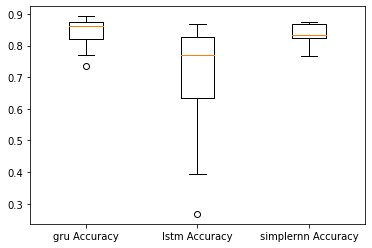

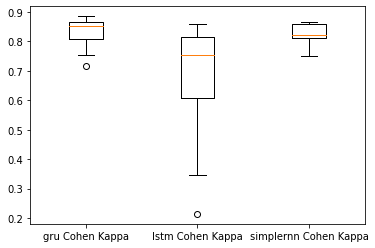

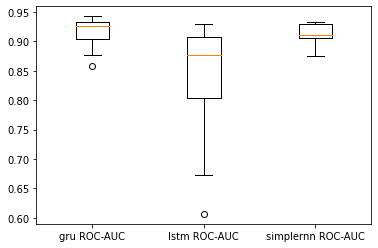

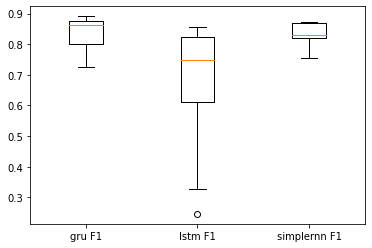

In [76]:
label1 = ['gru Accuracy','lstm Accuracy','simplernn Accuracy']
label2 = ['gru Cohen Kappa','lstm Cohen Kappa','simplernn Cohen Kappa']
label3 = ['gru ROC-AUC','lstm ROC-AUC','simplernn ROC-AUC']
label4 = ['gru F1','lstm F1','simplernn F1']
box_plot_accuracy_data = [ten_fold_gru_accuracy, ten_fold_lstm_accuracy, ten_fold_simplernn_accuracy]
box_plot_cohen_kappa_data = [ten_fold_gru_cohen_kappa, ten_fold_lstm_cohen_kappa, ten_fold_simplernn_cohen_kappa]
box_plot_roc_auc_data = [ten_fold_gru_roc_auc, ten_fold_lstm_roc_auc, ten_fold_simplernn_roc_auc]
box_plot_data_f1_data = [ten_fold_gru_f1, ten_fold_lstm_f1, ten_fold_simplernn_f1]

plt.boxplot(box_plot_accuracy_data, labels=label1)
plt.show()

plt.boxplot(box_plot_cohen_kappa_data, labels=label2)
plt.show()

plt.boxplot(box_plot_roc_auc_data, labels=label3)
plt.show()

plt.boxplot(box_plot_data_f1_data, labels=label4)
plt.show()


Simple Rnn
GRU
LSTM


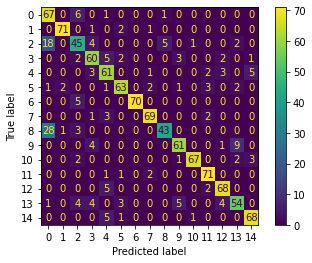

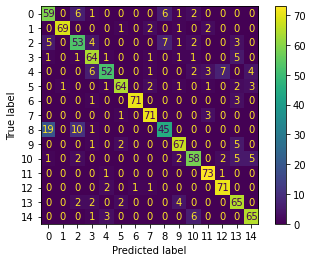

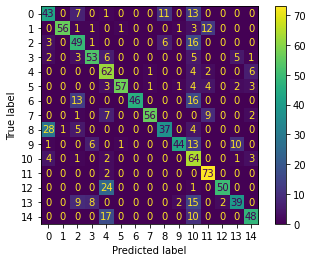

In [63]:
conf_matrix(overall_ypred_simplernn, overall_ytest, "Simple Rnn")
conf_matrix(overall_ypred_gru, overall_ytest, "GRU")
conf_matrix(overall_ypred_lstm, overall_ytest, "LSTM")

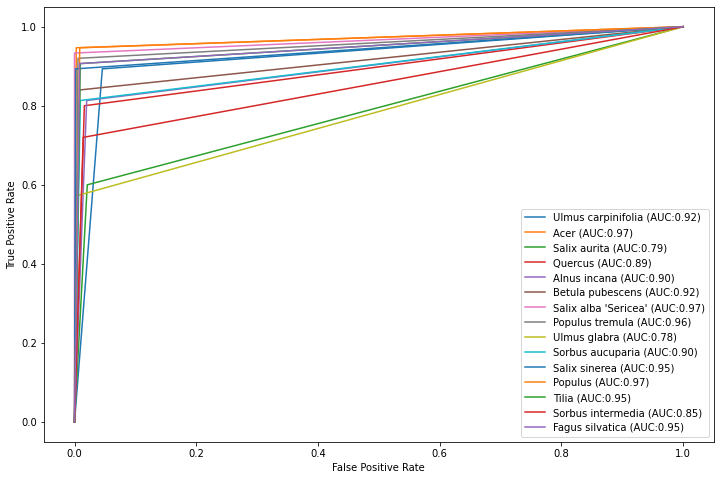

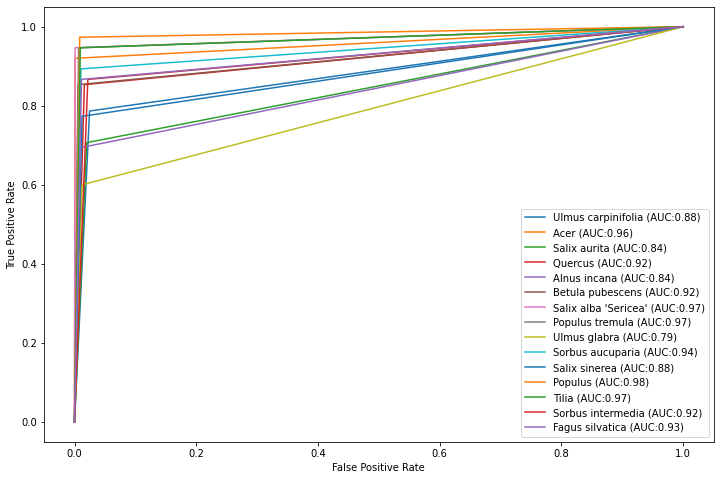

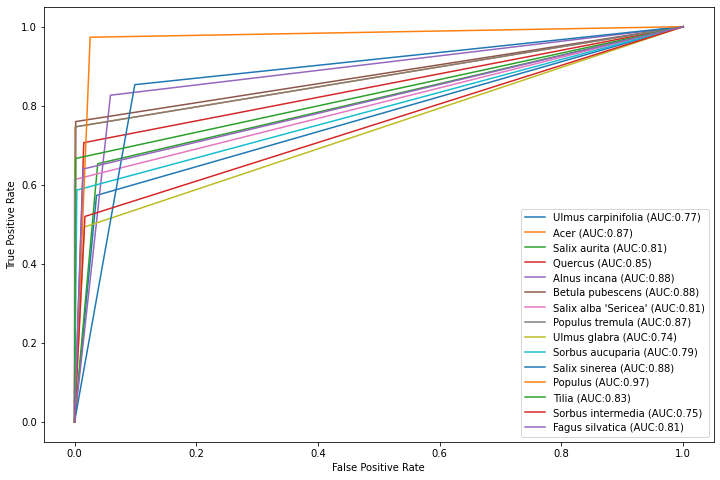

In [67]:
# simplernn, gru, lstm

for i in [overall_ypred_simplernn, overall_ypred_gru, overall_ypred_lstm]:
    plt.figure(figsize = (12, 8))
    
    lb = LabelBinarizer()
    lb.fit(overall_ytest)
    ytest_transform = lb.transform(overall_ytest)
    ypred_transform = lb.transform(i)
    
    for (j, label) in enumerate(leafNames):
        fpr, tpr, thresholds = roc_curve(ytest_transform[:,j], ypred_transform[:,j])
        plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

#     rs = roc_auc_score(ytest_rnn, i[1], average="weighted", multi_class="ovr")
#     print(f"{i[0]}: {rs}")
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()